In [4]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from risk_scores_data import generate_data, get_nodes_feature, get_age_feature, get_bmi_feature
from interpret.glassbox import ExplainableBoostingRegressor
from pysr import PySRRegressor
from interpret import show
import time
from gplearn.gplearn.genetic import SymbolicRegressor
from gplearn.gplearn.model import ShapeNN
import torch
import pickle
from utils import create_df_from_cached_results, load_share_from_checkpoint

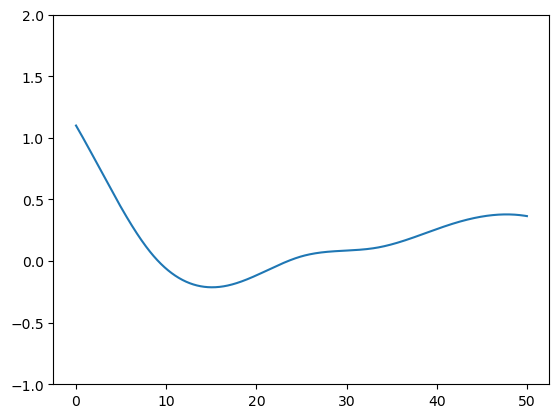

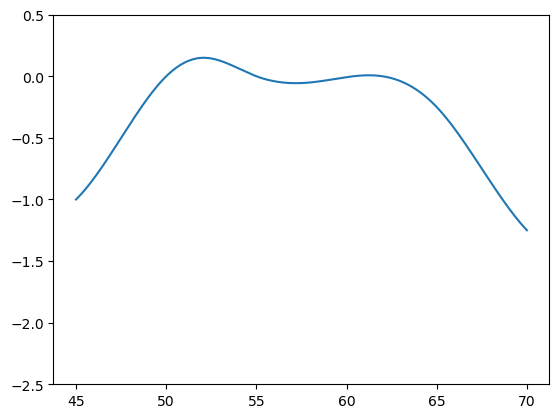

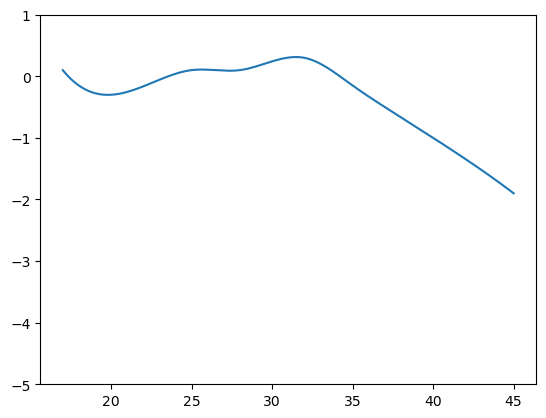

In [6]:
t = np.linspace(0,50,1000)
nodes_feature = get_nodes_feature()
plt.plot(t,nodes_feature(t))
plt.ylim(-1,2.0)
plt.show()

t = np.linspace(45,70,1000)
age_feature = get_age_feature()
plt.plot(t,age_feature(t))
plt.ylim(-2.5,0.5)
plt.show()

t = np.linspace(17,45,1000)
bmi_feature = get_bmi_feature()
plt.plot(t,bmi_feature(t))
plt.ylim(-5,1.0)
plt.show()

In [41]:
df = generate_data(100,seed=0)
X = df.drop(columns=['target']).values
y = df['target'].values

In [42]:
global_seed = 42
parameter_dict = {
    'binary_operators':["+", "*", "/", "-"],
    'unary_operators':[
        "log",
        "exp",
        "cos",
    ],
    'loss':"L2DistLoss()",
    'maxsize':20,
    'procs':0,
    'multithreading':False,
    'populations':15,
    'niterations':40,
    'population_size':33,
    'model_selection':'accuracy',
    'random_state':global_seed,
    'deterministic':True
}
model = PySRRegressor(**parameter_dict)

In [43]:
model.fit(X,y)

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pysr\sr.py:1257: UserWarning:

Note: it looks like you are running in Jupyter. The progress bar will be turned off.



PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                         -0.5330256   
	1         0.107626                                (x2 * -0.019076504)   
	2         0.106594                               cos(x2 / -15.411629)   
	3         0.159561           (exp(cos(x2 / -7.721802)) * -0.67576194)   
	4         0.082274  ((exp(cos(x2 / -7.6160564)) * -0.8976126) - -0...   
	5         0.016950  (((exp(cos(x2 / -7.87698)) * -1.2191935) + 0.4...   
	6         0.035051  ((cos(0.7919983) + (exp(cos(x2 / 8.481573)) * ...   
	7         0.028279  ((cos(cos(x1)) + (exp(cos(x2 / -8.38796)) * -1...   
	8         0.356358  (cos(0.12786764) * (cos(log(x1) / 0.12786764) ...   
	9         0.001018  (cos(exp((x0 / -0.6428558) - x2)) * (cos(log(x...   
	10        0.000555  (cos(exp((x2 / -7.904123) - exp(-7.904123))) *...   
	11  >>>>  0.187594  (cos(exp(cos(cos(x1 * -0.08302327)) - exp(cos(...   
	
	        loss  complexity  
	0   0.599844           1  
	1   0.483677           3  
	2   0.434773           4  
	3   0.269385           7  
	4   0.228513           9  
	5   0.220896          11  
	6   0.213288          12  
	7   0.207341          13  
	8   0.145184          14  
	9   0.144447          19  
	10  0.144367          20  
	11  0.119673          21  
]

In [16]:
eq = model.sympy(12)

In [29]:
eq1 = eq.args[1]

In [30]:
from sympy import lambdify, Symbol
x0 = Symbol('x0')
x1 = Symbol('x1')
x2 = Symbol('x2')

In [31]:
eq1_n = lambdify(x1,eq1)

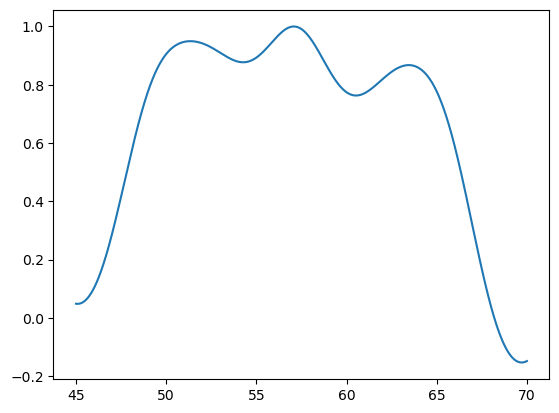

In [32]:
t = np.linspace(45,70,1000)
plt.plot(t,eq1_n(t))

In [142]:
ebm = ExplainableBoostingRegressor()

In [143]:
ebm.fit(X,y)

ExplainableBoostingRegressor()

In [144]:
ebm_global = ebm.explain_global()
show(ebm_global)

<!-- http://127.0.0.1:7001/2097001022896/ -->

In [47]:
test_df = generate_data(100,seed=1)
test_X = test_df.drop(columns=['target']).values
test_y = test_df['target'].values

In [48]:
from sklearn.metrics import r2_score

In [49]:
r2_score(test_y,ebm.predict(test_X))

0.977799788327204

In [50]:
r2_score(test_y,model.predict(test_X))

0.7666129636837835

In [55]:
def test_share(device, n_jobs, population_size, generations, batch_size):
    task = 'regression'
    global_seed = 42

    constructor_dict_ShapeNN = {
        'n_hidden_layers':5,
        'width':10,
        'activation_name':'ELU'
        }

    gp_config = {
        'population_size':population_size,
        'generations':generations,
        'tournament_size':10,
        'function_set':('add','mul','div','shape'),
        'verbose':True,
        'random_state':global_seed,
        'const_range':None,
        'n_jobs':n_jobs,
        'p_crossover':0.4,
        'p_subtree_mutation':0.2,
        'p_point_mutation':0.2,
        'p_hoist_mutation':0.05,
        'p_point_replace':0.2,
        'parsimony_coefficient':0.0,
        'metric': ('mse' if task == 'regression' else 'log loss'),
        'parsimony_coefficient':0.0,
        'optim_dict': {
            'alg':'adam',
            'lr': 1e-2, # tuned automatically
            'max_n_epochs':1000,
            'tol':1e-3,
            'task':task,
            'device':device,
            'batch_size':batch_size,
            'shape_class':ShapeNN,
            'constructor_dict': constructor_dict_ShapeNN,
            'num_workers_dataloader': 0,
            'seed':42
            }
        }

    esr = SymbolicRegressor(**gp_config, categorical_variables={})
    esr.fit(X,y)
    return esr

In [56]:
t1 = time.time()
share = test_share('cpu',1,500,10,1000)
t2 = time.time()
print(f"{t2-t1} seconds")

GPU available: True (cuda), used: False


    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
None -> None -> add(X0, X1)
add(X0, X1) | raw_fitness: 7781.975617675781
1
None -> None -> add(X0, shape(X2))
add(X0, shape(X2))


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:108: PossibleUserWarning:

You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

Missing logger folder: tb_logs\2023-01-24T04.57.02/add(X0, shape(X2))
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve 

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 99 steps due to diverging loss.
Learning rate set to 0.030199517204020192
Restoring states from the checkpoint path at lightning_logs\.lr_find_12a2fd63-fe2b-4422-8f04-6e622d507c78.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_12a2fd63-fe2b-4422-8f04-6e622d507c78.ckpt


Sanity Checking: 0it [00:00, ?it/s]

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

add(X0, shape(X2))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/div(div(shape(X1), shape(X0)), shape(X2))


add(X0, shape(X2)) | raw_fitness: 233.59360475783456
2
None -> None -> div(div(shape(X1), shape(X0)), shape(X2))
div(div(shape(X1), shape(X0)), shape(X2))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:612: UserWarning:

Checkpoint directory C:\PhD\Papers\ExtendedSR\share\checkpoints\2023-01-24T04.57.02 exists and is not empty.



Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.0007585775750291836
Restoring states from the checkpoint path at lightning_logs\.lr_find_94f5216b-1ca0-4b62-ad66-be7f6da73883.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_94f5216b-1ca0-4b62-ad66-be7f6da73883.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

div(div(shape(X1), shape(X0)), shape(X2))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(add(add(X0, shape(X1)), shape(X2)))


div(div(shape(X1), shape(X0)), shape(X2)) | raw_fitness: 0.692480903741307
3
None -> None -> add(X0, X1)
Retrieved score for add(X0, X1)
None -> None -> shape(add(add(X0, shape(X1)), shape(X2)))
shape(add(add(X0, shape(X1)), shape(X2)))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 96 steps due to diverging loss.
Learning rate set to 0.07585775750291836
Restoring states from the checkpoint path at lightning_logs\.lr_find_4eaef836-1b6d-4da7-829c-6c51cc81076e.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_4eaef836-1b6d-4da7-829c-6c51cc81076e.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.0007585775750291836
Restoring states from the checkpoint path at lightning_logs\.lr_find_442cbe35-f577-42fd-b7e5-d782b489fdba.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_442cbe35-f577-42fd-b7e5-d782b489fdba.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

div(shape(mul(shape(X1), shape(X2))), shape(X0))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/add(X1, mul(X2, shape(X0)))


div(shape(mul(shape(X1), shape(X2))), shape(X0)) | raw_fitness: 0.083879733611966
5
None -> None -> add(X1, mul(X2, shape(X0)))
add(X1, mul(X2, shape(X0)))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 96 steps due to diverging loss.
Learning rate set to 0.012022644346174132
Restoring states from the checkpoint path at lightning_logs\.lr_find_2a460c62-013c-4455-984f-786b456fe7e1.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_2a460c62-013c-4455-984f-786b456fe7e1.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

add(X1, mul(X2, shape(X0)))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/add(div(shape(X2), X1), X0)


add(X1, mul(X2, shape(X0))) | raw_fitness: 248.8554584251903
6
None -> None -> add(div(shape(X2), X1), X0)
add(div(shape(X2), X1), X0)


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.10964781961431852
Restoring states from the checkpoint path at lightning_logs\.lr_find_c318dc7d-bd29-407e-b221-1514b913f363.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_c318dc7d-bd29-407e-b221-1514b913f363.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

add(div(shape(X2), X1), X0)


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(div(div(shape(X0), shape(X2)), shape(X1)))


add(div(shape(X2), X1), X0) | raw_fitness: 271.11743437319996
7
None -> None -> shape(div(div(shape(X0), shape(X2)), shape(X1)))
shape(div(div(shape(X0), shape(X2)), shape(X1)))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 95 steps due to diverging loss.
Learning rate set to 0.006918309709189364
Restoring states from the checkpoint path at lightning_logs\.lr_find_cd82f1d2-d001-4960-93d1-e7317c4a19ed.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_cd82f1d2-d001-4960-93d1-e7317c4a19ed.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(div(div(shape(X0), shape(X2)), shape(X1)))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/mul(mul(shape(X2), shape(X1)), shape(X0))


shape(div(div(shape(X0), shape(X2)), shape(X1))) | raw_fitness: 0.02478170660671367
8
None -> None -> mul(mul(shape(X2), shape(X1)), shape(X0))
mul(mul(shape(X2), shape(X1)), shape(X0))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 93 steps due to diverging loss.
Learning rate set to 0.01445439770745928
Restoring states from the checkpoint path at lightning_logs\.lr_find_1130126e-cf4f-45d7-90f2-c8c22e803a89.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_1130126e-cf4f-45d7-90f2-c8c22e803a89.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

LR finder stopped early after 95 steps due to diverging loss.
Learning rate set to 0.04365158322401657
Restoring states from the checkpoint path at lightning_logs\.lr_find_ba9123b4-9c95-491e-b653-1311c6cd0cda.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_ba9123b4-9c95-491e-b653-1311c6cd0cda.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(X2)


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/div(mul(X2, shape(X1)), shape(X0))


shape(X2) | raw_fitness: 0.20498442151490961
10
None -> None -> div(mul(X2, shape(X1)), shape(X0))
div(mul(X2, shape(X1)), shape(X0))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.0019054607179632484
Restoring states from the checkpoint path at lightning_logs\.lr_find_7c2d7d70-24d4-4925-a279-835767fd10b2.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_7c2d7d70-24d4-4925-a279-835767fd10b2.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

div(mul(X2, shape(X1)), shape(X0))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/mul(mul(X2, shape(X1)), X0)


div(mul(X2, shape(X1)), shape(X0)) | raw_fitness: 0.4744825871588546
11
None -> None -> mul(mul(X2, shape(X1)), X0)
mul(mul(X2, shape(X1)), X0)


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 97 steps due to diverging loss.
Learning rate set to 0.0019054607179632484
Restoring states from the checkpoint path at lightning_logs\.lr_find_09a57c38-0197-48c4-8d7d-f862bdc74f27.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_09a57c38-0197-48c4-8d7d-f862bdc74f27.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

mul(mul(X2, shape(X1)), X0)


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/add(shape(X0), add(X2, X1))


mul(mul(X2, shape(X1)), X0) | raw_fitness: 0.7251341816774948
12
None -> None -> add(shape(X0), add(X2, X1))
add(shape(X0), add(X2, X1))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.0630957344480193
Restoring states from the checkpoint path at lightning_logs\.lr_find_0397b1bf-c2e1-4f6c-84a0-e076f41010cd.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_0397b1bf-c2e1-4f6c-84a0-e076f41010cd.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

add(shape(X0), add(X2, X1))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(mul(add(X2, X0), shape(X1)))


add(shape(X0), add(X2, X1)) | raw_fitness: 142.57731213591993
13
None -> None -> shape(mul(add(X2, X0), shape(X1)))
shape(mul(add(X2, X0), shape(X1)))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 96 steps due to diverging loss.
Learning rate set to 0.0630957344480193
Restoring states from the checkpoint path at lightning_logs\.lr_find_896b5fc5-5d8d-439e-b427-a05985f96438.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_896b5fc5-5d8d-439e-b427-a05985f96438.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

LR finder stopped early after 96 steps due to diverging loss.
Learning rate set to 0.09120108393559097
Restoring states from the checkpoint path at lightning_logs\.lr_find_b236a544-0fa5-443a-8a48-4eee79cafdee.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_b236a544-0fa5-443a-8a48-4eee79cafdee.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(add(X1, div(shape(X0), X2)))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/div(X1, add(X0, shape(X2)))


shape(add(X1, div(shape(X0), X2))) | raw_fitness: 0.21658851099623008
15
None -> None -> div(X1, add(X0, shape(X2)))
div(X1, add(X0, shape(X2)))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.0007585775750291836
Restoring states from the checkpoint path at lightning_logs\.lr_find_6a64233d-148b-4a66-898c-8d1479a8d50e.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_6a64233d-148b-4a66-898c-8d1479a8d50e.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

LR finder stopped early after 96 steps due to diverging loss.
Learning rate set to 0.05248074602497723
Restoring states from the checkpoint path at lightning_logs\.lr_find_f806ea09-1494-48e1-9e87-d0764be448e4.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_f806ea09-1494-48e1-9e87-d0764be448e4.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

add(X2, shape(add(shape(X1), X0)))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(mul(X0, X1))


add(X2, shape(add(shape(X1), X0))) | raw_fitness: 72.19853108252282
17
None -> None -> shape(mul(X0, X1))
shape(mul(X0, X1))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 96 steps due to diverging loss.
Learning rate set to 0.006918309709189364
Restoring states from the checkpoint path at lightning_logs\.lr_find_e574d673-7e02-421b-afc2-146dc91a59d9.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_e574d673-7e02-421b-afc2-146dc91a59d9.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.00478630092322638
Restoring states from the checkpoint path at lightning_logs\.lr_find_8a81f1f6-4b44-4027-8c8c-83737f349117.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_8a81f1f6-4b44-4027-8c8c-83737f349117.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

div(shape(X2), shape(X1))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(X1)


div(shape(X2), shape(X1)) | raw_fitness: 0.14990336891112407
19
None -> None -> shape(X1)
shape(X1)


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 96 steps due to diverging loss.
Learning rate set to 0.0630957344480193
Restoring states from the checkpoint path at lightning_logs\.lr_find_e1ee8b11-8014-4f1f-a57a-2dea42b6188b.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_e1ee8b11-8014-4f1f-a57a-2dea42b6188b.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

add(X1, shape(X0))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(div(shape(X2), shape(X0)))


add(X1, shape(X0)) | raw_fitness: 56.06347298622587
21
None -> None -> shape(div(shape(X2), shape(X0)))
shape(div(shape(X2), shape(X0)))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 96 steps due to diverging loss.
Learning rate set to 0.036307805477010104
Restoring states from the checkpoint path at lightning_logs\.lr_find_5b043b01-de50-4e21-b281-aab5f26a69a9.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_5b043b01-de50-4e21-b281-aab5f26a69a9.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.005754399373371567
Restoring states from the checkpoint path at lightning_logs\.lr_find_341e8d05-f726-457b-b4f3-84e3ae4dc845.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_341e8d05-f726-457b-b4f3-84e3ae4dc845.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

LR finder stopped early after 93 steps due to diverging loss.
Learning rate set to 0.04365158322401657
Restoring states from the checkpoint path at lightning_logs\.lr_find_368f2693-2a37-4839-978c-94aa28a93200.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_368f2693-2a37-4839-978c-94aa28a93200.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

mul(shape(X2), shape(div(X0, X1)))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/mul(shape(X2), shape(X0))


mul(shape(X2), shape(div(X0, X1))) | raw_fitness: 0.1730499257615952
24
None -> None -> mul(shape(X2), shape(X0))
mul(shape(X2), shape(X0))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 94 steps due to diverging loss.
Learning rate set to 0.13182567385564073
Restoring states from the checkpoint path at lightning_logs\.lr_find_fb733f7b-9a89-4761-bc9d-277d2bff3175.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_fb733f7b-9a89-4761-bc9d-277d2bff3175.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

mul(shape(X2), shape(X0))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/mul(add(shape(X1), shape(X2)), shape(X0))


mul(shape(X2), shape(X0)) | raw_fitness: 0.1970226082466073
25
None -> None -> mul(div(X0, X2), X1)
mul(div(X0, X2), X1) | raw_fitness: 4385.287004116648
26
None -> None -> mul(add(shape(X1), shape(X2)), shape(X0))
mul(add(shape(X1), shape(X2)), shape(X0))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 92 steps due to diverging loss.
Learning rate set to 0.036307805477010104
Restoring states from the checkpoint path at lightning_logs\.lr_find_613854c9-d5f3-4cda-95a2-9fd2fecaa4f2.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_613854c9-d5f3-4cda-95a2-9fd2fecaa4f2.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

LR finder stopped early after 98 steps due to diverging loss.
Learning rate set to 0.003981071705534969
Restoring states from the checkpoint path at lightning_logs\.lr_find_e5938ae5-e3b4-42f6-9f7b-064c1d3ea4b6.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_e5938ae5-e3b4-42f6-9f7b-064c1d3ea4b6.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

add(div(shape(X0), shape(X2)), shape(X1))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/add(X1, shape(X2))


add(div(shape(X0), shape(X2)), shape(X1)) | raw_fitness: 0.009376163225510936
28
None -> None -> add(X1, shape(X2))
add(X1, shape(X2))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.0630957344480193
Restoring states from the checkpoint path at lightning_logs\.lr_find_37762114-9e62-4413-87b7-35f5cf61fb52.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_37762114-9e62-4413-87b7-35f5cf61fb52.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

add(X1, shape(X2))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/mul(shape(div(shape(X2), X0)), shape(X1))


add(X1, shape(X2)) | raw_fitness: 59.16770176733844
29
None -> None -> mul(shape(div(shape(X2), X0)), shape(X1))
mul(shape(div(shape(X2), X0)), shape(X1))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 93 steps due to diverging loss.
Learning rate set to 0.04365158322401657
Restoring states from the checkpoint path at lightning_logs\.lr_find_ee7de5b8-8700-4ed2-9ec5-c4f656f95eae.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_ee7de5b8-8700-4ed2-9ec5-c4f656f95eae.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

mul(shape(div(shape(X2), X0)), shape(X1))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(X0)


mul(shape(div(shape(X2), X0)), shape(X1)) | raw_fitness: 0.13025647134001703
30
None -> None -> shape(X0)
shape(X0)


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 95 steps due to diverging loss.
Learning rate set to 0.006918309709189364
Restoring states from the checkpoint path at lightning_logs\.lr_find_b013c340-8533-42c1-89a6-69a4c5b750f7.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_b013c340-8533-42c1-89a6-69a4c5b750f7.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.


mul(add(X0, X1), shape(X2))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(mul(shape(X1), shape(X2)))


mul(add(X0, X1), shape(X2)) | raw_fitness: 0.19600825034256558
32
None -> None -> shape(mul(shape(X1), shape(X2)))
shape(mul(shape(X1), shape(X2)))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 95 steps due to diverging loss.
Learning rate set to 0.02089296130854041
Restoring states from the checkpoint path at lightning_logs\.lr_find_7b1abff6-8f11-46e9-82ff-9fefff708c5a.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_7b1abff6-8f11-46e9-82ff-9fefff708c5a.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(mul(shape(X1), shape(X2)))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/div(mul(shape(X0), shape(X1)), shape(X2))


shape(mul(shape(X1), shape(X2))) | raw_fitness: 0.08189288139745202
33
None -> None -> div(mul(shape(X0), shape(X1)), shape(X2))
div(mul(shape(X0), shape(X1)), shape(X2))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.001584893192461114
Restoring states from the checkpoint path at lightning_logs\.lr_find_8311995c-960f-4d8f-8fdc-40063c2db7e4.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_8311995c-960f-4d8f-8fdc-40063c2db7e4.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

div(mul(shape(X0), shape(X1)), shape(X2))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/add(shape(X1), shape(X0))


div(mul(shape(X0), shape(X1)), shape(X2)) | raw_fitness: 0.22588302991358433
34
None -> None -> add(shape(X1), shape(X0))
add(shape(X1), shape(X0))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 96 steps due to diverging loss.
Learning rate set to 0.09120108393559097
Restoring states from the checkpoint path at lightning_logs\.lr_find_2549cb16-1aa3-4b64-9649-803e336b7d79.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_2549cb16-1aa3-4b64-9649-803e336b7d79.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

add(shape(X1), shape(X0))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/add(add(shape(X0), shape(X1)), shape(X2))


add(shape(X1), shape(X0)) | raw_fitness: 0.350079455453527
35
None -> None -> add(add(shape(X0), shape(X1)), shape(X2))
add(add(shape(X0), shape(X1)), shape(X2))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 95 steps due to diverging loss.
Learning rate set to 0.0630957344480193
Restoring states from the checkpoint path at lightning_logs\.lr_find_7cf7503a-a8f0-46c5-9288-14fea8f46e3b.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_7cf7503a-a8f0-46c5-9288-14fea8f46e3b.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

add(add(shape(X0), shape(X1)), shape(X2))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/add(div(shape(X0), shape(X1)), shape(X2))


add(add(shape(X0), shape(X1)), shape(X2)) | raw_fitness: 0.0036770220574811672
36
None -> None -> add(div(shape(X0), shape(X1)), shape(X2))
add(div(shape(X0), shape(X1)), shape(X2))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 89 steps due to diverging loss.
Learning rate set to 0.003981071705534969
Restoring states from the checkpoint path at lightning_logs\.lr_find_90af3162-b06e-47df-bba1-f8c11347448c.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_90af3162-b06e-47df-bba1-f8c11347448c.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

add(div(shape(X0), shape(X1)), shape(X2))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(mul(mul(shape(X0), shape(X2)), shape(X1)))


add(div(shape(X0), shape(X1)), shape(X2)) | raw_fitness: 0.005276999768163933
37
None -> None -> shape(mul(mul(shape(X0), shape(X2)), shape(X1)))
shape(mul(mul(shape(X0), shape(X2)), shape(X1)))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 93 steps due to diverging loss.
Learning rate set to 0.02089296130854041
Restoring states from the checkpoint path at lightning_logs\.lr_find_3459d587-d961-4457-b674-40a2c00dade6.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_3459d587-d961-4457-b674-40a2c00dade6.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(mul(mul(shape(X0), shape(X2)), shape(X1)))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/add(X2, shape(X0))


shape(mul(mul(shape(X0), shape(X2)), shape(X1))) | raw_fitness: 0.008502448510696467
38
None -> None -> add(X2, shape(X0))
add(X2, shape(X0))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.05248074602497723
Restoring states from the checkpoint path at lightning_logs\.lr_find_a97aeca0-c5fa-4a9b-afc3-97cdc4606e07.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_a97aeca0-c5fa-4a9b-afc3-97cdc4606e07.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

add(X2, shape(X0))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/mul(div(shape(X0), shape(X2)), shape(X1))


add(X2, shape(X0)) | raw_fitness: 74.24157958530355
39
None -> None -> mul(X2, X0)
mul(X2, X0) | raw_fitness: 1080275.7617965983
40
None -> None -> mul(div(shape(X0), shape(X2)), shape(X1))
mul(div(shape(X0), shape(X2)), shape(X1))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 78 steps due to diverging loss.
Learning rate set to 0.01445439770745928
Restoring states from the checkpoint path at lightning_logs\.lr_find_2ebb6386-0c35-4846-8620-9ca83bb6dcbb.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_2ebb6386-0c35-4846-8620-9ca83bb6dcbb.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

LR finder stopped early after 93 steps due to diverging loss.
Learning rate set to 0.030199517204020192
Restoring states from the checkpoint path at lightning_logs\.lr_find_1d055479-2d6c-4c22-80c4-73090303a1fa.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_1d055479-2d6c-4c22-80c4-73090303a1fa.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

mul(add(shape(X0), shape(X1)), shape(X2))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(add(X2, mul(X0, X1)))


mul(add(shape(X0), shape(X1)), shape(X2)) | raw_fitness: 0.09130015902541345
42
None -> None -> shape(add(X2, mul(X0, X1)))
shape(add(X2, mul(X0, X1)))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 96 steps due to diverging loss.
Learning rate set to 0.006918309709189364
Restoring states from the checkpoint path at lightning_logs\.lr_find_b520300d-93ac-4f6d-8298-ccd714630518.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_b520300d-93ac-4f6d-8298-ccd714630518.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(add(X2, mul(X0, X1)))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/div(shape(X0), shape(X2))


shape(add(X2, mul(X0, X1))) | raw_fitness: 0.5406211731270946
43
None -> None -> add(X0, X1)
Retrieved score for add(X0, X1)
None -> None -> div(shape(X0), shape(X2))
div(shape(X0), shape(X2))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.8317637711026709
Restoring states from the checkpoint path at lightning_logs\.lr_find_76586992-3b2f-45f7-989a-d0553136d9be.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_76586992-3b2f-45f7-989a-d0553136d9be.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

div(shape(X0), shape(X2))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/add(shape(add(shape(X0), shape(X1))), shape(X2))


div(shape(X0), shape(X2)) | raw_fitness: 0.8783327456939515
44
None -> None -> shape(X0)
Retrieved score for shape(X0)
None -> None -> add(shape(add(shape(X0), shape(X1))), shape(X2))
add(shape(add(shape(X0), shape(X1))), shape(X2))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 95 steps due to diverging loss.
Learning rate set to 0.04365158322401657
Restoring states from the checkpoint path at lightning_logs\.lr_find_aaa87d76-b556-44f7-be0f-2abe5d042a74.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_aaa87d76-b556-44f7-be0f-2abe5d042a74.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

add(shape(add(shape(X0), shape(X1))), shape(X2))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/div(mul(shape(X1), shape(X2)), shape(X0))


add(shape(add(shape(X0), shape(X1))), shape(X2)) | raw_fitness: 0.002330901867564279
45
None -> None -> div(mul(shape(X1), shape(X2)), shape(X0))
div(mul(shape(X1), shape(X2)), shape(X0))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.0013182567385564075
Restoring states from the checkpoint path at lightning_logs\.lr_find_09c3ba35-0bbb-48e9-a89c-66378a207d6b.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_09c3ba35-0bbb-48e9-a89c-66378a207d6b.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

div(shape(X2), X1)


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/mul(X0, div(shape(X1), X2))


div(shape(X2), X1) | raw_fitness: 0.22897153813499357
48
None -> None -> mul(X0, div(shape(X1), X2))
mul(X0, div(shape(X1), X2))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 94 steps due to diverging loss.
Learning rate set to 0.10964781961431852
Restoring states from the checkpoint path at lightning_logs\.lr_find_3c16adc7-1064-4cd7-84b5-397a5f5824cf.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_3c16adc7-1064-4cd7-84b5-397a5f5824cf.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

mul(X0, div(shape(X1), X2))


Predicting: 1it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

add(mul(shape(X1), X2), shape(X0))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/div(X1, add(shape(X2), X0))


add(mul(shape(X1), X2), shape(X0)) | raw_fitness: 0.47733877510618183
50
None -> None -> div(X1, add(shape(X2), X0))
div(X1, add(shape(X2), X0))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.0007585775750291836
Restoring states from the checkpoint path at lightning_logs\.lr_find_6aad9f55-aed4-4ebe-afa0-2b1912327305.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_6aad9f55-aed4-4ebe-afa0-2b1912327305.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

LR finder stopped early after 95 steps due to diverging loss.
Learning rate set to 0.05248074602497723
Restoring states from the checkpoint path at lightning_logs\.lr_find_6cffac58-773d-4793-91a4-0299165bcb35.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_6cffac58-773d-4793-91a4-0299165bcb35.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(add(div(shape(X1), shape(X0)), shape(X2)))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/mul(shape(div(shape(X2), shape(X0))), shape(X1))


shape(add(div(shape(X1), shape(X0)), shape(X2))) | raw_fitness: 0.19335333971783203
53
None -> None -> mul(shape(div(shape(X2), shape(X0))), shape(X1))
mul(shape(div(shape(X2), shape(X0))), shape(X1))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 94 steps due to diverging loss.
Learning rate set to 0.036307805477010104
Restoring states from the checkpoint path at lightning_logs\.lr_find_e46ebc43-91f1-478e-93a0-1af1ccbbcc3b.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_e46ebc43-91f1-478e-93a0-1af1ccbbcc3b.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

mul(shape(div(shape(X2), shape(X0))), shape(X1))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/mul(X2, shape(div(X0, X1)))


mul(shape(div(shape(X2), shape(X0))), shape(X1)) | raw_fitness: 0.0811698286342471
54
None -> None -> mul(X2, shape(div(X0, X1)))
mul(X2, shape(div(X0, X1)))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 97 steps due to diverging loss.
Learning rate set to 0.001584893192461114
Restoring states from the checkpoint path at lightning_logs\.lr_find_21d7f441-f829-483f-8c59-a9f242006d0b.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_21d7f441-f829-483f-8c59-a9f242006d0b.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

mul(X0, shape(X1))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/mul(shape(X1), X0)


mul(X0, shape(X1)) | raw_fitness: 0.6203454757515283
56
None -> None -> shape(X0)
Retrieved score for shape(X0)
None -> None -> shape(X1)
Retrieved score for shape(X1)
None -> None -> mul(shape(X1), X0)
mul(shape(X1), X0)


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 98 steps due to diverging loss.
Learning rate set to 0.001584893192461114
Restoring states from the checkpoint path at lightning_logs\.lr_find_cdb847eb-845e-41b5-b305-dea50a224473.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_cdb847eb-845e-41b5-b305-dea50a224473.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

mul(shape(X1), X0)


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/mul(mul(shape(X1), shape(X0)), shape(X2))


mul(shape(X1), X0) | raw_fitness: 0.6203454757515283
57
None -> None -> mul(mul(shape(X1), shape(X0)), shape(X2))
mul(mul(shape(X1), shape(X0)), shape(X2))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 88 steps due to diverging loss.
Learning rate set to 0.09120108393559097
Restoring states from the checkpoint path at lightning_logs\.lr_find_e545b51e-2fba-4038-bc65-74132e1c7900.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_e545b51e-2fba-4038-bc65-74132e1c7900.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

mul(mul(shape(X1), shape(X0)), shape(X2))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/div(div(shape(X0), shape(X1)), shape(X2))


mul(mul(shape(X1), shape(X0)), shape(X2)) | raw_fitness: 0.10941120227848841
58
None -> None -> div(div(shape(X0), shape(X1)), shape(X2))
div(div(shape(X0), shape(X1)), shape(X2))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.0007585775750291836
Restoring states from the checkpoint path at lightning_logs\.lr_find_953429ef-d4ab-4d5e-a787-5e7caf9c17c2.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_953429ef-d4ab-4d5e-a787-5e7caf9c17c2.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

div(div(shape(X0), shape(X1)), shape(X2))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/add(X0, add(X2, shape(X1)))


div(div(shape(X0), shape(X1)), shape(X2)) | raw_fitness: 0.7150761572970441
59
None -> None -> shape(X0)
Retrieved score for shape(X0)
None -> None -> add(X0, add(X2, shape(X1)))
add(X0, add(X2, shape(X1)))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.0630957344480193
Restoring states from the checkpoint path at lightning_logs\.lr_find_c63e6670-749b-4d83-bb4a-db5b589c318e.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_c63e6670-749b-4d83-bb4a-db5b589c318e.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

LR finder stopped early after 96 steps due to diverging loss.
Learning rate set to 0.025118864315095822
Restoring states from the checkpoint path at lightning_logs\.lr_find_2a4fdf1d-b7ea-45cb-a6b8-f3e311f2d32f.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_2a4fdf1d-b7ea-45cb-a6b8-f3e311f2d32f.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(add(X1, shape(X2)))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(div(shape(X0), shape(X2)))


shape(add(X1, shape(X2))) | raw_fitness: 0.327577099735845
62
None -> None -> shape(X0)
Retrieved score for shape(X0)
None -> None -> shape(div(shape(X0), shape(X2)))
shape(div(shape(X0), shape(X2)))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 96 steps due to diverging loss.
Learning rate set to 0.05248074602497723
Restoring states from the checkpoint path at lightning_logs\.lr_find_7e0bc798-1c12-4757-bb63-9e8618956eb5.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_7e0bc798-1c12-4757-bb63-9e8618956eb5.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(div(shape(X0), shape(X2)))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(mul(shape(X0), shape(X2)))


shape(div(shape(X0), shape(X2))) | raw_fitness: 0.21298385546921053
63
None -> None -> shape(mul(shape(X0), shape(X2)))
shape(mul(shape(X0), shape(X2)))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 95 steps due to diverging loss.
Learning rate set to 0.02089296130854041
Restoring states from the checkpoint path at lightning_logs\.lr_find_e5dff9c1-29e3-425b-aae6-06c9c8058f16.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_e5dff9c1-29e3-425b-aae6-06c9c8058f16.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(mul(shape(X0), shape(X2)))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/mul(X1, mul(shape(X0), X2))


shape(mul(shape(X0), shape(X2))) | raw_fitness: 0.1711169857130585
64
None -> None -> mul(X2, X0)
Retrieved score for mul(X2, X0)
None -> None -> mul(X1, mul(shape(X0), X2))
mul(X1, mul(shape(X0), X2))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 98 steps due to diverging loss.
Learning rate set to 0.0019054607179632484
Restoring states from the checkpoint path at lightning_logs\.lr_find_81fa4d7c-2825-42ec-9e3f-b6e8c304fd02.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_81fa4d7c-2825-42ec-9e3f-b6e8c304fd02.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

mul(X1, mul(shape(X0), X2))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/mul(shape(X0), shape(X1))


mul(X1, mul(shape(X0), X2)) | raw_fitness: 0.3834434900958149
65
None -> None -> mul(shape(X0), shape(X1))
mul(shape(X0), shape(X1))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 90 steps due to diverging loss.
Learning rate set to 0.017378008287493765
Restoring states from the checkpoint path at lightning_logs\.lr_find_dbdf93a4-440b-49ba-8ea8-75084bb18e7d.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_dbdf93a4-440b-49ba-8ea8-75084bb18e7d.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

add(shape(X2), shape(X0))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(add(div(shape(X2), shape(X0)), shape(X1)))


add(shape(X2), shape(X0)) | raw_fitness: 0.15171518976302437
68
None -> None -> shape(add(div(shape(X2), shape(X0)), shape(X1)))
shape(add(div(shape(X2), shape(X0)), shape(X1)))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 95 steps due to diverging loss.
Learning rate set to 0.030199517204020192
Restoring states from the checkpoint path at lightning_logs\.lr_find_115f2df1-5adb-409a-be38-db3e5329d56d.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_115f2df1-5adb-409a-be38-db3e5329d56d.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(add(div(shape(X2), shape(X0)), shape(X1)))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/div(mul(X0, shape(X2)), shape(X1))


shape(add(div(shape(X2), shape(X0)), shape(X1))) | raw_fitness: 0.012436289613874862
69
None -> None -> add(X0, X1)
Retrieved score for add(X0, X1)
None -> None -> div(mul(X0, shape(X2)), shape(X1))
div(mul(X0, shape(X2)), shape(X1))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.0019054607179632484
Restoring states from the checkpoint path at lightning_logs\.lr_find_f803b81a-49b4-4fa3-9699-16eb4372cf30.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_f803b81a-49b4-4fa3-9699-16eb4372cf30.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

div(mul(X0, shape(X2)), shape(X1))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/add(shape(X0), add(X2, shape(X1)))


div(mul(X0, shape(X2)), shape(X1)) | raw_fitness: 0.3129995505997067
70
None -> None -> add(shape(X0), add(X2, shape(X1)))
add(shape(X0), add(X2, shape(X1)))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 99 steps due to diverging loss.
Learning rate set to 0.025118864315095822
Restoring states from the checkpoint path at lightning_logs\.lr_find_23c96b11-7696-46f7-a96b-96fe364bf6a1.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_23c96b11-7696-46f7-a96b-96fe364bf6a1.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

add(div(shape(X1), X2), X0)


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(add(shape(X1), shape(X2)))


add(div(shape(X1), X2), X0) | raw_fitness: 271.2374913352728
72
None -> None -> shape(add(shape(X1), shape(X2)))
shape(add(shape(X1), shape(X2)))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 96 steps due to diverging loss.
Learning rate set to 0.017378008287493765
Restoring states from the checkpoint path at lightning_logs\.lr_find_e0564e41-7463-429c-bc36-50bfd3d051ca.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_e0564e41-7463-429c-bc36-50bfd3d051ca.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(add(shape(X1), shape(X2)))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(add(X2, shape(mul(shape(X0), X1))))


shape(add(shape(X1), shape(X2))) | raw_fitness: 0.06268428542563925
73
None -> None -> div(shape(X0), shape(X2))
Retrieved score for div(shape(X0), shape(X2))
None -> None -> shape(add(X2, shape(mul(shape(X0), X1))))
shape(add(X2, shape(mul(shape(X0), X1))))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 96 steps due to diverging loss.
Learning rate set to 0.04365158322401657
Restoring states from the checkpoint path at lightning_logs\.lr_find_02dd99bb-6b60-40ff-994e-ea7c1fcf32bc.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_02dd99bb-6b60-40ff-994e-ea7c1fcf32bc.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(add(X2, shape(mul(shape(X0), X1))))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/add(div(shape(X2), shape(X1)), shape(X0))


shape(add(X2, shape(mul(shape(X0), X1)))) | raw_fitness: 0.18400394162299563
74
None -> None -> add(div(shape(X2), shape(X1)), shape(X0))
add(div(shape(X2), shape(X1)), shape(X0))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 88 steps due to diverging loss.
Learning rate set to 0.003981071705534969
Restoring states from the checkpoint path at lightning_logs\.lr_find_1dba2d35-b5a0-4e46-b7b5-d06e116ba267.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_1dba2d35-b5a0-4e46-b7b5-d06e116ba267.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(add(div(shape(X2), shape(X1)), shape(X0)))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(mul(X1, shape(X0)))


shape(add(div(shape(X2), shape(X1)), shape(X0))) | raw_fitness: 0.01090036781017524
76
None -> None -> shape(mul(X1, shape(X0)))
shape(mul(X1, shape(X0)))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 94 steps due to diverging loss.
Learning rate set to 0.006918309709189364
Restoring states from the checkpoint path at lightning_logs\.lr_find_21b08f5a-ea70-4a33-aac0-39936c7eae63.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_21b08f5a-ea70-4a33-aac0-39936c7eae63.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(mul(X1, shape(X0)))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(add(X0, add(X2, X1)))


shape(mul(X1, shape(X0))) | raw_fitness: 0.5463851602368232
77
None -> None -> shape(X2)
Retrieved score for shape(X2)
None -> None -> shape(X2)
Retrieved score for shape(X2)
None -> None -> shape(add(X0, add(X2, X1)))
shape(add(X0, add(X2, X1)))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 96 steps due to diverging loss.
Learning rate set to 0.025118864315095822
Restoring states from the checkpoint path at lightning_logs\.lr_find_0abd471d-2053-4153-804c-27897589409c.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_0abd471d-2053-4153-804c-27897589409c.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(add(X0, add(X2, X1)))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/div(add(shape(X1), shape(X0)), shape(X2))


shape(add(X0, add(X2, X1))) | raw_fitness: 0.4108182058145758
78
None -> None -> div(add(shape(X1), shape(X0)), shape(X2))
div(add(shape(X1), shape(X0)), shape(X2))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.0009120108393559097
Restoring states from the checkpoint path at lightning_logs\.lr_find_e0fc0938-b792-4a0c-b468-76bb4f9b4a2e.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_e0fc0938-b792-4a0c-b468-76bb4f9b4a2e.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

div(add(shape(X1), shape(X0)), shape(X2))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/div(div(shape(X0), shape(X2)), shape(X1))


div(add(shape(X1), shape(X0)), shape(X2)) | raw_fitness: 0.6723605447628416
79
None -> None -> div(div(shape(X0), shape(X2)), shape(X1))
div(div(shape(X0), shape(X2)), shape(X1))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.0007585775750291836
Restoring states from the checkpoint path at lightning_logs\.lr_find_cb2f57c2-f7d8-419c-9d44-baf24917c63f.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_cb2f57c2-f7d8-419c-9d44-baf24917c63f.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

LR finder stopped early after 94 steps due to diverging loss.
Learning rate set to 0.09120108393559097
Restoring states from the checkpoint path at lightning_logs\.lr_find_61f76c18-bb1a-4af4-a384-3c14304003c8.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_61f76c18-bb1a-4af4-a384-3c14304003c8.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

add(mul(shape(X0), shape(X2)), shape(X1))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/mul(shape(X0), mul(X1, shape(X2)))


add(mul(shape(X0), shape(X2)), shape(X1)) | raw_fitness: 0.015113980921523763
81
None -> None -> mul(shape(X0), mul(X1, shape(X2)))
mul(shape(X0), mul(X1, shape(X2)))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 93 steps due to diverging loss.
Learning rate set to 0.0022908676527677745
Restoring states from the checkpoint path at lightning_logs\.lr_find_f55b0057-4921-41f7-a307-286d3e7d2482.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_f55b0057-4921-41f7-a307-286d3e7d2482.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

mul(shape(X0), mul(X1, shape(X2)))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(add(add(X0, X1), X2))


mul(shape(X0), mul(X1, shape(X2))) | raw_fitness: 0.1622159412651672
82
None -> None -> shape(add(add(X0, X1), X2))
shape(add(add(X0, X1), X2))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 96 steps due to diverging loss.
Learning rate set to 0.025118864315095822
Restoring states from the checkpoint path at lightning_logs\.lr_find_66455614-7fa1-4d19-b11e-92d35aaf5f08.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_66455614-7fa1-4d19-b11e-92d35aaf5f08.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

LR finder stopped early after 94 steps due to diverging loss.
Learning rate set to 0.036307805477010104
Restoring states from the checkpoint path at lightning_logs\.lr_find_23efbe69-0a12-4d11-b77b-a6cf1dc3abe3.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_23efbe69-0a12-4d11-b77b-a6cf1dc3abe3.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

add(shape(add(shape(X2), shape(X0))), shape(X1))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/div(shape(X0), shape(X1))


add(shape(add(shape(X2), shape(X0))), shape(X1)) | raw_fitness: 0.0029102595199512393
84
None -> None -> div(shape(X0), shape(X1))
div(shape(X0), shape(X1))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.00478630092322638
Restoring states from the checkpoint path at lightning_logs\.lr_find_f0026cfa-d428-49b3-8d8d-59c3c0125351.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_f0026cfa-d428-49b3-8d8d-59c3c0125351.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

div(shape(X0), shape(X1))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(add(add(shape(X0), shape(X1)), shape(X2)))


div(shape(X0), shape(X1)) | raw_fitness: 0.40724863719486165
85
None -> None -> shape(X0)
Retrieved score for shape(X0)
None -> None -> shape(add(add(shape(X0), shape(X1)), shape(X2)))
shape(add(add(shape(X0), shape(X1)), shape(X2)))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 94 steps due to diverging loss.
Learning rate set to 0.025118864315095822
Restoring states from the checkpoint path at lightning_logs\.lr_find_0bb39179-6a9d-4137-8a9f-0acec25a8017.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_0bb39179-6a9d-4137-8a9f-0acec25a8017.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(add(add(shape(X0), shape(X1)), shape(X2)))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/div(shape(div(shape(X2), shape(X1))), shape(X0))


shape(add(add(shape(X0), shape(X1)), shape(X2))) | raw_fitness: 0.005164434244848053
86
None -> None -> div(shape(div(shape(X2), shape(X1))), shape(X0))
div(shape(div(shape(X2), shape(X1))), shape(X0))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.0007585775750291836
Restoring states from the checkpoint path at lightning_logs\.lr_find_6205bb09-6e89-4ad3-bb3c-c923a53bc74d.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_6205bb09-6e89-4ad3-bb3c-c923a53bc74d.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

div(shape(div(shape(X2), shape(X1))), shape(X0))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/add(shape(X0), shape(X1))


div(shape(div(shape(X2), shape(X1))), shape(X0)) | raw_fitness: 0.06897081721764152
87
None -> None -> add(shape(X0), shape(X1))
add(shape(X0), shape(X1))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 95 steps due to diverging loss.
Learning rate set to 0.05248074602497723
Restoring states from the checkpoint path at lightning_logs\.lr_find_dd6c9daf-f487-4533-aa34-c2e2edceb946.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_dd6c9daf-f487-4533-aa34-c2e2edceb946.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

add(shape(X0), shape(X1))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/mul(shape(X0), X2)


add(shape(X0), shape(X1)) | raw_fitness: 0.30481387436993784
88
None -> None -> div(shape(X2), shape(X1))
Retrieved score for div(shape(X2), shape(X1))
None -> None -> mul(shape(X0), X2)
mul(shape(X0), X2)


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 97 steps due to diverging loss.
Learning rate set to 0.001584893192461114
Restoring states from the checkpoint path at lightning_logs\.lr_find_56a241ec-ad41-4edf-8af3-1527e94f3652.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_56a241ec-ad41-4edf-8af3-1527e94f3652.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/add(mul(X1, shape(X0)), shape(X2))


mul(shape(X0), X2) | raw_fitness: 0.477657709432533
89
None -> None -> shape(X2)
Retrieved score for shape(X2)
None -> None -> add(mul(X1, shape(X0)), shape(X2))
add(mul(X1, shape(X0)), shape(X2))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 95 steps due to diverging loss.
Learning rate set to 0.001584893192461114
Restoring states from the checkpoint path at lightning_logs\.lr_find_91b6aa89-443c-40d7-9915-651b3c7c2443.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_91b6aa89-443c-40d7-9915-651b3c7c2443.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

add(mul(X1, shape(X0)), shape(X2))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/mul(shape(X0), shape(X2))


add(mul(X1, shape(X0)), shape(X2)) | raw_fitness: 0.1576362165323735
90
None -> None -> mul(shape(X0), shape(X2))
mul(shape(X0), shape(X2))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 94 steps due to diverging loss.
Learning rate set to 0.07585775750291836
Restoring states from the checkpoint path at lightning_logs\.lr_find_65a9c1e9-b550-445e-bbc2-b7338c09d83f.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_65a9c1e9-b550-445e-bbc2-b7338c09d83f.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

mul(shape(X0), shape(X2))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/div(X2, shape(X1))


mul(shape(X0), shape(X2)) | raw_fitness: 0.14533393454594262
91
None -> None -> div(X2, shape(X1))
div(X2, shape(X1))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.005754399373371567
Restoring states from the checkpoint path at lightning_logs\.lr_find_86e991a4-fca6-46c5-86f4-f9715f783208.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_86e991a4-fca6-46c5-86f4-f9715f783208.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.


div(X2, shape(X1))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/add(shape(div(shape(X0), shape(X1))), shape(X2))


div(X2, shape(X1)) | raw_fitness: 1.897600133879023
92
None -> None -> add(shape(div(shape(X0), shape(X1))), shape(X2))
add(shape(div(shape(X0), shape(X1))), shape(X2))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 93 steps due to diverging loss.
Learning rate set to 0.036307805477010104
Restoring states from the checkpoint path at lightning_logs\.lr_find_d4f45414-8591-4c20-bc2c-d8afdc3c214a.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_d4f45414-8591-4c20-bc2c-d8afdc3c214a.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

add(shape(div(shape(X0), shape(X1))), shape(X2))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/mul(shape(X2), shape(X1))


add(shape(div(shape(X0), shape(X1))), shape(X2)) | raw_fitness: 0.00404851239850359
93
None -> None -> shape(X0)
Retrieved score for shape(X0)
None -> None -> shape(X1)
Retrieved score for shape(X1)
None -> None -> shape(X1)
Retrieved score for shape(X1)
None -> None -> mul(shape(X2), shape(X1))
mul(shape(X2), shape(X1))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 94 steps due to diverging loss.
Learning rate set to 0.07585775750291836
Restoring states from the checkpoint path at lightning_logs\.lr_find_9f400c8b-69fc-4ccf-b493-e9607ca86102.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_9f400c8b-69fc-4ccf-b493-e9607ca86102.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.0013182567385564075
Restoring states from the checkpoint path at lightning_logs\.lr_find_9a2e80fc-2bc1-4d6a-9c2e-ea4b080abc95.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_9a2e80fc-2bc1-4d6a-9c2e-ea4b080abc95.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

div(mul(shape(X2), shape(X1)), shape(X0))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/mul(shape(X1), shape(X2))


div(mul(shape(X2), shape(X1)), shape(X0)) | raw_fitness: 0.09600699541739231
95
None -> None -> mul(shape(X1), shape(X2))
mul(shape(X1), shape(X2))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 92 steps due to diverging loss.
Learning rate set to 0.19054607179632482
Restoring states from the checkpoint path at lightning_logs\.lr_find_f79f1c7b-2ced-4625-9b0e-5109904de208.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_f79f1c7b-2ced-4625-9b0e-5109904de208.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

mul(shape(X1), shape(X2))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/div(X2, add(X1, shape(X0)))


mul(shape(X1), shape(X2)) | raw_fitness: 0.7014488533124676
96
None -> None -> div(X2, add(X1, shape(X0)))
div(X2, add(X1, shape(X0)))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.0630957344480193
Restoring states from the checkpoint path at lightning_logs\.lr_find_8995d5e4-c758-4754-b87d-f1b08d8ab006.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_8995d5e4-c758-4754-b87d-f1b08d8ab006.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

div(X2, add(X1, shape(X0)))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(div(add(X1, shape(X0)), X2))


div(X2, add(X1, shape(X0))) | raw_fitness: 0.8842689441224957
97
None -> None -> shape(div(add(X1, shape(X0)), X2))
shape(div(add(X1, shape(X0)), X2))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 95 steps due to diverging loss.
Learning rate set to 0.10964781961431852
Restoring states from the checkpoint path at lightning_logs\.lr_find_aeb5d604-2193-4ef4-8cc4-a6212c0462ef.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_aeb5d604-2193-4ef4-8cc4-a6212c0462ef.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(div(add(X1, shape(X0)), X2))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(add(mul(shape(X2), shape(X0)), shape(X1)))


shape(div(add(X1, shape(X0)), X2)) | raw_fitness: 0.23807067923586828
98
None -> None -> shape(add(mul(shape(X2), shape(X0)), shape(X1)))
shape(add(mul(shape(X2), shape(X0)), shape(X1)))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 98 steps due to diverging loss.
Learning rate set to 0.5754399373371567
Restoring states from the checkpoint path at lightning_logs\.lr_find_5519b1df-1c50-4f82-a721-5d9359fb56cb.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_5519b1df-1c50-4f82-a721-5d9359fb56cb.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(add(mul(shape(X2), shape(X0)), shape(X1)))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/div(add(shape(X0), shape(X1)), shape(X2))


shape(add(mul(shape(X2), shape(X0)), shape(X1))) | raw_fitness: 0.7614524775382506
99
None -> None -> add(add(X0, X1), X2)
add(add(X0, X1), X2) | raw_fitness: 14447.605634765625
100
None -> None -> div(add(shape(X0), shape(X1)), shape(X2))
div(add(shape(X0), shape(X1)), shape(X2))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.0009120108393559097
Restoring states from the checkpoint path at lightning_logs\.lr_find_bbc9422b-3dd5-4476-9f5b-280ff0e4b2c1.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_bbc9422b-3dd5-4476-9f5b-280ff0e4b2c1.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

div(add(shape(X0), shape(X1)), shape(X2))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(mul(div(shape(X2), shape(X0)), shape(X1)))


div(add(shape(X0), shape(X1)), shape(X2)) | raw_fitness: 0.6772723202562975
101
None -> None -> div(mul(shape(X2), shape(X1)), shape(X0))
Retrieved score for div(mul(shape(X2), shape(X1)), shape(X0))
None -> None -> mul(shape(X0), shape(X1))
Retrieved score for mul(shape(X0), shape(X1))
None -> None -> shape(X2)
Retrieved score for shape(X2)
None -> None -> div(mul(shape(X2), shape(X1)), shape(X0))
Retrieved score for div(mul(shape(X2), shape(X1)), shape(X0))
None -> None -> shape(mul(div(shape(X2), shape(X0)), shape(X1)))
shape(mul(div(shape(X2), shape(X0)), shape(X1)))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 95 steps due to diverging loss.
Learning rate set to 0.02089296130854041
Restoring states from the checkpoint path at lightning_logs\.lr_find_502569f3-5038-49fa-8348-33eb5a55ee8c.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_502569f3-5038-49fa-8348-33eb5a55ee8c.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(mul(div(shape(X2), shape(X0)), shape(X1)))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/mul(X0, div(X2, shape(X1)))


shape(mul(div(shape(X2), shape(X0)), shape(X1))) | raw_fitness: 0.003477429032596007
102
None -> None -> mul(X0, div(X2, shape(X1)))
mul(X0, div(X2, shape(X1)))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.005754399373371567
Restoring states from the checkpoint path at lightning_logs\.lr_find_20f2b5ae-5f9b-405d-9cb9-3d586e7fe7ef.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_20f2b5ae-5f9b-405d-9cb9-3d586e7fe7ef.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.


mul(X0, div(X2, shape(X1)))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/div(shape(mul(shape(X2), shape(X0))), shape(X1))


mul(X0, div(X2, shape(X1))) | raw_fitness: 2460.5655376669765
103
None -> None -> div(shape(mul(shape(X2), shape(X0))), shape(X1))
div(shape(mul(shape(X2), shape(X0))), shape(X1))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.0007585775750291836
Restoring states from the checkpoint path at lightning_logs\.lr_find_c0ef75db-d9f8-4d16-a42a-19b0a25e897a.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_c0ef75db-d9f8-4d16-a42a-19b0a25e897a.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

div(shape(mul(shape(X2), shape(X0))), shape(X1))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/mul(div(shape(X1), shape(X0)), shape(X2))


div(shape(mul(shape(X2), shape(X0))), shape(X1)) | raw_fitness: 0.1646004747583561
104
None -> None -> shape(X1)
Retrieved score for shape(X1)
None -> None -> mul(X0, shape(X1))
Retrieved score for mul(X0, shape(X1))
None -> None -> mul(shape(X2), shape(X0))
Retrieved score for mul(shape(X2), shape(X0))
None -> None -> mul(div(shape(X1), shape(X0)), shape(X2))
mul(div(shape(X1), shape(X0)), shape(X2))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 95 steps due to diverging loss.
Learning rate set to 0.01
Restoring states from the checkpoint path at lightning_logs\.lr_find_864f5342-3606-4e3f-92c3-ef1682642f63.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_864f5342-3606-4e3f-92c3-ef1682642f63.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.005754399373371567
Restoring states from the checkpoint path at lightning_logs\.lr_find_18a770c3-5d88-4d72-b761-9fefd1f4af5b.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_18a770c3-5d88-4d72-b761-9fefd1f4af5b.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.


div(X1, shape(add(shape(X0), shape(X2))))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/add(add(shape(X1), shape(X2)), shape(X0))


div(X1, shape(add(shape(X0), shape(X2)))) | raw_fitness: 5.428503550887108
106
None -> None -> add(add(shape(X1), shape(X2)), shape(X0))
add(add(shape(X1), shape(X2)), shape(X0))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 94 steps due to diverging loss.
Learning rate set to 0.05248074602497723
Restoring states from the checkpoint path at lightning_logs\.lr_find_e4be0c42-5385-46a6-952d-435d6596ef26.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_e4be0c42-5385-46a6-952d-435d6596ef26.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

add(add(shape(X1), shape(X2)), shape(X0))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/div(shape(div(shape(X1), X0)), shape(X2))


add(add(shape(X1), shape(X2)), shape(X0)) | raw_fitness: 0.0023265269381946042
107
None -> None -> div(shape(div(shape(X1), X0)), shape(X2))
div(shape(div(shape(X1), X0)), shape(X2))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.000630957344480193
Restoring states from the checkpoint path at lightning_logs\.lr_find_c4dce638-ab25-4e22-8dc9-cbabb23f63d6.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_c4dce638-ab25-4e22-8dc9-cbabb23f63d6.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

div(shape(div(shape(X1), X0)), shape(X2))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/mul(shape(X1), shape(X0))


div(shape(div(shape(X1), X0)), shape(X2)) | raw_fitness: 0.6499934134820069
108
None -> None -> mul(shape(X1), shape(X0))
mul(shape(X1), shape(X0))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 92 steps due to diverging loss.
Learning rate set to 0.19054607179632482
Restoring states from the checkpoint path at lightning_logs\.lr_find_b9b5b239-ee9c-4d21-9619-290037fd2c2a.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_b9b5b239-ee9c-4d21-9619-290037fd2c2a.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

LR finder stopped early after 92 steps due to diverging loss.
Learning rate set to 0.0630957344480193
Restoring states from the checkpoint path at lightning_logs\.lr_find_c8e80df4-09e5-4a0f-afb1-9954a63b789a.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_c8e80df4-09e5-4a0f-afb1-9954a63b789a.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

mul(shape(div(shape(X0), shape(X1))), shape(X2))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/mul(add(shape(X0), shape(X2)), shape(X1))


mul(shape(div(shape(X0), shape(X1))), shape(X2)) | raw_fitness: 0.16611349798996344
110
None -> None -> div(shape(mul(shape(X2), shape(X0))), shape(X1))
Retrieved score for div(shape(mul(shape(X2), shape(X0))), shape(X1))
None -> None -> add(div(X1, X0), X2)
add(div(X1, X0), X2) | raw_fitness: 2981.056506652832
111
None -> None -> add(add(X2, X0), X1)
add(add(X2, X0), X1) | raw_fitness: 14447.6055859375
112
None -> None -> shape(add(div(shape(X0), shape(X2)), shape(X1)))
Retrieved score for shape(add(div(shape(X0), shape(X2)), shape(X1)))
None -> None -> mul(add(shape(X0), shape(X2)), shape(X1))
mul(add(shape(X0), shape(X2)), shape(X1))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 94 steps due to diverging loss.
Learning rate set to 0.05248074602497723
Restoring states from the checkpoint path at lightning_logs\.lr_find_d2bbe447-ffc9-438d-82d9-d4582530f72e.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_d2bbe447-ffc9-438d-82d9-d4582530f72e.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

mul(add(shape(X0), shape(X2)), shape(X1))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/div(shape(X2), X0)


mul(add(shape(X0), shape(X2)), shape(X1)) | raw_fitness: 0.0994605828459089
113
None -> None -> div(X2, shape(X1))
Retrieved score for div(X2, shape(X1))
None -> None -> div(shape(X2), X1)
Retrieved score for div(shape(X2), X1)
None -> None -> div(shape(X2), X0)
div(shape(X2), X0)


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 96 steps due to diverging loss.
Learning rate set to 0.05248074602497723
Restoring states from the checkpoint path at lightning_logs\.lr_find_b9d4dbfe-c357-4862-b45a-e2e70391dec9.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_b9d4dbfe-c357-4862-b45a-e2e70391dec9.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

LR finder stopped early after 97 steps due to diverging loss.
Learning rate set to 0.13182567385564073
Restoring states from the checkpoint path at lightning_logs\.lr_find_6a444382-0e47-4a23-a65b-8bef18cb4906.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_6a444382-0e47-4a23-a65b-8bef18cb4906.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

LR finder stopped early after 94 steps due to diverging loss.
Learning rate set to 0.02089296130854041
Restoring states from the checkpoint path at lightning_logs\.lr_find_e24f7816-8ddc-4d81-bba5-99caf11d9f42.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_e24f7816-8ddc-4d81-bba5-99caf11d9f42.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

add(shape(mul(shape(X0), shape(X2))), shape(X1))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/mul(X0, shape(mul(X1, shape(X2))))


add(shape(mul(shape(X0), shape(X2))), shape(X1)) | raw_fitness: 0.003232961792319884
116
None -> None -> mul(X0, shape(mul(X1, shape(X2))))
mul(X0, shape(mul(X1, shape(X2))))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 96 steps due to diverging loss.
Learning rate set to 0.001584893192461114
Restoring states from the checkpoint path at lightning_logs\.lr_find_dad470bd-7449-46e7-960a-85cfb8d5f18d.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_dad470bd-7449-46e7-960a-85cfb8d5f18d.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

mul(X0, shape(mul(X1, shape(X2))))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(add(div(shape(X1), shape(X2)), shape(X0)))


mul(X0, shape(mul(X1, shape(X2)))) | raw_fitness: 0.2775998612592957
117
None -> None -> mul(shape(X0), shape(X2))
Retrieved score for mul(shape(X0), shape(X2))
None -> None -> shape(add(div(shape(X1), shape(X2)), shape(X0)))
shape(add(div(shape(X1), shape(X2)), shape(X0)))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 97 steps due to diverging loss.
Learning rate set to 0.030199517204020192
Restoring states from the checkpoint path at lightning_logs\.lr_find_041535fa-7e3d-4e08-9994-d40ce5321e1e.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_041535fa-7e3d-4e08-9994-d40ce5321e1e.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.0007585775750291836
Restoring states from the checkpoint path at lightning_logs\.lr_find_2c4efe91-f555-4148-8859-d2bebb656a06.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_2c4efe91-f555-4148-8859-d2bebb656a06.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

div(shape(div(shape(X1), shape(X0))), shape(X2))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/mul(shape(X2), mul(shape(X1), X0))


div(shape(div(shape(X1), shape(X0))), shape(X2)) | raw_fitness: 0.600523740774297
119
None -> None -> mul(shape(X2), mul(shape(X1), X0))
mul(shape(X2), mul(shape(X1), X0))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 94 steps due to diverging loss.
Learning rate set to 0.09120108393559097
Restoring states from the checkpoint path at lightning_logs\.lr_find_511d8d1c-4104-4416-880f-011d0dcd89a5.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_511d8d1c-4104-4416-880f-011d0dcd89a5.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

mul(shape(X2), mul(shape(X1), X0))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(mul(shape(add(X0, shape(X1))), shape(X2)))


mul(shape(X2), mul(shape(X1), X0)) | raw_fitness: 0.6190046990709925
120
None -> None -> shape(mul(shape(add(X0, shape(X1))), shape(X2)))
shape(mul(shape(add(X0, shape(X1))), shape(X2)))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 97 steps due to diverging loss.
Learning rate set to 0.017378008287493765
Restoring states from the checkpoint path at lightning_logs\.lr_find_d4c015eb-fd05-4db3-8f17-b9c06434703b.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_d4c015eb-fd05-4db3-8f17-b9c06434703b.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(mul(shape(add(X0, shape(X1))), shape(X2)))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/mul(shape(div(shape(X2), shape(X1))), X0)


shape(mul(shape(add(X0, shape(X1))), shape(X2))) | raw_fitness: 0.09447645655684028
121
None -> None -> shape(X2)
Retrieved score for shape(X2)
None -> None -> mul(shape(div(shape(X2), shape(X1))), X0)
mul(shape(div(shape(X2), shape(X1))), X0)


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 95 steps due to diverging loss.
Learning rate set to 0.001584893192461114
Restoring states from the checkpoint path at lightning_logs\.lr_find_2cc2e84b-70de-4e31-82e4-16e03f736271.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_2cc2e84b-70de-4e31-82e4-16e03f736271.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

mul(shape(div(shape(X2), shape(X1))), X0)


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(div(shape(X1), shape(X0)))


mul(shape(div(shape(X2), shape(X1))), X0) | raw_fitness: 0.2077303390280531
122
None -> None -> shape(div(shape(X1), shape(X0)))
shape(div(shape(X1), shape(X0)))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 95 steps due to diverging loss.
Learning rate set to 0.025118864315095822
Restoring states from the checkpoint path at lightning_logs\.lr_find_8711e85f-d780-494c-9767-bd62a1c4e053.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_8711e85f-d780-494c-9767-bd62a1c4e053.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(div(shape(X1), shape(X0)))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/add(shape(div(X0, X1)), shape(X2))


shape(div(shape(X1), shape(X0))) | raw_fitness: 0.3835283743155584
123
None -> None -> add(shape(div(X0, X1)), shape(X2))
add(shape(div(X0, X1)), shape(X2))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 96 steps due to diverging loss.
Learning rate set to 0.030199517204020192
Restoring states from the checkpoint path at lightning_logs\.lr_find_8eb83913-2098-456d-8aaa-42ad96d88c2e.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_8eb83913-2098-456d-8aaa-42ad96d88c2e.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

add(shape(div(X0, X1)), shape(X2))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(mul(div(shape(X0), shape(X1)), shape(X2)))


add(shape(div(X0, X1)), shape(X2)) | raw_fitness: 0.13736953742551122
124
None -> None -> shape(mul(div(shape(X0), shape(X1)), shape(X2)))
shape(mul(div(shape(X0), shape(X1)), shape(X2)))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 96 steps due to diverging loss.
Learning rate set to 0.025118864315095822
Restoring states from the checkpoint path at lightning_logs\.lr_find_3b29dc1e-0990-4b5d-a925-992b23a4dc97.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_3b29dc1e-0990-4b5d-a925-992b23a4dc97.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(mul(div(shape(X0), shape(X1)), shape(X2)))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/add(shape(X2), X1)


shape(mul(div(shape(X0), shape(X1)), shape(X2))) | raw_fitness: 0.11073810333004076
125
None -> None -> shape(mul(shape(X1), shape(X2)))
Retrieved score for shape(mul(shape(X1), shape(X2)))
None -> None -> add(shape(X2), X1)
add(shape(X2), X1)


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.0630957344480193
Restoring states from the checkpoint path at lightning_logs\.lr_find_21b9591f-2fd9-4b3b-896a-29c78b773ef9.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_21b9591f-2fd9-4b3b-896a-29c78b773ef9.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

add(shape(X2), X1)


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/mul(X2, shape(X1))


add(shape(X2), X1) | raw_fitness: 59.16770176733844
126
None -> None -> mul(shape(X2), shape(X1))
Retrieved score for mul(shape(X2), shape(X1))
None -> None -> mul(X2, shape(X1))
mul(X2, shape(X1))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 96 steps due to diverging loss.
Learning rate set to 0.001584893192461114
Restoring states from the checkpoint path at lightning_logs\.lr_find_ac15ca35-0225-45b0-b5d6-1e2791768441.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_ac15ca35-0225-45b0-b5d6-1e2791768441.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

LR finder stopped early after 94 steps due to diverging loss.
Learning rate set to 0.05248074602497723
Restoring states from the checkpoint path at lightning_logs\.lr_find_77c55d90-20a6-4de6-b843-04dc01960be4.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_77c55d90-20a6-4de6-b843-04dc01960be4.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

add(shape(X2), add(shape(X0), shape(X1)))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/mul(add(shape(X2), shape(X0)), shape(X1))


add(shape(X2), add(shape(X0), shape(X1))) | raw_fitness: 0.0035723998607291294
128
None -> None -> mul(shape(X0), shape(X1))
Retrieved score for mul(shape(X0), shape(X1))
None -> None -> div(mul(shape(X1), shape(X2)), shape(X0))
Retrieved score for div(mul(shape(X1), shape(X2)), shape(X0))
None -> None -> mul(X2, X0)
Retrieved score for mul(X2, X0)
None -> None -> div(add(shape(X1), shape(X0)), shape(X2))
Retrieved score for div(add(shape(X1), shape(X0)), shape(X2))
None -> None -> shape(X2)
Retrieved score for shape(X2)
None -> None -> mul(add(shape(X2), shape(X0)), shape(X1))
mul(add(shape(X2), shape(X0)), shape(X1))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 95 steps due to diverging loss.
Learning rate set to 0.036307805477010104
Restoring states from the checkpoint path at lightning_logs\.lr_find_6685dac7-58d7-4528-bd8d-d8059058cbd7.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_6685dac7-58d7-4528-bd8d-d8059058cbd7.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

mul(add(shape(X2), shape(X0)), shape(X1))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/mul(mul(X0, shape(X1)), X2)


mul(add(shape(X2), shape(X0)), shape(X1)) | raw_fitness: 0.09677091556993617
129
None -> None -> add(shape(X0), shape(X1))
Retrieved score for add(shape(X0), shape(X1))
None -> None -> mul(mul(X0, shape(X1)), X2)
mul(mul(X0, shape(X1)), X2)


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 97 steps due to diverging loss.
Learning rate set to 0.0019054607179632484
Restoring states from the checkpoint path at lightning_logs\.lr_find_4ff5d8fd-a1a2-4de5-bc81-c7be9e0cf5eb.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_4ff5d8fd-a1a2-4de5-bc81-c7be9e0cf5eb.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

mul(mul(X0, shape(X1)), X2)


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/div(shape(X1), shape(X2))


mul(mul(X0, shape(X1)), X2) | raw_fitness: 0.7251331855912213
130
None -> None -> div(shape(X1), shape(X2))
div(shape(X1), shape(X2))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 86 steps due to diverging loss.
Learning rate set to 0.00478630092322638
Restoring states from the checkpoint path at lightning_logs\.lr_find_1973f1c5-b3fa-4494-9927-c84d09223f0d.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_1973f1c5-b3fa-4494-9927-c84d09223f0d.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

div(shape(X1), shape(X2))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(add(shape(X2), shape(X0)))


div(shape(X1), shape(X2)) | raw_fitness: 0.21797460864404003
131
None -> None -> shape(add(shape(X2), shape(X0)))
shape(add(shape(X2), shape(X0)))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 96 steps due to diverging loss.
Learning rate set to 0.02089296130854041
Restoring states from the checkpoint path at lightning_logs\.lr_find_a547fde1-861e-4bfc-bcba-cf9ed5048f17.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_a547fde1-861e-4bfc-bcba-cf9ed5048f17.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(add(shape(X2), shape(X0)))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/mul(shape(div(shape(X2), shape(X1))), shape(X0))


shape(add(shape(X2), shape(X0))) | raw_fitness: 0.2970464344266838
132
None -> None -> mul(shape(div(shape(X2), shape(X1))), shape(X0))
mul(shape(div(shape(X2), shape(X1))), shape(X0))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 95 steps due to diverging loss.
Learning rate set to 0.01445439770745928
Restoring states from the checkpoint path at lightning_logs\.lr_find_ea7bfaf7-65e1-4d73-9f7c-f785f9bd0257.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_ea7bfaf7-65e1-4d73-9f7c-f785f9bd0257.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

mul(shape(div(shape(X2), shape(X1))), shape(X0))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/div(add(shape(X0), shape(X2)), shape(X1))


mul(shape(div(shape(X2), shape(X1))), shape(X0)) | raw_fitness: 0.05057352359026709
133
None -> None -> shape(add(shape(X2), shape(X0)))
Retrieved score for shape(add(shape(X2), shape(X0)))
None -> None -> div(add(shape(X0), shape(X2)), shape(X1))
div(add(shape(X0), shape(X2)), shape(X1))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.0007585775750291836
Restoring states from the checkpoint path at lightning_logs\.lr_find_263178e6-b44b-4c8f-8b59-c09a70d080cb.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_263178e6-b44b-4c8f-8b59-c09a70d080cb.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

div(add(shape(X0), shape(X2)), shape(X1))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/add(shape(X1), div(shape(X2), X0))


div(add(shape(X0), shape(X2)), shape(X1)) | raw_fitness: 0.59801696784878
134
None -> None -> add(shape(X1), div(shape(X2), X0))
add(shape(X1), div(shape(X2), X0))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 95 steps due to diverging loss.
Learning rate set to 0.006918309709189364
Restoring states from the checkpoint path at lightning_logs\.lr_find_65827b9c-718b-4831-a670-a72812a43e6e.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_65827b9c-718b-4831-a670-a72812a43e6e.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

add(shape(X1), div(shape(X2), X0))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/add(mul(shape(X2), shape(X0)), shape(X1))


add(shape(X1), div(shape(X2), X0)) | raw_fitness: 0.3620289663017684
135
None -> None -> div(shape(X1), shape(X2))
Retrieved score for div(shape(X1), shape(X2))
None -> None -> add(mul(shape(X2), shape(X0)), shape(X1))
add(mul(shape(X2), shape(X0)), shape(X1))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 92 steps due to diverging loss.
Learning rate set to 0.0630957344480193
Restoring states from the checkpoint path at lightning_logs\.lr_find_615df1d8-3fe3-422e-a44b-4cb6d01576a3.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_615df1d8-3fe3-422e-a44b-4cb6d01576a3.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

add(mul(shape(X2), shape(X0)), shape(X1))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(div(div(shape(X0), shape(X1)), shape(X2)))


add(mul(shape(X2), shape(X0)), shape(X1)) | raw_fitness: 0.011635463868596502
136
None -> None -> shape(div(div(shape(X0), shape(X1)), shape(X2)))
shape(div(div(shape(X0), shape(X1)), shape(X2)))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 98 steps due to diverging loss.
Learning rate set to 0.006918309709189364
Restoring states from the checkpoint path at lightning_logs\.lr_find_ac91f05d-cd72-40f9-bc2e-5252f8570999.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_ac91f05d-cd72-40f9-bc2e-5252f8570999.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(div(div(shape(X0), shape(X1)), shape(X2)))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/add(X2, add(shape(X1), X0))


shape(div(div(shape(X0), shape(X1)), shape(X2))) | raw_fitness: 0.008107447974021475
137
None -> None -> add(X2, add(shape(X1), X0))
add(X2, add(shape(X1), X0))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.0630957344480193
Restoring states from the checkpoint path at lightning_logs\.lr_find_d55944da-af1d-4843-8cad-2f44d7638d36.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_d55944da-af1d-4843-8cad-2f44d7638d36.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

mul(div(shape(X2), shape(X0)), shape(X1))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/mul(shape(X2), X1)


mul(div(shape(X2), shape(X0)), shape(X1)) | raw_fitness: 0.08476771452981666
139
None -> None -> add(shape(X0), shape(X1))
Retrieved score for add(shape(X0), shape(X1))
None -> None -> div(X2, shape(X1))
Retrieved score for div(X2, shape(X1))
None -> None -> mul(shape(X2), X1)
mul(shape(X2), X1)


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 97 steps due to diverging loss.
Learning rate set to 0.001584893192461114
Restoring states from the checkpoint path at lightning_logs\.lr_find_a9577f59-b37f-4f62-ba6c-e33cc4a08631.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_a9577f59-b37f-4f62-ba6c-e33cc4a08631.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.


mul(shape(X2), X1)


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/div(div(shape(X2), shape(X1)), shape(X0))


mul(shape(X2), X1) | raw_fitness: 0.1878992228792049
140
None -> None -> div(div(shape(X0), shape(X1)), shape(X2))
Retrieved score for div(div(shape(X0), shape(X1)), shape(X2))
None -> None -> shape(X2)
Retrieved score for shape(X2)
None -> None -> div(add(shape(X1), shape(X0)), shape(X2))
Retrieved score for div(add(shape(X1), shape(X0)), shape(X2))
None -> None -> mul(shape(X2), shape(X0))
Retrieved score for mul(shape(X2), shape(X0))
None -> None -> shape(X0)
Retrieved score for shape(X0)
None -> None -> add(X0, X2)
add(X0, X2) | raw_fitness: 3923.8283181762695
141
None -> None -> mul(shape(X1), shape(X2))
Retrieved score for mul(shape(X1), shape(X2))
None -> None -> div(div(shape(X2), shape(X1)), shape(X0))
div(div(shape(X2), shape(X1)), shape(X0))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.0007585775750291836
Restoring states from the checkpoint path at lightning_logs\.lr_find_305c5f81-b762-4d0e-b5b5-45dc8494bc6b.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_305c5f81-b762-4d0e-b5b5-45dc8494bc6b.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

div(div(shape(X2), shape(X1)), shape(X0))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/div(mul(X2, X0), shape(X1))


div(div(shape(X2), shape(X1)), shape(X0)) | raw_fitness: 0.6499366969859693
142
None -> None -> div(mul(X2, X0), shape(X1))
div(mul(X2, X0), shape(X1))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.005754399373371567
Restoring states from the checkpoint path at lightning_logs\.lr_find_4c0f68ea-ce24-4f7b-9e0c-19b178f3aef5.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_4c0f68ea-ce24-4f7b-9e0c-19b178f3aef5.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.


div(mul(X2, X0), shape(X1))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/div(X1, add(shape(X0), X2))


div(mul(X2, X0), shape(X1)) | raw_fitness: 2460.5652797940375
143
None -> None -> mul(X1, X0)
mul(X1, X0) | raw_fitness: 3580116.261815605
144
None -> None -> shape(X0)
Retrieved score for shape(X0)
None -> None -> add(mul(shape(X2), shape(X0)), shape(X1))
Retrieved score for add(mul(shape(X2), shape(X0)), shape(X1))
None -> None -> shape(X0)
Retrieved score for shape(X0)
None -> None -> div(X1, add(shape(X0), X2))
div(X1, add(shape(X0), X2))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.05248074602497723
Restoring states from the checkpoint path at lightning_logs\.lr_find_78332524-0720-4e36-a1b3-14077dd127b2.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_78332524-0720-4e36-a1b3-14077dd127b2.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

LR finder stopped early after 97 steps due to diverging loss.
Learning rate set to 0.005754399373371567
Restoring states from the checkpoint path at lightning_logs\.lr_find_b4089908-9662-468c-9256-b5f32c99c9b7.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_b4089908-9662-468c-9256-b5f32c99c9b7.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(div(mul(shape(X1), X2), X0))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/mul(X0, div(shape(X1), shape(X2)))


shape(div(mul(shape(X1), X2), X0)) | raw_fitness: 0.5704639479515754
147
None -> None -> add(X2, shape(X0))
Retrieved score for add(X2, shape(X0))
None -> None -> mul(X0, div(shape(X1), shape(X2)))
mul(X0, div(shape(X1), shape(X2)))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.0019054607179632484
Restoring states from the checkpoint path at lightning_logs\.lr_find_5ff054c3-d4f3-41a1-a7e2-7234c3a18c8f.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_5ff054c3-d4f3-41a1-a7e2-7234c3a18c8f.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(div(X1, X0))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/add(shape(X2), shape(X1))


shape(div(X1, X0)) | raw_fitness: 0.564530151776271
149
None -> None -> add(shape(X2), shape(X1))
add(shape(X2), shape(X1))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 93 steps due to diverging loss.
Learning rate set to 0.030199517204020192
Restoring states from the checkpoint path at lightning_logs\.lr_find_70df48e8-d214-475b-9f18-3fb3e465454f.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_70df48e8-d214-475b-9f18-3fb3e465454f.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

LR finder stopped early after 95 steps due to diverging loss.
Learning rate set to 0.030199517204020192
Restoring states from the checkpoint path at lightning_logs\.lr_find_006e8a7f-053d-4245-aab4-c901ad3ef93e.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_006e8a7f-053d-4245-aab4-c901ad3ef93e.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

add(shape(X0), shape(X2))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/mul(add(X1, shape(X2)), shape(X0))


add(shape(X0), shape(X2)) | raw_fitness: 0.1421483746773447
151
None -> None -> mul(add(X1, shape(X2)), shape(X0))
mul(add(X1, shape(X2)), shape(X0))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 93 steps due to diverging loss.
Learning rate set to 0.0022908676527677745
Restoring states from the checkpoint path at lightning_logs\.lr_find_37fddcb1-5f4c-4caf-a53a-f226d3b4be53.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_37fddcb1-5f4c-4caf-a53a-f226d3b4be53.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

mul(add(X1, shape(X2)), shape(X0))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/mul(mul(X0, shape(X2)), shape(X1))


mul(add(X1, shape(X2)), shape(X0)) | raw_fitness: 0.551853432165226
152
None -> None -> mul(mul(X0, shape(X2)), shape(X1))
mul(mul(X0, shape(X2)), shape(X1))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 94 steps due to diverging loss.
Learning rate set to 0.09120108393559097
Restoring states from the checkpoint path at lightning_logs\.lr_find_dda8dcde-11e9-48f9-9e9e-5e5384d8bf2e.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_dda8dcde-11e9-48f9-9e9e-5e5384d8bf2e.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

mul(mul(X0, shape(X2)), shape(X1))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(div(add(shape(X0), X2), X1))


mul(mul(X0, shape(X2)), shape(X1)) | raw_fitness: 0.6285466041890322
153
None -> None -> shape(div(add(shape(X0), X2), X1))
shape(div(add(shape(X0), X2), X1))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 94 steps due to diverging loss.
Learning rate set to 0.05248074602497723
Restoring states from the checkpoint path at lightning_logs\.lr_find_66eb0667-a8ef-4074-9a67-68fcaeb3797f.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_66eb0667-a8ef-4074-9a67-68fcaeb3797f.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

LR finder stopped early after 97 steps due to diverging loss.
Learning rate set to 0.025118864315095822
Restoring states from the checkpoint path at lightning_logs\.lr_find_947ad223-3723-4585-8fb9-e616a59f8a2d.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_947ad223-3723-4585-8fb9-e616a59f8a2d.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(div(div(shape(X1), shape(X2)), shape(X0)))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/mul(X2, div(shape(X0), shape(X1)))


shape(div(div(shape(X1), shape(X2)), shape(X0))) | raw_fitness: 0.004807195547308538
155
None -> None -> add(shape(X1), shape(X0))
Retrieved score for add(shape(X1), shape(X0))
None -> None -> mul(X2, div(shape(X0), shape(X1)))
mul(X2, div(shape(X0), shape(X1)))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.0019054607179632484
Restoring states from the checkpoint path at lightning_logs\.lr_find_eaef02db-23f3-4471-8368-2ec95a6caa63.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_eaef02db-23f3-4471-8368-2ec95a6caa63.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

mul(X2, div(shape(X0), shape(X1)))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(add(shape(mul(X2, shape(X0))), shape(X1)))


mul(X2, div(shape(X0), shape(X1))) | raw_fitness: 0.5269989295380765
156
None -> None -> shape(add(shape(mul(X2, shape(X0))), shape(X1)))
shape(add(shape(mul(X2, shape(X0))), shape(X1)))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 94 steps due to diverging loss.
Learning rate set to 0.02089296130854041
Restoring states from the checkpoint path at lightning_logs\.lr_find_71c4c5f2-3d9c-496b-a5cf-8d26df504e06.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_71c4c5f2-3d9c-496b-a5cf-8d26df504e06.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(add(shape(mul(X2, shape(X0))), shape(X1)))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/add(shape(div(shape(X0), shape(X2))), shape(X1))


shape(add(shape(mul(X2, shape(X0))), shape(X1))) | raw_fitness: 0.05216401031909299
157
None -> None -> add(shape(div(shape(X0), shape(X2))), shape(X1))
add(shape(div(shape(X0), shape(X2))), shape(X1))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 93 steps due to diverging loss.
Learning rate set to 0.036307805477010104
Restoring states from the checkpoint path at lightning_logs\.lr_find_e41a1a59-c6ec-4dd6-b2b2-8fb220766b4d.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_e41a1a59-c6ec-4dd6-b2b2-8fb220766b4d.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

add(shape(div(shape(X0), shape(X2))), shape(X1))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/div(shape(div(shape(X0), shape(X1))), shape(X2))


add(shape(div(shape(X0), shape(X2))), shape(X1)) | raw_fitness: 0.05250394670516925
158
None -> None -> add(X2, X1)
add(X2, X1) | raw_fitness: 8416.384936523438
159
None -> None -> mul(shape(X1), shape(X2))
Retrieved score for mul(shape(X1), shape(X2))
None -> None -> div(shape(div(shape(X0), shape(X1))), shape(X2))
div(shape(div(shape(X0), shape(X1))), shape(X2))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 98 steps due to diverging loss.
Learning rate set to 0.0007585775750291836
Restoring states from the checkpoint path at lightning_logs\.lr_find_cb32d12b-e381-4fed-9546-e13b30594a11.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_cb32d12b-e381-4fed-9546-e13b30594a11.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

div(shape(div(shape(X0), shape(X1))), shape(X2))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/mul(div(shape(X2), shape(X1)), shape(X0))


div(shape(div(shape(X0), shape(X1))), shape(X2)) | raw_fitness: 0.19101650760702113
160
None -> None -> shape(X0)
Retrieved score for shape(X0)
None -> None -> shape(mul(shape(X1), shape(X2)))
Retrieved score for shape(mul(shape(X1), shape(X2)))
None -> None -> div(div(shape(X0), shape(X1)), shape(X2))
Retrieved score for div(div(shape(X0), shape(X1)), shape(X2))
None -> None -> shape(X0)
Retrieved score for shape(X0)
None -> None -> shape(X2)
Retrieved score for shape(X2)
None -> None -> shape(add(mul(shape(X2), shape(X0)), shape(X1)))
Retrieved score for shape(add(mul(shape(X2), shape(X0)), shape(X1)))
None -> None -> mul(X0, shape(X1))
Retrieved score for mul(X0, shape(X1))
None -> None -> mul(div(shape(X2), shape(X1)), shape(X0))
mul(div(shape(X2), shape(X1)), shape(X0))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 98 steps due to diverging loss.
Learning rate set to 0.04365158322401657
Restoring states from the checkpoint path at lightning_logs\.lr_find_b95cd2b7-9de5-4b5c-99d8-248e1b90b355.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_b95cd2b7-9de5-4b5c-99d8-248e1b90b355.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

mul(div(shape(X2), shape(X1)), shape(X0))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/add(div(shape(X1), shape(X2)), shape(X0))


mul(div(shape(X2), shape(X1)), shape(X0)) | raw_fitness: 0.2803812460486188
161
None -> None -> div(div(shape(X0), shape(X1)), shape(X2))
Retrieved score for div(div(shape(X0), shape(X1)), shape(X2))
None -> None -> div(div(shape(X0), shape(X2)), shape(X1))
Retrieved score for div(div(shape(X0), shape(X2)), shape(X1))
None -> None -> shape(X1)
Retrieved score for shape(X1)
None -> None -> shape(X2)
Retrieved score for shape(X2)
None -> None -> add(div(shape(X1), shape(X2)), shape(X0))
add(div(shape(X1), shape(X2)), shape(X0))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 98 steps due to diverging loss.
Learning rate set to 0.003981071705534969
Restoring states from the checkpoint path at lightning_logs\.lr_find_58efa763-319a-476c-a51c-1c1468670f06.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_58efa763-319a-476c-a51c-1c1468670f06.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

add(div(shape(X1), shape(X2)), shape(X0))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(div(shape(X1), shape(X2)))


add(div(shape(X1), shape(X2)), shape(X0)) | raw_fitness: 0.00794720318057216
162
None -> None -> shape(div(shape(X1), shape(X2)))
shape(div(shape(X1), shape(X2)))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 97 steps due to diverging loss.
Learning rate set to 0.025118864315095822
Restoring states from the checkpoint path at lightning_logs\.lr_find_c36c9f35-8b18-492c-97fe-0168451b9868.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_c36c9f35-8b18-492c-97fe-0168451b9868.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(div(shape(X1), shape(X2)))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(mul(shape(mul(shape(X1), shape(X2))), shape(X0)))


shape(div(shape(X1), shape(X2))) | raw_fitness: 0.07979115097567956
163
None -> None -> add(shape(X0), shape(X1))
Retrieved score for add(shape(X0), shape(X1))
None -> None -> shape(mul(shape(mul(shape(X1), shape(X2))), shape(X0)))
shape(mul(shape(mul(shape(X1), shape(X2))), shape(X0)))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 96 steps due to diverging loss.
Learning rate set to 0.05248074602497723
Restoring states from the checkpoint path at lightning_logs\.lr_find_909474ed-0a37-445c-be12-69f6be75f1e9.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_909474ed-0a37-445c-be12-69f6be75f1e9.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(mul(shape(mul(shape(X1), shape(X2))), shape(X0)))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/add(mul(X0, shape(X2)), shape(X1))


shape(mul(shape(mul(shape(X1), shape(X2))), shape(X0))) | raw_fitness: 0.1103818503131697
164
None -> None -> add(mul(X0, shape(X2)), shape(X1))
add(mul(X0, shape(X2)), shape(X1))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 97 steps due to diverging loss.
Learning rate set to 0.001584893192461114
Restoring states from the checkpoint path at lightning_logs\.lr_find_71051005-9cb7-4b08-894c-ecbc369dae5a.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_71051005-9cb7-4b08-894c-ecbc369dae5a.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

LR finder stopped early after 93 steps due to diverging loss.
Learning rate set to 0.006918309709189364
Restoring states from the checkpoint path at lightning_logs\.lr_find_bf57d54a-93a7-45f0-9141-f38e808b6b74.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_bf57d54a-93a7-45f0-9141-f38e808b6b74.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(div(X1, shape(add(shape(X2), shape(X0)))))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/add(mul(shape(X2), shape(X1)), shape(X0))


shape(div(X1, shape(add(shape(X2), shape(X0))))) | raw_fitness: 0.23266145820048278
166
None -> None -> mul(add(shape(X2), shape(X0)), shape(X1))
Retrieved score for mul(add(shape(X2), shape(X0)), shape(X1))
None -> None -> mul(shape(div(shape(X0), shape(X1))), shape(X2))
Retrieved score for mul(shape(div(shape(X0), shape(X1))), shape(X2))
None -> None -> add(mul(shape(X2), shape(X1)), shape(X0))
add(mul(shape(X2), shape(X1)), shape(X0))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 93 steps due to diverging loss.
Learning rate set to 0.07585775750291836
Restoring states from the checkpoint path at lightning_logs\.lr_find_56d17e6b-e532-4dec-8c29-96233f53317e.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_56d17e6b-e532-4dec-8c29-96233f53317e.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

add(mul(shape(X2), shape(X1)), shape(X0))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(mul(add(shape(X2), shape(X1)), shape(X0)))


add(mul(shape(X2), shape(X1)), shape(X0)) | raw_fitness: 0.012532561635168804
167
None -> None -> shape(X2)
Retrieved score for shape(X2)
None -> None -> shape(X1)
Retrieved score for shape(X1)
None -> None -> div(div(shape(X0), shape(X1)), shape(X2))
Retrieved score for div(div(shape(X0), shape(X1)), shape(X2))
None -> None -> add(shape(add(shape(X2), shape(X0))), shape(X1))
Retrieved score for add(shape(add(shape(X2), shape(X0))), shape(X1))
None -> None -> shape(X1)
Retrieved score for shape(X1)
None -> None -> shape(mul(add(shape(X2), shape(X1)), shape(X0)))
shape(mul(add(shape(X2), shape(X1)), shape(X0)))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 95 steps due to diverging loss.
Learning rate set to 0.02089296130854041
Restoring states from the checkpoint path at lightning_logs\.lr_find_a7e5111d-1b0b-4bfb-9c9a-9f6c2320380c.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_a7e5111d-1b0b-4bfb-9c9a-9f6c2320380c.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(mul(add(shape(X2), shape(X1)), shape(X0)))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/add(shape(mul(X0, X1)), X2)


shape(mul(add(shape(X2), shape(X1)), shape(X0))) | raw_fitness: 0.014010726577270453
168
None -> None -> shape(X0)
Retrieved score for shape(X0)
None -> None -> div(shape(X0), shape(X1))
Retrieved score for div(shape(X0), shape(X1))
None -> None -> shape(X2)
Retrieved score for shape(X2)
None -> None -> shape(X0)
Retrieved score for shape(X0)
None -> None -> add(shape(X0), shape(X1))
Retrieved score for add(shape(X0), shape(X1))
None -> None -> mul(mul(X2, X1), X0)
mul(mul(X2, X1), X0) | raw_fitness: 3980701568.1862307
169
None -> None -> add(shape(mul(X0, X1)), X2)
add(shape(mul(X0, X1)), X2)


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 96 steps due to diverging loss.
Learning rate set to 0.05248074602497723
Restoring states from the checkpoint path at lightning_logs\.lr_find_0574ecc8-143d-491d-8bcc-899f17aed736.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_0574ecc8-143d-491d-8bcc-899f17aed736.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

add(shape(mul(X0, X1)), X2)


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/mul(X2, shape(X0))


add(shape(mul(X0, X1)), X2) | raw_fitness: 74.0940788674078
170
None -> None -> div(shape(X0), shape(X2))
Retrieved score for div(shape(X0), shape(X2))
None -> None -> shape(X2)
Retrieved score for shape(X2)
None -> None -> add(div(shape(X0), shape(X2)), shape(X1))
Retrieved score for add(div(shape(X0), shape(X2)), shape(X1))
None -> None -> mul(X2, shape(X0))
mul(X2, shape(X0))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 97 steps due to diverging loss.
Learning rate set to 0.001584893192461114
Restoring states from the checkpoint path at lightning_logs\.lr_find_c229b984-5a36-45d2-9189-56d279b86462.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_c229b984-5a36-45d2-9189-56d279b86462.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

div(add(shape(X1), shape(X0)), X2)


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(div(add(X2, shape(X0)), shape(X1)))


div(add(shape(X1), shape(X0)), X2) | raw_fitness: 0.6748290989789529
172
None -> None -> mul(mul(X1, X0), X2)
mul(mul(X1, X0), X2) | raw_fitness: 3980701534.3462696
173
None -> None -> div(div(shape(X0), shape(X2)), shape(X1))
Retrieved score for div(div(shape(X0), shape(X2)), shape(X1))
None -> None -> shape(div(add(X2, shape(X0)), shape(X1)))
shape(div(add(X2, shape(X0)), shape(X1)))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 92 steps due to diverging loss.
Learning rate set to 0.01445439770745928
Restoring states from the checkpoint path at lightning_logs\.lr_find_c7aa9503-491a-417f-bd23-293bda987b21.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_c7aa9503-491a-417f-bd23-293bda987b21.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(div(add(X2, shape(X0)), shape(X1)))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/div(shape(X1), add(X2, X0))


shape(div(add(X2, shape(X0)), shape(X1))) | raw_fitness: 0.12493916448006587
174
None -> None -> shape(add(shape(X2), shape(X0)))
Retrieved score for shape(add(shape(X2), shape(X0)))
None -> None -> div(shape(X1), add(X2, X0))
div(shape(X1), add(X2, X0))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 99 steps due to diverging loss.
Learning rate set to 0.2290867652767775
Restoring states from the checkpoint path at lightning_logs\.lr_find_ed9b83a3-84da-4364-8f7e-75b5064123b0.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_ed9b83a3-84da-4364-8f7e-75b5064123b0.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

div(shape(X1), add(X2, X0))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/mul(X1, div(shape(X0), X2))


div(shape(X1), add(X2, X0)) | raw_fitness: 0.6943226343458468
175
None -> None -> mul(X1, div(shape(X0), X2))
mul(X1, div(shape(X0), X2))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 94 steps due to diverging loss.
Learning rate set to 0.10964781961431852
Restoring states from the checkpoint path at lightning_logs\.lr_find_0e9c32ed-20ab-4679-83e0-31240b9ec203.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_0e9c32ed-20ab-4679-83e0-31240b9ec203.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

mul(X1, div(shape(X0), X2))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(div(X2, shape(mul(X1, X0))))


mul(X1, div(shape(X0), X2)) | raw_fitness: 0.6286622284956684
176
None -> None -> div(div(shape(X1), shape(X0)), shape(X2))
Retrieved score for div(div(shape(X1), shape(X0)), shape(X2))
None -> None -> add(div(X0, X1), X2)
add(div(X0, X1), X2) | raw_fitness: 1174.291789855957
177
None -> None -> add(shape(X0), shape(X1))
Retrieved score for add(shape(X0), shape(X1))
None -> None -> shape(div(X2, shape(mul(X1, X0))))
shape(div(X2, shape(mul(X1, X0))))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 95 steps due to diverging loss.
Learning rate set to 0.09120108393559097
Restoring states from the checkpoint path at lightning_logs\.lr_find_9cb0b23d-8866-4c68-be26-7c9e5780500c.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_9cb0b23d-8866-4c68-be26-7c9e5780500c.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

LR finder stopped early after 93 steps due to diverging loss.
Learning rate set to 0.025118864315095822
Restoring states from the checkpoint path at lightning_logs\.lr_find_e8b15d30-971c-451b-aa14-ae0f4bc4d91a.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_e8b15d30-971c-451b-aa14-ae0f4bc4d91a.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

add(shape(div(shape(X2), shape(X0))), shape(X1))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/add(X2, div(X0, shape(X1)))


add(shape(div(shape(X2), shape(X0))), shape(X1)) | raw_fitness: 0.09757483577232051
179
None -> None -> add(X2, div(X0, shape(X1)))
add(X2, div(X0, shape(X1)))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.00478630092322638
Restoring states from the checkpoint path at lightning_logs\.lr_find_a5bf0d70-48aa-4b4b-a6f0-99d68665915a.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_a5bf0d70-48aa-4b4b-a6f0-99d68665915a.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

add(X2, div(X0, shape(X1)))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(mul(add(shape(X0), X2), shape(X1)))


add(X2, div(X0, shape(X1))) | raw_fitness: 317.14527100592386
180
None -> None -> shape(X2)
Retrieved score for shape(X2)
None -> None -> shape(mul(add(shape(X0), X2), shape(X1)))
shape(mul(add(shape(X0), X2), shape(X1)))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 96 steps due to diverging loss.
Learning rate set to 0.036307805477010104
Restoring states from the checkpoint path at lightning_logs\.lr_find_435f5e5b-5bbc-4b90-b59f-10830dd00eae.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_435f5e5b-5bbc-4b90-b59f-10830dd00eae.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(mul(add(shape(X0), X2), shape(X1)))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/mul(mul(shape(X1), shape(X2)), shape(X0))


shape(mul(add(shape(X0), X2), shape(X1))) | raw_fitness: 0.14290602914094053
181
None -> None -> mul(mul(shape(X1), shape(X2)), shape(X0))
mul(mul(shape(X1), shape(X2)), shape(X0))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 91 steps due to diverging loss.
Learning rate set to 0.036307805477010104
Restoring states from the checkpoint path at lightning_logs\.lr_find_90f0045f-ce9d-4ae3-a924-099133cb0e3e.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_90f0045f-ce9d-4ae3-a924-099133cb0e3e.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

mul(mul(shape(X1), shape(X2)), shape(X0))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(div(shape(X2), shape(X1)))


mul(mul(shape(X1), shape(X2)), shape(X0)) | raw_fitness: 0.09138336580094297
182
None -> None -> shape(div(shape(X2), shape(X1)))
shape(div(shape(X2), shape(X1)))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 97 steps due to diverging loss.
Learning rate set to 0.017378008287493765
Restoring states from the checkpoint path at lightning_logs\.lr_find_77336a45-71f1-4287-b333-50f357032ff9.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_77336a45-71f1-4287-b333-50f357032ff9.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(div(shape(X2), shape(X1)))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/mul(mul(X2, X1), shape(X0))


shape(div(shape(X2), shape(X1))) | raw_fitness: 0.08174803068759502
183
None -> None -> shape(X2)
Retrieved score for shape(X2)
None -> None -> div(mul(shape(X2), shape(X1)), shape(X0))
Retrieved score for div(mul(shape(X2), shape(X1)), shape(X0))
None -> None -> shape(div(shape(X2), shape(X0)))
Retrieved score for shape(div(shape(X2), shape(X0)))
None -> None -> div(shape(X2), X0)
Retrieved score for div(shape(X2), X0)
None -> None -> mul(mul(X2, X1), shape(X0))
mul(mul(X2, X1), shape(X0))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 98 steps due to diverging loss.
Learning rate set to 0.0019054607179632484
Restoring states from the checkpoint path at lightning_logs\.lr_find_051aa407-5f51-43c4-b883-39aaceff5ed3.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_051aa407-5f51-43c4-b883-39aaceff5ed3.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

mul(mul(X2, X1), shape(X0))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/mul(shape(add(shape(X2), shape(X1))), shape(X0))


mul(mul(X2, X1), shape(X0)) | raw_fitness: 0.3834390280628577
184
None -> None -> shape(add(div(shape(X2), shape(X1)), shape(X0)))
Retrieved score for shape(add(div(shape(X2), shape(X1)), shape(X0)))
None -> None -> add(shape(X0), shape(X1))
Retrieved score for add(shape(X0), shape(X1))
None -> None -> mul(shape(add(shape(X2), shape(X1))), shape(X0))
mul(shape(add(shape(X2), shape(X1))), shape(X0))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 94 steps due to diverging loss.
Learning rate set to 0.04365158322401657
Restoring states from the checkpoint path at lightning_logs\.lr_find_d407a8e4-7016-4aa9-97c4-e8debb3222db.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_d407a8e4-7016-4aa9-97c4-e8debb3222db.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

mul(shape(add(shape(X2), shape(X1))), shape(X0))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/div(shape(X1), shape(X0))


mul(shape(add(shape(X2), shape(X1))), shape(X0)) | raw_fitness: 0.0608101869145321
185
None -> None -> div(shape(X1), shape(X0))
div(shape(X1), shape(X0))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.00478630092322638
Restoring states from the checkpoint path at lightning_logs\.lr_find_979c967f-0e08-44ef-9243-d895aa7344a2.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_979c967f-0e08-44ef-9243-d895aa7344a2.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

div(shape(X1), shape(X0))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/div(shape(mul(shape(X0), shape(X2))), shape(X1))


div(shape(X1), shape(X0)) | raw_fitness: 0.39416513111733364
186
None -> None -> div(shape(mul(shape(X0), shape(X2))), shape(X1))
div(shape(mul(shape(X0), shape(X2))), shape(X1))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.0007585775750291836
Restoring states from the checkpoint path at lightning_logs\.lr_find_3153ca88-f189-421c-98ad-072f2f99a1df.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_3153ca88-f189-421c-98ad-072f2f99a1df.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

div(shape(mul(shape(X0), shape(X2))), shape(X1))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/mul(X0, mul(shape(X1), shape(X2)))


div(shape(mul(shape(X0), shape(X2))), shape(X1)) | raw_fitness: 0.1571383060678295
187
None -> None -> mul(X0, mul(shape(X1), shape(X2)))
mul(X0, mul(shape(X1), shape(X2)))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 93 steps due to diverging loss.
Learning rate set to 0.012022644346174132
Restoring states from the checkpoint path at lightning_logs\.lr_find_67caf2fb-de9b-4b2b-ad2a-63032124fed8.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_67caf2fb-de9b-4b2b-ad2a-63032124fed8.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

mul(X0, mul(shape(X1), shape(X2)))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(mul(add(X1, X0), shape(X2)))


mul(X0, mul(shape(X1), shape(X2))) | raw_fitness: 0.280150625464139
188
None -> None -> shape(mul(add(X1, X0), shape(X2)))
shape(mul(add(X1, X0), shape(X2)))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 95 steps due to diverging loss.
Learning rate set to 0.036307805477010104
Restoring states from the checkpoint path at lightning_logs\.lr_find_4c121d27-0c28-4e19-92d5-335117e2f04a.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_4c121d27-0c28-4e19-92d5-335117e2f04a.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(mul(add(X1, X0), shape(X2)))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(add(shape(X1), shape(X0)))


shape(mul(add(X1, X0), shape(X2))) | raw_fitness: 0.19950230449096126
189
None -> None -> shape(add(shape(X1), shape(X0)))
shape(add(shape(X1), shape(X0)))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 96 steps due to diverging loss.
Learning rate set to 0.13182567385564073
Restoring states from the checkpoint path at lightning_logs\.lr_find_76a3d67b-da7f-465a-a007-65fb4aadea34.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_76a3d67b-da7f-465a-a007-65fb4aadea34.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(add(shape(X1), shape(X0)))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/mul(X0, add(shape(X1), shape(X2)))


shape(add(shape(X1), shape(X0))) | raw_fitness: 0.4475761328736826
190
None -> None -> mul(X0, add(shape(X1), shape(X2)))
mul(X0, add(shape(X1), shape(X2)))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 97 steps due to diverging loss.
Learning rate set to 0.0019054607179632484
Restoring states from the checkpoint path at lightning_logs\.lr_find_0caf5992-e160-4f40-84f7-423a05269dbb.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_0caf5992-e160-4f40-84f7-423a05269dbb.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

mul(X0, add(shape(X1), shape(X2)))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(mul(add(shape(X0), shape(X2)), shape(X1)))


mul(X0, add(shape(X1), shape(X2))) | raw_fitness: 0.22657965814842215
191
None -> None -> div(shape(X0), shape(X1))
Retrieved score for div(shape(X0), shape(X1))
None -> None -> shape(mul(add(shape(X0), shape(X2)), shape(X1)))
shape(mul(add(shape(X0), shape(X2)), shape(X1)))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 95 steps due to diverging loss.
Learning rate set to 0.017378008287493765
Restoring states from the checkpoint path at lightning_logs\.lr_find_f3806a78-6556-4a0a-b0ad-9ad0ee07c7ff.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_f3806a78-6556-4a0a-b0ad-9ad0ee07c7ff.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(mul(add(shape(X0), shape(X2)), shape(X1)))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(div(add(shape(X0), shape(X1)), shape(X2)))


shape(mul(add(shape(X0), shape(X2)), shape(X1))) | raw_fitness: 0.015370623396984228
192
None -> None -> shape(div(add(shape(X0), shape(X1)), shape(X2)))
shape(div(add(shape(X0), shape(X1)), shape(X2)))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 96 steps due to diverging loss.
Learning rate set to 0.030199517204020192
Restoring states from the checkpoint path at lightning_logs\.lr_find_e0fc9a47-61c4-4ad5-b474-3f25f3989083.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_e0fc9a47-61c4-4ad5-b474-3f25f3989083.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(div(add(shape(X0), shape(X1)), shape(X2)))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(div(mul(shape(X1), shape(X2)), shape(X0)))


shape(div(add(shape(X0), shape(X1)), shape(X2))) | raw_fitness: 0.008858028177927793
193
None -> None -> div(shape(X1), shape(X0))
Retrieved score for div(shape(X1), shape(X0))
None -> None -> add(div(shape(X1), shape(X2)), shape(X0))
Retrieved score for add(div(shape(X1), shape(X2)), shape(X0))
None -> None -> shape(X0)
Retrieved score for shape(X0)
None -> None -> add(add(shape(X0), shape(X1)), shape(X2))
Retrieved score for add(add(shape(X0), shape(X1)), shape(X2))
None -> None -> shape(div(mul(shape(X1), shape(X2)), shape(X0)))
shape(div(mul(shape(X1), shape(X2)), shape(X0)))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 94 steps due to diverging loss.
Learning rate set to 0.05248074602497723
Restoring states from the checkpoint path at lightning_logs\.lr_find_dda43d23-7fd1-4f78-acac-94425d11cd5f.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_dda43d23-7fd1-4f78-acac-94425d11cd5f.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(div(mul(shape(X1), shape(X2)), shape(X0)))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/add(mul(shape(X0), shape(X1)), shape(X2))


shape(div(mul(shape(X1), shape(X2)), shape(X0))) | raw_fitness: 0.06927317469449917
194
None -> None -> add(mul(shape(X0), shape(X1)), shape(X2))
add(mul(shape(X0), shape(X1)), shape(X2))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 93 steps due to diverging loss.
Learning rate set to 0.05248074602497723
Restoring states from the checkpoint path at lightning_logs\.lr_find_525f75d9-2e02-4fa0-8860-3175d416b5de.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_525f75d9-2e02-4fa0-8860-3175d416b5de.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

add(mul(shape(X0), shape(X1)), shape(X2))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(mul(X2, add(shape(X1), shape(X0))))


add(mul(shape(X0), shape(X1)), shape(X2)) | raw_fitness: 0.007937343021996845
195
None -> None -> shape(mul(X2, add(shape(X1), shape(X0))))
shape(mul(X2, add(shape(X1), shape(X0))))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 94 steps due to diverging loss.
Learning rate set to 0.04365158322401657
Restoring states from the checkpoint path at lightning_logs\.lr_find_465f9e32-98ac-495b-813e-a1d54c0d7024.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_465f9e32-98ac-495b-813e-a1d54c0d7024.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(mul(X2, add(shape(X1), shape(X0))))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(mul(add(X0, shape(X1)), X2))


shape(mul(X2, add(shape(X1), shape(X0)))) | raw_fitness: 0.12384924532565918
196
None -> None -> shape(mul(add(X0, shape(X1)), X2))
shape(mul(add(X0, shape(X1)), X2))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 95 steps due to diverging loss.
Learning rate set to 0.09120108393559097
Restoring states from the checkpoint path at lightning_logs\.lr_find_39e43b86-84f3-4e66-b435-8e86f089170c.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_39e43b86-84f3-4e66-b435-8e86f089170c.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(mul(add(X0, shape(X1)), X2))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/add(shape(add(shape(X1), shape(X0))), shape(X2))


shape(mul(add(X0, shape(X1)), X2)) | raw_fitness: 0.2459510370363445
197
None -> None -> mul(mul(X0, shape(X1)), X2)
Retrieved score for mul(mul(X0, shape(X1)), X2)
None -> None -> add(shape(add(shape(X1), shape(X0))), shape(X2))
add(shape(add(shape(X1), shape(X0))), shape(X2))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 94 steps due to diverging loss.
Learning rate set to 0.036307805477010104
Restoring states from the checkpoint path at lightning_logs\.lr_find_eb5d5ae8-d15f-492e-a8fd-a8d16bb65b04.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_eb5d5ae8-d15f-492e-a8fd-a8d16bb65b04.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

add(shape(add(shape(X1), shape(X0))), shape(X2))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(mul(X1, shape(X2)))


add(shape(add(shape(X1), shape(X0))), shape(X2)) | raw_fitness: 0.09418351197640731
198
None -> None -> shape(mul(X1, shape(X2)))
shape(mul(X1, shape(X2)))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 96 steps due to diverging loss.
Learning rate set to 0.04365158322401657
Restoring states from the checkpoint path at lightning_logs\.lr_find_3b906ea8-f8d8-4eea-8b83-116dc0473a7d.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_3b906ea8-f8d8-4eea-8b83-116dc0473a7d.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(mul(X1, shape(X2)))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(add(X1, add(shape(X2), X0)))


shape(mul(X1, shape(X2))) | raw_fitness: 0.19739617776779825
199
None -> None -> shape(add(X1, add(shape(X2), X0)))
shape(add(X1, add(shape(X2), X0)))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 95 steps due to diverging loss.
Learning rate set to 0.0630957344480193
Restoring states from the checkpoint path at lightning_logs\.lr_find_56ca7af2-64b1-4507-800d-126781bbb9af.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_56ca7af2-64b1-4507-800d-126781bbb9af.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(add(X1, add(shape(X2), X0)))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/mul(div(X0, X2), shape(X1))


shape(add(X1, add(shape(X2), X0))) | raw_fitness: 0.20366872630127544
200
None -> None -> shape(X0)
Retrieved score for shape(X0)
None -> None -> mul(div(X0, X2), shape(X1))
mul(div(X0, X2), shape(X1))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 94 steps due to diverging loss.
Learning rate set to 0.10964781961431852
Restoring states from the checkpoint path at lightning_logs\.lr_find_d5ea680e-ca37-42fd-ae4a-c2fa5d6115ff.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_d5ea680e-ca37-42fd-ae4a-c2fa5d6115ff.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

mul(div(X0, X2), shape(X1))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(add(mul(X2, shape(X1)), X0))


mul(div(X0, X2), shape(X1)) | raw_fitness: 0.653331906379899
201
None -> None -> shape(add(mul(X2, shape(X1)), X0))
shape(add(mul(X2, shape(X1)), X0))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 96 steps due to diverging loss.
Learning rate set to 0.05248074602497723
Restoring states from the checkpoint path at lightning_logs\.lr_find_9d77d620-7f2d-41d6-ab5c-e954e3c974f9.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_9d77d620-7f2d-41d6-ab5c-e954e3c974f9.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(add(mul(X2, shape(X1)), X0))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(mul(shape(X1), X2))


shape(add(mul(X2, shape(X1)), X0)) | raw_fitness: 0.16131478994090231
202
None -> None -> mul(shape(X1), shape(X2))
Retrieved score for mul(shape(X1), shape(X2))
None -> None -> shape(X2)
Retrieved score for shape(X2)
None -> None -> shape(add(shape(X2), shape(X0)))
Retrieved score for shape(add(shape(X2), shape(X0)))
None -> None -> div(div(shape(X2), shape(X1)), shape(X0))
Retrieved score for div(div(shape(X2), shape(X1)), shape(X0))
None -> None -> div(shape(X1), X0)
Retrieved score for div(shape(X1), X0)
None -> None -> add(shape(X2), X1)
Retrieved score for add(shape(X2), X1)
None -> None -> shape(mul(shape(X1), X2))
shape(mul(shape(X1), X2))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 95 steps due to diverging loss.
Learning rate set to 0.025118864315095822
Restoring states from the checkpoint path at lightning_logs\.lr_find_079df526-c92e-4375-bb98-7ee997706637.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_079df526-c92e-4375-bb98-7ee997706637.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(mul(shape(X1), X2))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/add(shape(X2), mul(X1, shape(X0)))


shape(mul(shape(X1), X2)) | raw_fitness: 0.1312036207575261
203
None -> None -> shape(mul(shape(X0), shape(X2)))
Retrieved score for shape(mul(shape(X0), shape(X2)))
None -> None -> add(shape(X2), mul(X1, shape(X0)))
add(shape(X2), mul(X1, shape(X0)))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 97 steps due to diverging loss.
Learning rate set to 0.0022908676527677745
Restoring states from the checkpoint path at lightning_logs\.lr_find_ecd60b5b-9082-4e4e-9096-8abe3d3dc529.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_ecd60b5b-9082-4e4e-9096-8abe3d3dc529.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

add(shape(X2), mul(X1, shape(X0)))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/div(add(shape(X1), shape(X2)), shape(X0))


add(shape(X2), mul(X1, shape(X0))) | raw_fitness: 0.1504349738172459
204
None -> None -> div(add(shape(X1), shape(X2)), shape(X0))
div(add(shape(X1), shape(X2)), shape(X0))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.0007585775750291836
Restoring states from the checkpoint path at lightning_logs\.lr_find_0cb8d4dc-f072-4fee-a5e2-254055af0f58.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_0cb8d4dc-f072-4fee-a5e2-254055af0f58.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

div(add(shape(X1), shape(X2)), shape(X0))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(add(div(X2, shape(X0)), X1))


div(add(shape(X1), shape(X2)), shape(X0)) | raw_fitness: 0.5834449317266868
205
None -> None -> shape(add(div(X2, shape(X0)), X1))
shape(add(div(X2, shape(X0)), X1))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 92 steps due to diverging loss.
Learning rate set to 0.07585775750291836
Restoring states from the checkpoint path at lightning_logs\.lr_find_649b8371-bd49-4f30-8b08-94d4c30108a1.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_649b8371-bd49-4f30-8b08-94d4c30108a1.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(add(div(X2, shape(X0)), X1))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(mul(shape(X2), shape(X1)))


shape(add(div(X2, shape(X0)), X1)) | raw_fitness: 0.4901341706413041
206
None -> None -> shape(mul(shape(X2), shape(X1)))
shape(mul(shape(X2), shape(X1)))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 96 steps due to diverging loss.
Learning rate set to 0.025118864315095822
Restoring states from the checkpoint path at lightning_logs\.lr_find_f50dbba8-a4be-48b5-9c0f-7f645c041095.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_f50dbba8-a4be-48b5-9c0f-7f645c041095.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(mul(shape(X2), shape(X1)))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(add(shape(X0), shape(X1)))


shape(mul(shape(X2), shape(X1))) | raw_fitness: 0.08822593593033162
207
None -> None -> shape(div(div(shape(X0), shape(X1)), shape(X2)))
Retrieved score for shape(div(div(shape(X0), shape(X1)), shape(X2)))
None -> None -> shape(add(shape(X0), shape(X1)))
shape(add(shape(X0), shape(X1)))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 99 steps due to diverging loss.
Learning rate set to 0.017378008287493765
Restoring states from the checkpoint path at lightning_logs\.lr_find_c502f0e6-3775-4c8a-a56f-bc75c2add165.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_c502f0e6-3775-4c8a-a56f-bc75c2add165.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(add(shape(X0), shape(X1)))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/mul(X1, add(X0, shape(X2)))


shape(add(shape(X0), shape(X1))) | raw_fitness: 0.4288355392814083
208
None -> None -> shape(mul(add(shape(X0), shape(X2)), shape(X1)))
Retrieved score for shape(mul(add(shape(X0), shape(X2)), shape(X1)))
None -> None -> mul(X1, add(X0, shape(X2)))
mul(X1, add(X0, shape(X2)))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.030199517204020192
Restoring states from the checkpoint path at lightning_logs\.lr_find_ead501f6-a13e-49c5-92bc-933b9315eb7a.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_ead501f6-a13e-49c5-92bc-933b9315eb7a.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

mul(X1, add(X0, shape(X2)))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/add(div(shape(X2), shape(X0)), shape(X1))


mul(X1, add(X0, shape(X2))) | raw_fitness: 799905.0417468261
209
None -> None -> add(div(shape(X2), shape(X0)), shape(X1))
add(div(shape(X2), shape(X0)), shape(X1))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 97 steps due to diverging loss.
Learning rate set to 0.003981071705534969
Restoring states from the checkpoint path at lightning_logs\.lr_find_ef3c8715-7214-40a0-a50a-7d6c9bce06e3.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_ef3c8715-7214-40a0-a50a-7d6c9bce06e3.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

add(div(shape(X2), shape(X0)), shape(X1))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/add(add(shape(X2), shape(X0)), shape(X1))


add(div(shape(X2), shape(X0)), shape(X1)) | raw_fitness: 0.008179708754921364
210
None -> None -> div(mul(shape(X0), shape(X1)), shape(X2))
Retrieved score for div(mul(shape(X0), shape(X1)), shape(X2))
None -> None -> div(add(shape(X0), shape(X1)), shape(X2))
Retrieved score for div(add(shape(X0), shape(X1)), shape(X2))
None -> None -> mul(mul(X1, X2), X0)
mul(mul(X1, X2), X0) | raw_fitness: 3980701568.1862307
211
None -> None -> add(add(shape(X2), shape(X0)), shape(X1))
add(add(shape(X2), shape(X0)), shape(X1))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 94 steps due to diverging loss.
Learning rate set to 0.05248074602497723
Restoring states from the checkpoint path at lightning_logs\.lr_find_37c44354-7837-4ff7-8bf4-d44235ea95cd.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_37c44354-7837-4ff7-8bf4-d44235ea95cd.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

add(add(shape(X2), shape(X0)), shape(X1))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(add(shape(X0), shape(X2)))


add(add(shape(X2), shape(X0)), shape(X1)) | raw_fitness: 0.003572439378040144
212
None -> None -> shape(add(shape(X0), shape(X2)))
shape(add(shape(X0), shape(X2)))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 97 steps due to diverging loss.
Learning rate set to 0.02089296130854041
Restoring states from the checkpoint path at lightning_logs\.lr_find_3e8d372b-3dc9-4d54-b3ac-ed08be662c00.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_3e8d372b-3dc9-4d54-b3ac-ed08be662c00.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(add(shape(X0), shape(X2)))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/div(add(X2, shape(X1)), X0)


shape(add(shape(X0), shape(X2))) | raw_fitness: 0.16293829534562973
213
None -> None -> add(X1, X0)
add(X1, X0) | raw_fitness: 7781.975617675781
214
None -> None -> shape(X1)
Retrieved score for shape(X1)
None -> None -> div(add(X2, shape(X1)), X0)
div(add(X2, shape(X1)), X0)


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.05248074602497723
Restoring states from the checkpoint path at lightning_logs\.lr_find_686d67d9-c373-4817-929c-b60d49c5fd2e.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_686d67d9-c373-4817-929c-b60d49c5fd2e.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

div(add(X2, shape(X1)), X0)


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(mul(mul(shape(X2), shape(X0)), shape(X1)))


div(add(X2, shape(X1)), X0) | raw_fitness: 16.25687352062736
215
None -> None -> mul(shape(X2), shape(X0))
Retrieved score for mul(shape(X2), shape(X0))
None -> None -> shape(mul(mul(shape(X2), shape(X0)), shape(X1)))
shape(mul(mul(shape(X2), shape(X0)), shape(X1)))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 93 steps due to diverging loss.
Learning rate set to 0.02089296130854041
Restoring states from the checkpoint path at lightning_logs\.lr_find_c597d84a-b327-4705-839b-97aa5e266aab.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_c597d84a-b327-4705-839b-97aa5e266aab.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(mul(mul(shape(X2), shape(X0)), shape(X1)))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/add(mul(X2, shape(X1)), X0)


shape(mul(mul(shape(X2), shape(X0)), shape(X1))) | raw_fitness: 0.01382701907091814
216
None -> None -> div(shape(X2), X0)
Retrieved score for div(shape(X2), X0)
None -> None -> add(mul(X2, shape(X1)), X0)
add(mul(X2, shape(X1)), X0)


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 96 steps due to diverging loss.
Learning rate set to 0.008317637711026709
Restoring states from the checkpoint path at lightning_logs\.lr_find_3723ef25-618d-4b8c-a45c-dff737098f50.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_3723ef25-618d-4b8c-a45c-dff737098f50.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

mul(add(X0, shape(X2)), shape(X1))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/add(add(shape(X1), shape(X0)), shape(X2))


mul(add(X0, shape(X2)), shape(X1)) | raw_fitness: 0.6861265669802503
218
None -> None -> shape(mul(shape(X0), shape(X2)))
Retrieved score for shape(mul(shape(X0), shape(X2)))
None -> None -> mul(mul(X0, X2), X1)
mul(mul(X0, X2), X1) | raw_fitness: 3980701652.6462693
219
None -> None -> div(div(shape(X0), shape(X2)), shape(X1))
Retrieved score for div(div(shape(X0), shape(X2)), shape(X1))
None -> None -> mul(shape(X1), shape(X0))
Retrieved score for mul(shape(X1), shape(X0))
None -> None -> add(add(shape(X1), shape(X0)), shape(X2))
add(add(shape(X1), shape(X0)), shape(X2))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 94 steps due to diverging loss.
Learning rate set to 0.05248074602497723
Restoring states from the checkpoint path at lightning_logs\.lr_find_afcc59dd-8c2b-4a27-8b7a-a68b6e4a7fd7.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_afcc59dd-8c2b-4a27-8b7a-a68b6e4a7fd7.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

add(add(shape(X1), shape(X0)), shape(X2))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/div(mul(shape(X2), X1), shape(X0))


add(add(shape(X1), shape(X0)), shape(X2)) | raw_fitness: 0.0032948819877935877
220
None -> None -> div(mul(shape(X2), X1), shape(X0))
div(mul(shape(X2), X1), shape(X0))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.001584893192461114
Restoring states from the checkpoint path at lightning_logs\.lr_find_4719f59a-6a52-4f72-a5d3-c2ffd0aa130d.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_4719f59a-6a52-4f72-a5d3-c2ffd0aa130d.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

div(mul(shape(X2), X1), shape(X0))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/div(mul(X2, shape(X1)), X0)


div(mul(shape(X2), X1), shape(X0)) | raw_fitness: 0.6205328738418269
221
None -> None -> div(shape(X2), X0)
Retrieved score for div(shape(X2), X0)
None -> None -> div(mul(X2, shape(X1)), X0)
div(mul(X2, shape(X1)), X0)


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 97 steps due to diverging loss.
Learning rate set to 0.001584893192461114
Restoring states from the checkpoint path at lightning_logs\.lr_find_32d42b32-3216-4e52-99e4-75ce84fde55d.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_32d42b32-3216-4e52-99e4-75ce84fde55d.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

div(mul(X2, shape(X1)), X0)


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/div(X1, shape(mul(X2, shape(X0))))


div(mul(X2, shape(X1)), X0) | raw_fitness: 1.0436427420415566
222
None -> None -> shape(X1)
Retrieved score for shape(X1)
None -> None -> mul(mul(shape(X2), shape(X1)), shape(X0))
Retrieved score for mul(mul(shape(X2), shape(X1)), shape(X0))
None -> None -> shape(X2)
Retrieved score for shape(X2)
None -> None -> shape(X2)
Retrieved score for shape(X2)
None -> None -> div(X1, shape(mul(X2, shape(X0))))
div(X1, shape(mul(X2, shape(X0))))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.005754399373371567
Restoring states from the checkpoint path at lightning_logs\.lr_find_b77c6545-4ccb-40fa-8b75-cc49b65b2814.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_b77c6545-4ccb-40fa-8b75-cc49b65b2814.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.


div(X1, shape(mul(X2, shape(X0))))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/div(div(shape(X2), shape(X0)), shape(X1))


div(X1, shape(mul(X2, shape(X0)))) | raw_fitness: 6.139908026102931
223
None -> None -> shape(X2)
Retrieved score for shape(X2)
None -> None -> div(div(shape(X2), shape(X0)), shape(X1))
div(div(shape(X2), shape(X0)), shape(X1))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.0007585775750291836
Restoring states from the checkpoint path at lightning_logs\.lr_find_339d0f1b-5902-4453-9fc9-af1ebc53dc53.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_339d0f1b-5902-4453-9fc9-af1ebc53dc53.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

div(div(shape(X2), shape(X0)), shape(X1))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/mul(X0, shape(X2))


div(div(shape(X2), shape(X0)), shape(X1)) | raw_fitness: 0.672647503247774
224
None -> None -> div(shape(X1), shape(X2))
Retrieved score for div(shape(X1), shape(X2))
None -> None -> mul(shape(X1), shape(X2))
Retrieved score for mul(shape(X1), shape(X2))
None -> None -> mul(X1, X0)
Retrieved score for mul(X1, X0)
None -> None -> mul(shape(X2), shape(X0))
Retrieved score for mul(shape(X2), shape(X0))
None -> None -> mul(X0, shape(X2))
mul(X0, shape(X2))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 96 steps due to diverging loss.
Learning rate set to 0.001584893192461114
Restoring states from the checkpoint path at lightning_logs\.lr_find_b87afa31-656b-4539-b8f9-ef76ca20aca5.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_b87afa31-656b-4539-b8f9-ef76ca20aca5.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

LR finder stopped early after 92 steps due to diverging loss.
Learning rate set to 0.02089296130854041
Restoring states from the checkpoint path at lightning_logs\.lr_find_a7cea982-8db8-4a6a-a78b-210af9fae3d6.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_a7cea982-8db8-4a6a-a78b-210af9fae3d6.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(div(shape(mul(X0, shape(X2))), X1))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/mul(X2, div(shape(X0), X1))


shape(div(shape(mul(X0, shape(X2))), X1)) | raw_fitness: 0.28529131340250385
226
None -> None -> mul(shape(X2), shape(X0))
Retrieved score for mul(shape(X2), shape(X0))
None -> None -> shape(X2)
Retrieved score for shape(X2)
None -> None -> shape(X1)
Retrieved score for shape(X1)
None -> None -> shape(X1)
Retrieved score for shape(X1)
None -> None -> mul(X0, shape(X1))
Retrieved score for mul(X0, shape(X1))
None -> None -> shape(div(shape(X1), shape(X0)))
Retrieved score for shape(div(shape(X1), shape(X0)))
None -> None -> mul(add(X1, X0), X2)
mul(add(X1, X0), X2) | raw_fitness: 8529993.39625
227
None -> None -> mul(X2, div(shape(X0), X1))
mul(X2, div(shape(X0), X1))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 96 steps due to diverging loss.
Learning rate set to 0.01
Restoring states from the checkpoint path at lightning_logs\.lr_find_5344c0ee-827c-4db4-a34f-8f9dbf532834.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_5344c0ee-827c-4db4-a34f-8f9dbf532834.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

mul(X2, div(shape(X0), X1))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(div(X2, shape(X1)))


mul(X2, div(shape(X0), X1)) | raw_fitness: 0.476080757008167
228
None -> None -> div(shape(div(shape(X2), shape(X1))), shape(X0))
Retrieved score for div(shape(div(shape(X2), shape(X1))), shape(X0))
None -> None -> mul(shape(X1), shape(X0))
Retrieved score for mul(shape(X1), shape(X0))
None -> None -> shape(div(shape(X1), shape(X0)))
Retrieved score for shape(div(shape(X1), shape(X0)))
None -> None -> shape(X1)
Retrieved score for shape(X1)
None -> None -> shape(div(X2, shape(X1)))
shape(div(X2, shape(X1)))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 98 steps due to diverging loss.
Learning rate set to 0.04365158322401657
Restoring states from the checkpoint path at lightning_logs\.lr_find_c663f3c3-00b1-4308-982d-d9e65be7dd48.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_c663f3c3-00b1-4308-982d-d9e65be7dd48.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(div(X2, shape(X1)))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(add(shape(mul(shape(X1), shape(X0))), shape(X2)))


shape(div(X2, shape(X1))) | raw_fitness: 0.21005600383905404
229
None -> None -> div(shape(X1), shape(X0))
Retrieved score for div(shape(X1), shape(X0))
None -> None -> shape(add(shape(mul(shape(X1), shape(X0))), shape(X2)))
shape(add(shape(mul(shape(X1), shape(X0))), shape(X2)))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 95 steps due to diverging loss.
Learning rate set to 0.017378008287493765
Restoring states from the checkpoint path at lightning_logs\.lr_find_4c29ff6e-b2ee-4473-a000-ee6982a4a172.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_4c29ff6e-b2ee-4473-a000-ee6982a4a172.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(add(shape(mul(shape(X1), shape(X0))), shape(X2)))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/mul(add(shape(X1), shape(X0)), shape(X2))


shape(add(shape(mul(shape(X1), shape(X0))), shape(X2))) | raw_fitness: 0.005632982698041502
230
None -> None -> add(shape(X1), shape(X0))
Retrieved score for add(shape(X1), shape(X0))
None -> None -> mul(add(shape(X1), shape(X0)), shape(X2))
mul(add(shape(X1), shape(X0)), shape(X2))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 94 steps due to diverging loss.
Learning rate set to 0.030199517204020192
Restoring states from the checkpoint path at lightning_logs\.lr_find_85d884e4-dd9b-4ffa-bd00-9d2642c23ebe.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_85d884e4-dd9b-4ffa-bd00-9d2642c23ebe.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

mul(add(shape(X1), shape(X0)), shape(X2))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/add(mul(X1, shape(X0)), X2)


mul(add(shape(X1), shape(X0)), shape(X2)) | raw_fitness: 0.1041305073341573
231
None -> None -> mul(shape(X1), shape(X0))
Retrieved score for mul(shape(X1), shape(X0))
None -> None -> add(mul(X1, shape(X0)), X2)
add(mul(X1, shape(X0)), X2)


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 97 steps due to diverging loss.
Learning rate set to 0.005754399373371567
Restoring states from the checkpoint path at lightning_logs\.lr_find_ac7be6e6-00be-4eb9-968a-a66e3eed057b.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_ac7be6e6-00be-4eb9-968a-a66e3eed057b.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

add(mul(X1, shape(X0)), X2)


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/div(mul(shape(X2), X0), shape(X1))


add(mul(X1, shape(X0)), X2) | raw_fitness: 80.31179095905274
232
None -> None -> add(shape(X1), shape(X0))
Retrieved score for add(shape(X1), shape(X0))
None -> None -> mul(shape(X0), shape(X2))
Retrieved score for mul(shape(X0), shape(X2))
None -> None -> mul(X0, X2)
mul(X0, X2) | raw_fitness: 1080275.7617965983
233
None -> None -> div(mul(shape(X2), X0), shape(X1))
div(mul(shape(X2), X0), shape(X1))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.0019054607179632484
Restoring states from the checkpoint path at lightning_logs\.lr_find_e66450f7-d0f7-4a00-88fa-197a3cf028ae.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_e66450f7-d0f7-4a00-88fa-197a3cf028ae.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

LR finder stopped early after 95 steps due to diverging loss.
Learning rate set to 0.017378008287493765
Restoring states from the checkpoint path at lightning_logs\.lr_find_3a2699a6-c0ce-4cf6-a98e-39954a4ce97e.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_3a2699a6-c0ce-4cf6-a98e-39954a4ce97e.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(add(shape(div(shape(X1), shape(X0))), shape(X2)))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(div(shape(div(shape(X1), shape(X0))), X2))


shape(add(shape(div(shape(X1), shape(X0))), shape(X2))) | raw_fitness: 0.012560299356619141
236
None -> None -> shape(div(shape(div(shape(X1), shape(X0))), X2))
shape(div(shape(div(shape(X1), shape(X0))), X2))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 96 steps due to diverging loss.
Learning rate set to 0.017378008287493765
Restoring states from the checkpoint path at lightning_logs\.lr_find_6ca5b808-6694-4e9d-a2a8-d70749b582f4.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_6ca5b808-6694-4e9d-a2a8-d70749b582f4.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(div(shape(div(shape(X1), shape(X0))), X2))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/add(shape(add(shape(X0), shape(X2))), shape(X1))


shape(div(shape(div(shape(X1), shape(X0))), X2)) | raw_fitness: 0.07426370023128584
237
None -> None -> div(shape(X0), shape(X1))
Retrieved score for div(shape(X0), shape(X1))
None -> None -> add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 94 steps due to diverging loss.
Learning rate set to 0.036307805477010104
Restoring states from the checkpoint path at lightning_logs\.lr_find_7eb474f4-af06-4d0a-867a-3926b6282350.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_7eb474f4-af06-4d0a-867a-3926b6282350.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

add(shape(add(shape(X0), shape(X2))), shape(X1))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/mul(shape(X0), X1)


add(shape(add(shape(X0), shape(X2))), shape(X1)) | raw_fitness: 0.0022570063897788374
238
None -> None -> add(shape(X1), shape(X0))
Retrieved score for add(shape(X1), shape(X0))
None -> None -> shape(X1)
Retrieved score for shape(X1)
None -> None -> add(X0, X2)
Retrieved score for add(X0, X2)
None -> None -> add(shape(X1), shape(X0))
Retrieved score for add(shape(X1), shape(X0))
None -> None -> mul(shape(X0), X1)
mul(shape(X0), X1)


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 95 steps due to diverging loss.
Learning rate set to 0.001584893192461114
Restoring states from the checkpoint path at lightning_logs\.lr_find_05d4ad93-db4c-48d6-9a50-b2dcf4f7e158.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_05d4ad93-db4c-48d6-9a50-b2dcf4f7e158.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

mul(shape(X0), X1)


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(mul(shape(X2), shape(X0)))


mul(shape(X0), X1) | raw_fitness: 0.7654901812235312
239
None -> None -> shape(mul(shape(X2), shape(X0)))
shape(mul(shape(X2), shape(X0)))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 97 steps due to diverging loss.
Learning rate set to 0.02089296130854041
Restoring states from the checkpoint path at lightning_logs\.lr_find_7d319f47-bb58-4915-810e-22597fd6c35a.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_7d319f47-bb58-4915-810e-22597fd6c35a.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(mul(shape(X2), shape(X0)))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/div(X1, shape(X2))


shape(mul(shape(X2), shape(X0))) | raw_fitness: 0.18132178500262314
240
None -> None -> shape(X1)
Retrieved score for shape(X1)
None -> None -> div(X1, shape(X2))
div(X1, shape(X2))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.005754399373371567
Restoring states from the checkpoint path at lightning_logs\.lr_find_36287323-8911-40b0-95d5-42daabf5aad8.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_36287323-8911-40b0-95d5-42daabf5aad8.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.


div(X1, shape(X2))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(add(X1, X0))


div(X1, shape(X2)) | raw_fitness: 6.848785099238158
241
None -> None -> shape(add(X1, X0))
shape(add(X1, X0))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 96 steps due to diverging loss.
Learning rate set to 0.006918309709189364
Restoring states from the checkpoint path at lightning_logs\.lr_find_4803e081-7861-413f-80f9-bd00f3d1c5f5.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_4803e081-7861-413f-80f9-bd00f3d1c5f5.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(add(X1, X0))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/mul(X1, shape(X2))


shape(add(X1, X0)) | raw_fitness: 0.5422171461084508
242
None -> None -> mul(X1, shape(X2))
mul(X1, shape(X2))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 97 steps due to diverging loss.
Learning rate set to 0.001584893192461114
Restoring states from the checkpoint path at lightning_logs\.lr_find_2f7720f2-ef79-4ecc-bf6f-0f2334f97c8b.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_2f7720f2-ef79-4ecc-bf6f-0f2334f97c8b.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.


mul(X1, shape(X2))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(add(add(shape(X1), shape(X2)), shape(X0)))


mul(X1, shape(X2)) | raw_fitness: 0.1878992228792049
243
None -> None -> shape(add(add(shape(X1), shape(X2)), shape(X0)))
shape(add(add(shape(X1), shape(X2)), shape(X0)))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 94 steps due to diverging loss.
Learning rate set to 0.017378008287493765
Restoring states from the checkpoint path at lightning_logs\.lr_find_bc3beb4a-b4c6-4518-b9d5-f8bcc06f2419.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_bc3beb4a-b4c6-4518-b9d5-f8bcc06f2419.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(add(add(shape(X1), shape(X2)), shape(X0)))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/mul(X0, mul(X2, shape(X1)))


shape(add(add(shape(X1), shape(X2)), shape(X0))) | raw_fitness: 0.004394000224027934
244
None -> None -> mul(X0, mul(X2, shape(X1)))
mul(X0, mul(X2, shape(X1)))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 97 steps due to diverging loss.
Learning rate set to 0.0019054607179632484
Restoring states from the checkpoint path at lightning_logs\.lr_find_81b4b6ce-3bf5-4f42-ba58-0968e09df08c.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_81b4b6ce-3bf5-4f42-ba58-0968e09df08c.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

mul(X0, mul(X2, shape(X1)))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(mul(shape(X1), shape(X0)))


mul(X0, mul(X2, shape(X1))) | raw_fitness: 0.7251341816774948
245
None -> None -> shape(mul(shape(X1), shape(X0)))
shape(mul(shape(X1), shape(X0)))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 96 steps due to diverging loss.
Learning rate set to 0.02089296130854041
Restoring states from the checkpoint path at lightning_logs\.lr_find_d30287f5-daef-445f-ad50-1965da06edf9.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_d30287f5-daef-445f-ad50-1965da06edf9.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(mul(shape(X1), shape(X0)))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/add(div(X0, shape(X1)), shape(X2))


shape(mul(shape(X1), shape(X0))) | raw_fitness: 0.3580382694141008
246
None -> None -> add(add(X1, X2), X0)
add(add(X1, X2), X0) | raw_fitness: 14447.605576171874
247
None -> None -> add(mul(shape(X0), shape(X1)), shape(X2))
Retrieved score for add(mul(shape(X0), shape(X1)), shape(X2))
None -> None -> add(div(X0, shape(X1)), shape(X2))
add(div(X0, shape(X1)), shape(X2))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.005754399373371567
Restoring states from the checkpoint path at lightning_logs\.lr_find_589d8a17-9275-4288-91fc-627e22af7aef.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_589d8a17-9275-4288-91fc-627e22af7aef.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.


add(div(X0, shape(X1)), shape(X2))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/div(mul(shape(X2), shape(X0)), shape(X1))


add(div(X0, shape(X1)), shape(X2)) | raw_fitness: 2.0885743275785353
248
None -> None -> div(mul(shape(X2), shape(X0)), shape(X1))
div(mul(shape(X2), shape(X0)), shape(X1))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.2290867652767775
Restoring states from the checkpoint path at lightning_logs\.lr_find_39ecb01b-f865-442b-b0c9-e5081bf4211c.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_39ecb01b-f865-442b-b0c9-e5081bf4211c.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

div(mul(shape(X2), shape(X0)), shape(X1))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/div(X2, mul(shape(X1), shape(X0)))


div(mul(shape(X2), shape(X0)), shape(X1)) | raw_fitness: 0.8714620921003393
249
None -> None -> mul(div(shape(X2), shape(X0)), shape(X1))
Retrieved score for mul(div(shape(X2), shape(X0)), shape(X1))
None -> None -> mul(shape(X0), shape(X2))
Retrieved score for mul(shape(X0), shape(X2))
None -> None -> div(X0, X1)
Retrieved score for div(X0, X1)
None -> None -> div(shape(X2), X1)
Retrieved score for div(shape(X2), X1)
None -> None -> div(X2, mul(shape(X1), shape(X0)))
div(X2, mul(shape(X1), shape(X0)))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.002754228703338169
Restoring states from the checkpoint path at lightning_logs\.lr_find_f751d880-f06a-4d7d-8b73-53797a454566.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_f751d880-f06a-4d7d-8b73-53797a454566.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.


div(X2, mul(shape(X1), shape(X0)))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/mul(mul(shape(X0), shape(X2)), shape(X1))


div(X2, mul(shape(X1), shape(X0))) | raw_fitness: 129.70075410842895
250
None -> None -> div(shape(X0), shape(X2))
Retrieved score for div(shape(X0), shape(X2))
None -> None -> mul(mul(shape(X0), shape(X2)), shape(X1))
mul(mul(shape(X0), shape(X2)), shape(X1))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 92 steps due to diverging loss.
Learning rate set to 0.19054607179632482
Restoring states from the checkpoint path at lightning_logs\.lr_find_37237e73-ca75-4e9e-8ab2-ab20ffc4e6bb.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_37237e73-ca75-4e9e-8ab2-ab20ffc4e6bb.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

mul(mul(shape(X0), shape(X2)), shape(X1))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(div(add(shape(X0), shape(X1)), X2))


mul(mul(shape(X0), shape(X2)), shape(X1)) | raw_fitness: 0.6669578001499883
251
None -> None -> shape(mul(shape(X2), shape(X0)))
Retrieved score for shape(mul(shape(X2), shape(X0)))
None -> None -> shape(div(add(shape(X0), shape(X1)), X2))
shape(div(add(shape(X0), shape(X1)), X2))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 97 steps due to diverging loss.
Learning rate set to 0.05248074602497723
Restoring states from the checkpoint path at lightning_logs\.lr_find_0d16d427-63e7-42a4-80d8-304e9bee3449.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_0d16d427-63e7-42a4-80d8-304e9bee3449.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(div(add(shape(X0), shape(X1)), X2))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/add(add(X0, shape(X1)), shape(X2))


shape(div(add(shape(X0), shape(X1)), X2)) | raw_fitness: 0.10988389960301802
252
None -> None -> add(add(X0, shape(X1)), shape(X2))
add(add(X0, shape(X1)), shape(X2))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 98 steps due to diverging loss.
Learning rate set to 0.04365158322401657
Restoring states from the checkpoint path at lightning_logs\.lr_find_58f8cd06-4bd5-405b-8b45-fff13e85bac9.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_58f8cd06-4bd5-405b-8b45-fff13e85bac9.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

add(add(X0, shape(X1)), shape(X2))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(mul(shape(X2), X1))


add(add(X0, shape(X1)), shape(X2)) | raw_fitness: 191.63892256885768
253
None -> None -> div(X1, X2)
div(X1, X2) | raw_fitness: 6.812676236629486
254
None -> None -> add(mul(X1, X0), X2)
add(mul(X1, X0), X2) | raw_fitness: 3686284.89177124
255
None -> None -> add(shape(X2), shape(X1))
Retrieved score for add(shape(X2), shape(X1))
None -> None -> shape(X2)
Retrieved score for shape(X2)
None -> None -> shape(X1)
Retrieved score for shape(X1)
None -> None -> shape(mul(shape(X2), X1))
shape(mul(shape(X2), X1))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 96 steps due to diverging loss.
Learning rate set to 0.04365158322401657
Restoring states from the checkpoint path at lightning_logs\.lr_find_f996a93f-b06d-4cd7-ba0a-c144d20c520a.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_f996a93f-b06d-4cd7-ba0a-c144d20c520a.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(mul(shape(X2), X1))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/add(div(shape(X1), shape(X2)), X0)


shape(mul(shape(X2), X1)) | raw_fitness: 0.19739617776779825
256
None -> None -> add(div(shape(X1), shape(X2)), X0)
add(div(shape(X1), shape(X2)), X0)


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.025118864315095822
Restoring states from the checkpoint path at lightning_logs\.lr_find_ac934cf8-a34a-46e6-892e-c408f9aa3858.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_ac934cf8-a34a-46e6-892e-c408f9aa3858.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/div(mul(shape(X0), shape(X2)), shape(X1))


add(div(shape(X1), shape(X2)), X0) | raw_fitness: 212.21942288514228
257
None -> None -> div(mul(shape(X0), shape(X2)), shape(X1))
div(mul(shape(X0), shape(X2)), shape(X1))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.19054607179632482
Restoring states from the checkpoint path at lightning_logs\.lr_find_39c68eb5-c6f6-45ff-8e6c-0d2000ce2a01.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_39c68eb5-c6f6-45ff-8e6c-0d2000ce2a01.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

div(mul(shape(X0), shape(X2)), shape(X1))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/add(X0, mul(shape(X2), X1))


div(mul(shape(X0), shape(X2)), shape(X1)) | raw_fitness: 0.8772908064433023
258
None -> None -> shape(X1)
Retrieved score for shape(X1)
None -> None -> shape(X1)
Retrieved score for shape(X1)
None -> None -> add(X0, mul(shape(X2), X1))
add(X0, mul(shape(X2), X1))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 95 steps due to diverging loss.
Learning rate set to 0.00478630092322638
Restoring states from the checkpoint path at lightning_logs\.lr_find_5c138804-76fb-4f9f-9860-a173f33a4384.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_5c138804-76fb-4f9f-9860-a173f33a4384.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

LR finder stopped early after 96 steps due to diverging loss.
Learning rate set to 0.030199517204020192
Restoring states from the checkpoint path at lightning_logs\.lr_find_378ab07c-5ce5-4744-acd8-79b0667b7a33.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_378ab07c-5ce5-4744-acd8-79b0667b7a33.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(add(add(shape(X2), shape(X1)), shape(X0)))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(div(X0, shape(X1)))


shape(add(add(shape(X2), shape(X1)), shape(X0))) | raw_fitness: 0.006939302849858393
260
None -> None -> shape(X1)
Retrieved score for shape(X1)
None -> None -> add(shape(X2), shape(X0))
Retrieved score for add(shape(X2), shape(X0))
None -> None -> shape(div(X0, shape(X1)))
shape(div(X0, shape(X1)))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 96 steps due to diverging loss.
Learning rate set to 0.006918309709189364
Restoring states from the checkpoint path at lightning_logs\.lr_find_cd7c7d47-ee95-437c-a7de-f410d3a87f84.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_cd7c7d47-ee95-437c-a7de-f410d3a87f84.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(div(X0, shape(X1)))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(mul(X0, mul(shape(X1), shape(X2))))


shape(div(X0, shape(X1))) | raw_fitness: 0.49686204208475826
261
None -> None -> shape(mul(X0, mul(shape(X1), shape(X2))))
shape(mul(X0, mul(shape(X1), shape(X2))))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 94 steps due to diverging loss.
Learning rate set to 0.07585775750291836
Restoring states from the checkpoint path at lightning_logs\.lr_find_8937748e-de4b-4aad-a584-667d16590d78.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_8937748e-de4b-4aad-a584-667d16590d78.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(mul(X0, mul(shape(X1), shape(X2))))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/div(mul(X1, shape(X2)), shape(X0))


shape(mul(X0, mul(shape(X1), shape(X2)))) | raw_fitness: 0.1432886488935401
262
None -> None -> div(mul(X1, shape(X2)), shape(X0))
div(mul(X1, shape(X2)), shape(X0))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.001584893192461114
Restoring states from the checkpoint path at lightning_logs\.lr_find_1c939b74-72d5-4831-b80b-441f8aff81f0.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_1c939b74-72d5-4831-b80b-441f8aff81f0.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

div(mul(X1, shape(X2)), shape(X0))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(div(shape(X0), X1))


div(mul(X1, shape(X2)), shape(X0)) | raw_fitness: 0.6205328738418269
263
None -> None -> shape(div(shape(X0), X1))
shape(div(shape(X0), X1))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 97 steps due to diverging loss.
Learning rate set to 0.006918309709189364
Restoring states from the checkpoint path at lightning_logs\.lr_find_33fc08c4-2de0-4604-8d3f-52e2d6e06c6b.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_33fc08c4-2de0-4604-8d3f-52e2d6e06c6b.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(div(shape(X0), X1))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(add(shape(X2), X1))


shape(div(shape(X0), X1)) | raw_fitness: 0.4322869297170371
264
None -> None -> shape(add(shape(X2), X1))
shape(add(shape(X2), X1))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 96 steps due to diverging loss.
Learning rate set to 0.05248074602497723
Restoring states from the checkpoint path at lightning_logs\.lr_find_0b757609-2ab8-44e9-8960-597025dde36e.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_0b757609-2ab8-44e9-8960-597025dde36e.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(add(shape(X2), X1))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(mul(shape(X0), shape(X1)))


shape(add(shape(X2), X1)) | raw_fitness: 0.327577099735845
265
None -> None -> add(shape(X2), shape(X0))
Retrieved score for add(shape(X2), shape(X0))
None -> None -> shape(mul(shape(X0), shape(X1)))
shape(mul(shape(X0), shape(X1)))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 95 steps due to diverging loss.
Learning rate set to 0.05248074602497723
Restoring states from the checkpoint path at lightning_logs\.lr_find_723036fb-b9c6-44a3-b907-8dd4a6f05e51.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_723036fb-b9c6-44a3-b907-8dd4a6f05e51.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(mul(shape(X0), shape(X1)))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/div(X2, shape(X0))


shape(mul(shape(X0), shape(X1))) | raw_fitness: 0.386559451498033
266
None -> None -> div(div(shape(X2), shape(X1)), shape(X0))
Retrieved score for div(div(shape(X2), shape(X1)), shape(X0))
None -> None -> shape(add(shape(X1), shape(X2)))
Retrieved score for shape(add(shape(X1), shape(X2)))
None -> None -> div(X2, shape(X0))
div(X2, shape(X0))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.005754399373371567
Restoring states from the checkpoint path at lightning_logs\.lr_find_0251752a-cf50-453e-97a9-588c707db36d.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_0251752a-cf50-453e-97a9-588c707db36d.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

LR finder stopped early after 95 steps due to diverging loss.
Learning rate set to 0.017378008287493765
Restoring states from the checkpoint path at lightning_logs\.lr_find_0be2b951-e99e-4d22-a0cc-184d70dc6836.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_0be2b951-e99e-4d22-a0cc-184d70dc6836.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(mul(mul(shape(X0), X1), X2))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/div(X2, shape(div(shape(X1), X0)))


shape(mul(mul(shape(X0), X1), X2)) | raw_fitness: 0.227728152787422
268
None -> None -> shape(X0)
Retrieved score for shape(X0)
None -> None -> mul(shape(X0), shape(X2))
Retrieved score for mul(shape(X0), shape(X2))
None -> None -> mul(mul(X1, X0), X2)
Retrieved score for mul(mul(X1, X0), X2)
None -> None -> add(mul(shape(X0), shape(X1)), shape(X2))
Retrieved score for add(mul(shape(X0), shape(X1)), shape(X2))
None -> None -> div(shape(X1), shape(X0))
Retrieved score for div(shape(X1), shape(X0))
None -> None -> add(mul(shape(X2), shape(X1)), shape(X0))
Retrieved score for add(mul(shape(X2), shape(X1)), shape(X0))
None -> None -> div(X2, shape(div(shape(X1), X0)))
div(X2, shape(div(shape(X1), X0)))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.005754399373371567
Restoring states from the checkpoint path at lightning_logs\.lr_find_d2938eb8-ee72-46c2-a247-321cdc061f2d.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_d2938eb8-ee72-46c2-a247-321cdc061f2d.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.


div(X2, shape(div(shape(X1), X0)))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/mul(shape(X2), add(X1, X0))


div(X2, shape(div(shape(X1), X0))) | raw_fitness: 1.9775408611330203
269
None -> None -> shape(X0)
Retrieved score for shape(X0)
None -> None -> shape(X0)
Retrieved score for shape(X0)
None -> None -> shape(X0)
Retrieved score for shape(X0)
None -> None -> mul(X1, X0)
Retrieved score for mul(X1, X0)
None -> None -> shape(add(shape(X1), shape(X0)))
Retrieved score for shape(add(shape(X1), shape(X0)))
None -> None -> mul(shape(X2), add(X1, X0))
mul(shape(X2), add(X1, X0))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 97 steps due to diverging loss.
Learning rate set to 0.001584893192461114
Restoring states from the checkpoint path at lightning_logs\.lr_find_d6d91f36-f531-448a-9fec-b185bcbcf4e4.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_d6d91f36-f531-448a-9fec-b185bcbcf4e4.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.


mul(shape(X2), add(X1, X0))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/add(add(shape(X0), shape(X2)), shape(X1))


mul(shape(X2), add(X1, X0)) | raw_fitness: 0.19600825034256558
270
None -> None -> shape(add(shape(X0), shape(X1)))
Retrieved score for shape(add(shape(X0), shape(X1)))
None -> None -> div(shape(X2), shape(X1))
Retrieved score for div(shape(X2), shape(X1))
None -> None -> add(add(shape(X0), shape(X2)), shape(X1))
add(add(shape(X0), shape(X2)), shape(X1))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 95 steps due to diverging loss.
Learning rate set to 0.030199517204020192
Restoring states from the checkpoint path at lightning_logs\.lr_find_85dc66e8-29ca-4eee-b088-80116917513e.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_85dc66e8-29ca-4eee-b088-80116917513e.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

add(add(shape(X0), shape(X2)), shape(X1))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(div(X0, shape(X2)))


add(add(shape(X0), shape(X2)), shape(X1)) | raw_fitness: 0.002728862660942468
271
None -> None -> shape(div(X0, shape(X2)))
shape(div(X0, shape(X2)))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 94 steps due to diverging loss.
Learning rate set to 0.006918309709189364
Restoring states from the checkpoint path at lightning_logs\.lr_find_63f532e9-114c-4625-b06b-cbd145d827b8.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_63f532e9-114c-4625-b06b-cbd145d827b8.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

mul(div(shape(X1), shape(X2)), shape(X0))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(div(add(shape(X2), shape(X0)), shape(X1)))


mul(div(shape(X1), shape(X2)), shape(X0)) | raw_fitness: 0.17537242583171064
273
None -> None -> shape(add(div(shape(X1), shape(X2)), shape(X0)))
Retrieved score for shape(add(div(shape(X1), shape(X2)), shape(X0)))
None -> None -> shape(mul(div(shape(X2), shape(X0)), shape(X1)))
Retrieved score for shape(mul(div(shape(X2), shape(X0)), shape(X1)))
None -> None -> mul(X0, mul(X1, X2))
mul(X0, mul(X1, X2)) | raw_fitness: 3980701568.1862307
274
None -> None -> add(shape(X1), shape(X0))
Retrieved score for add(shape(X1), shape(X0))
None -> None -> shape(div(add(shape(X2), shape(X0)), shape(X1)))
shape(div(add(shape(X2), shape(X0)), shape(X1)))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 97 steps due to diverging loss.
Learning rate set to 0.025118864315095822
Restoring states from the checkpoint path at lightning_logs\.lr_find_b974f481-a82a-4329-bd98-528a32d7165c.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_b974f481-a82a-4329-bd98-528a32d7165c.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(div(add(shape(X2), shape(X0)), shape(X1)))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/add(mul(shape(X1), shape(X0)), shape(X2))


shape(div(add(shape(X2), shape(X0)), shape(X1))) | raw_fitness: 0.004999808686576585
275
None -> None -> shape(X2)
Retrieved score for shape(X2)
None -> None -> add(mul(shape(X1), shape(X0)), shape(X2))
add(mul(shape(X1), shape(X0)), shape(X2))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 94 steps due to diverging loss.
Learning rate set to 0.05248074602497723
Restoring states from the checkpoint path at lightning_logs\.lr_find_bcbf3f20-7b21-4875-83df-e6e69c878a95.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_bcbf3f20-7b21-4875-83df-e6e69c878a95.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

add(mul(shape(X1), shape(X0)), shape(X2))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/div(shape(div(shape(X1), X2)), X0)


add(mul(shape(X1), shape(X0)), shape(X2)) | raw_fitness: 0.010276959614384396
276
None -> None -> shape(X2)
Retrieved score for shape(X2)
None -> None -> div(add(shape(X1), shape(X0)), shape(X2))
Retrieved score for div(add(shape(X1), shape(X0)), shape(X2))
None -> None -> div(div(shape(X2), shape(X0)), shape(X1))
Retrieved score for div(div(shape(X2), shape(X0)), shape(X1))
None -> None -> mul(shape(X2), shape(X0))
Retrieved score for mul(shape(X2), shape(X0))
None -> None -> div(shape(div(shape(X1), X2)), X0)
div(shape(div(shape(X1), X2)), X0)


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 93 steps due to diverging loss.
Learning rate set to 0.2290867652767775
Restoring states from the checkpoint path at lightning_logs\.lr_find_e7acc2cc-e785-4ea0-889e-98d500523ed4.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_e7acc2cc-e785-4ea0-889e-98d500523ed4.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

div(shape(div(shape(X1), X2)), X0)


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(div(div(shape(X2), shape(X1)), shape(X0)))


div(shape(div(shape(X1), X2)), X0) | raw_fitness: 1.319523262505536
277
None -> None -> shape(X2)
Retrieved score for shape(X2)
None -> None -> shape(div(div(shape(X2), shape(X1)), shape(X0)))
shape(div(div(shape(X2), shape(X1)), shape(X0)))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 99 steps due to diverging loss.
Learning rate set to 0.6918309709189363
Restoring states from the checkpoint path at lightning_logs\.lr_find_6521b98a-877f-4659-8d4b-0754b3789040.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_6521b98a-877f-4659-8d4b-0754b3789040.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(div(div(shape(X2), shape(X1)), shape(X0)))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(mul(mul(shape(X1), shape(X0)), shape(X2)))


shape(div(div(shape(X2), shape(X1)), shape(X0))) | raw_fitness: 90.4634815979004
278
None -> None -> shape(X2)
Retrieved score for shape(X2)
None -> None -> shape(mul(mul(shape(X1), shape(X0)), shape(X2)))
shape(mul(mul(shape(X1), shape(X0)), shape(X2)))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 97 steps due to diverging loss.
Learning rate set to 0.02089296130854041
Restoring states from the checkpoint path at lightning_logs\.lr_find_c3814762-6e8e-49ce-9819-6f229f0b3fae.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_c3814762-6e8e-49ce-9819-6f229f0b3fae.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(mul(mul(shape(X1), shape(X0)), shape(X2)))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(add(X2, shape(div(X0, shape(X1)))))


shape(mul(mul(shape(X1), shape(X0)), shape(X2))) | raw_fitness: 0.008613838476657065
279
Best program: add(shape(add(shape(X0), shape(X2))), shape(X1))
   0     5.77      4.78248e+07        9       0.00225701              N/A    145.22m
shape(mul(div(shape(X2), shape(X0)), shape(X1))) -> Point Mutation -> shape(mul(div(shape(X2), shape(X0)), shape(X1)))
Retrieved score for shape(mul(div(shape(X2), shape(X0)), shape(X1)))
add(div(shape(X0), shape(X2)), shape(X1)) -> Subtree Mutation -> shape(add(X2, shape(div(X0, shape(X1)))))
shape(add(X2, shape(div(X0, shape(X1)))))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 93 steps due to diverging loss.
Learning rate set to 0.04365158322401657
Restoring states from the checkpoint path at lightning_logs\.lr_find_76ac9b92-590c-4efd-9b41-082f9b8d3188.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_76ac9b92-590c-4efd-9b41-082f9b8d3188.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(add(X2, shape(div(X0, shape(X1)))))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(mul(shape(mul(shape(X1), shape(X0))), shape(X2)))


shape(add(X2, shape(div(X0, shape(X1))))) | raw_fitness: 0.20109062918286327
280
shape(add(div(shape(X2), shape(X1)), shape(X0))) -> Reproduction -> shape(add(div(shape(X2), shape(X1)), shape(X0)))
Retrieved score for shape(add(div(shape(X2), shape(X1)), shape(X0)))
shape(mul(add(shape(X0), shape(X2)), shape(X1))) -> Reproduction -> shape(mul(add(shape(X0), shape(X2)), shape(X1)))
Retrieved score for shape(mul(add(shape(X0), shape(X2)), shape(X1)))
shape(div(shape(X0), shape(X2))) -> Crossover -> div(shape(X2), shape(X0))
Retrieved score for div(shape(X2), shape(X0))
shape(mul(div(shape(X2), shape(X0)), shape(X1))) -> Crossover -> shape(mul(shape(X0), shape(X1)))
Retrieved score for shape(mul(shape(X0), shape(X1)))
add(shape(mul(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(mul(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(mul(shape(X0), shape(X2))), shape(X1))
add(div(shape(X0), shape(X1)), shape(X2)) -> Reproduction -> add(div(shape(X0), shape(X1)), 

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 97 steps due to diverging loss.
Learning rate set to 0.02089296130854041
Restoring states from the checkpoint path at lightning_logs\.lr_find_91e6bbf1-d20a-409d-a284-decf88743619.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_91e6bbf1-d20a-409d-a284-decf88743619.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(mul(shape(mul(shape(X1), shape(X0))), shape(X2)))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/mul(shape(X0), div(shape(X1), shape(X2)))


shape(mul(shape(mul(shape(X1), shape(X0))), shape(X2))) | raw_fitness: 0.008912228621891245
281
add(add(shape(X0), shape(X1)), shape(X2)) -> Point Mutation -> add(add(shape(X1), shape(X2)), shape(X0))
Retrieved score for add(add(shape(X1), shape(X2)), shape(X0))
add(mul(shape(X0), shape(X2)), shape(X1)) -> Crossover -> add(mul(shape(X0), shape(X2)), shape(X1))
Retrieved score for add(mul(shape(X0), shape(X2)), shape(X1))
shape(mul(X0, mul(shape(X1), shape(X2)))) -> Crossover -> shape(mul(X0, mul(shape(X1), shape(X2))))
Retrieved score for shape(mul(X0, mul(shape(X1), shape(X2))))
mul(div(shape(X0), shape(X2)), shape(X1)) -> Reproduction -> mul(div(shape(X0), shape(X2)), shape(X1))
Retrieved score for mul(div(shape(X0), shape(X2)), shape(X1))
add(add(shape(X2), shape(X0)), shape(X1)) -> Point Mutation -> add(div(shape(X2), shape(X0)), shape(X1))
Retrieved score for add(div(shape(X2), shape(X0)), shape(X1))
div(mul(shape(X2), shape(X1)), shape(X0)) -> Crossover -> add(add(shape(X0), shap

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.001584893192461114
Restoring states from the checkpoint path at lightning_logs\.lr_find_ddb2f7a1-a5fe-4434-ba17-a0d887c9e0b9.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_ddb2f7a1-a5fe-4434-ba17-a0d887c9e0b9.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

mul(shape(X0), div(shape(X1), shape(X2)))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/add(shape(div(X1, shape(X2))), shape(X0))


mul(shape(X0), div(shape(X1), shape(X2))) | raw_fitness: 0.22588302048810874
284
add(mul(shape(X0), shape(X1)), shape(X2)) -> Subtree Mutation -> add(shape(X0), shape(X2))
Retrieved score for add(shape(X0), shape(X2))
add(div(shape(X1), shape(X2)), shape(X0)) -> Subtree Mutation -> add(div(shape(X1), shape(X2)), shape(X0))
Retrieved score for add(div(shape(X1), shape(X2)), shape(X0))
mul(shape(div(shape(X2), shape(X1))), shape(X0)) -> Subtree Mutation -> add(shape(div(X1, shape(X2))), shape(X0))
add(shape(div(X1, shape(X2))), shape(X0))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 96 steps due to diverging loss.
Learning rate set to 0.09120108393559097
Restoring states from the checkpoint path at lightning_logs\.lr_find_89d93757-3e42-4b8e-853f-5008de754703.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_89d93757-3e42-4b8e-853f-5008de754703.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

add(shape(div(X1, shape(X2))), shape(X0))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(shape(X1))


add(shape(div(X1, shape(X2))), shape(X0)) | raw_fitness: 0.6494122824106308
285
shape(div(div(shape(X0), shape(X1)), shape(X2))) -> Point Mutation -> shape(div(div(shape(X0), shape(X1)), shape(X2)))
Retrieved score for shape(div(div(shape(X0), shape(X1)), shape(X2)))
shape(add(shape(div(shape(X1), shape(X0))), shape(X2))) -> Hoist Mutation -> shape(shape(X1))
shape(shape(X1))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 95 steps due to diverging loss.
Learning rate set to 0.025118864315095822
Restoring states from the checkpoint path at lightning_logs\.lr_find_2594f020-229e-497f-b89a-6eb6033a8051.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_2594f020-229e-497f-b89a-6eb6033a8051.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(shape(X1))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(mul(shape(add(shape(X0), shape(X1))), shape(X2)))


shape(shape(X1)) | raw_fitness: 0.48742069916093667
286
add(mul(shape(X2), shape(X1)), shape(X0)) -> Crossover -> shape(X0)
Retrieved score for shape(X0)
shape(div(shape(X1), shape(X2))) -> Reproduction -> shape(div(shape(X1), shape(X2)))
Retrieved score for shape(div(shape(X1), shape(X2)))
add(div(shape(X2), shape(X0)), shape(X1)) -> Point Mutation -> add(div(shape(X2), shape(X0)), shape(X1))
Retrieved score for add(div(shape(X2), shape(X0)), shape(X1))
shape(mul(shape(add(X0, shape(X1))), shape(X2))) -> Subtree Mutation -> shape(mul(shape(add(shape(X0), shape(X1))), shape(X2)))
shape(mul(shape(add(shape(X0), shape(X1))), shape(X2)))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 96 steps due to diverging loss.
Learning rate set to 0.02089296130854041
Restoring states from the checkpoint path at lightning_logs\.lr_find_d59c6108-7c26-4174-808a-22f7fe3d5a4b.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_d59c6108-7c26-4174-808a-22f7fe3d5a4b.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(mul(shape(add(shape(X0), shape(X1))), shape(X2)))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/add(shape(X1), shape(X2))


shape(mul(shape(add(shape(X0), shape(X1))), shape(X2))) | raw_fitness: 0.005482066792560545
287
add(shape(add(shape(X0), shape(X1))), shape(X2)) -> Crossover -> add(shape(X1), shape(X2))
add(shape(X1), shape(X2))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 95 steps due to diverging loss.
Learning rate set to 0.05248074602497723
Restoring states from the checkpoint path at lightning_logs\.lr_find_81f2d6f7-7b05-43c9-a2e2-1db7fdc2d918.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_81f2d6f7-7b05-43c9-a2e2-1db7fdc2d918.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

add(shape(X1), shape(X2))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(add(shape(div(X0, X1)), shape(X2)))


add(shape(X1), shape(X2)) | raw_fitness: 0.07995947650633753
288
shape(div(add(shape(X0), shape(X1)), X2)) -> Reproduction -> shape(div(add(shape(X0), shape(X1)), X2))
Retrieved score for shape(div(add(shape(X0), shape(X1)), X2))
shape(add(add(shape(X1), shape(X2)), shape(X0))) -> Crossover -> shape(add(shape(X2), shape(X0)))
Retrieved score for shape(add(shape(X2), shape(X0)))
shape(add(shape(mul(shape(X1), shape(X0))), shape(X2))) -> Crossover -> shape(add(shape(mul(shape(X1), shape(X0))), shape(X2)))
Retrieved score for shape(add(shape(mul(shape(X1), shape(X0))), shape(X2)))
add(add(shape(X1), shape(X2)), shape(X0)) -> Point Mutation -> add(add(shape(X1), shape(X2)), shape(X0))
Retrieved score for add(add(shape(X1), shape(X2)), shape(X0))
add(div(shape(X2), shape(X0)), shape(X1)) -> Crossover -> add(div(shape(X2), shape(X0)), shape(X1))
Retrieved score for add(div(shape(X2), shape(X0)), shape(X1))
shape(mul(shape(X1), shape(X2))) -> Crossover -> shape(mul(shape(X1), shape(X0)))
Retr

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 95 steps due to diverging loss.
Learning rate set to 0.025118864315095822
Restoring states from the checkpoint path at lightning_logs\.lr_find_b403f306-a8a0-4098-a224-6a93a6b2e794.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_b403f306-a8a0-4098-a224-6a93a6b2e794.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(add(shape(div(X0, X1)), shape(X2)))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(mul(shape(X1), div(shape(X2), shape(X0))))


shape(add(shape(div(X0, X1)), shape(X2))) | raw_fitness: 0.20070663037609848
289
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(mul(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(mul(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(mul(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X1), shape(X0))), shape(X2)) -> Subtree Mutation -> add(shape(div(shape(X0), shape(X1))), shape(X2))
Retrieved score for add(shape(div(shape(X0), shape(X1))), shape(X2))
mul(shape(X0), shape(X2)) -> Crossover -> mul(add(shape(X2), shape(X0)), shape(X1))
Retrieved score for mul(add(shape(X2), shape(X0)), shape(X1))
add(add(shape(X1), shape(X2)), shape(X0)) -> Crossover -> add(add(shape(X1), shape(X2)), shape(X0))
Retrieved score for add(add(shape(X1), shape(X2)), shape(X0))
shape(mul(mul(shape(X0), shape(X2)), shape(X1))) -> Rep

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 97 steps due to diverging loss.
Learning rate set to 0.006918309709189364
Restoring states from the checkpoint path at lightning_logs\.lr_find_eabfe5a0-3710-4e01-ae65-6580c99e5f26.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_eabfe5a0-3710-4e01-ae65-6580c99e5f26.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(mul(shape(X1), div(shape(X2), shape(X0))))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(div(X0, X1))


shape(mul(shape(X1), div(shape(X2), shape(X0)))) | raw_fitness: 0.022915761774563635
290
add(div(shape(X1), shape(X2)), shape(X0)) -> Crossover -> add(div(shape(X1), shape(X2)), shape(X0))
Retrieved score for add(div(shape(X1), shape(X2)), shape(X0))
add(mul(X1, shape(X0)), shape(X2)) -> Point Mutation -> add(mul(X1, shape(X0)), shape(X2))
Retrieved score for add(mul(X1, shape(X0)), shape(X2))
shape(mul(mul(shape(X0), shape(X2)), shape(X1))) -> Crossover -> shape(add(shape(X0), shape(X1)))
Retrieved score for shape(add(shape(X0), shape(X1)))
shape(add(shape(X1), shape(X2))) -> Crossover -> shape(add(shape(X0), shape(X2)))
Retrieved score for shape(add(shape(X0), shape(X2)))
mul(shape(div(shape(X2), shape(X1))), shape(X0)) -> Subtree Mutation -> mul(shape(div(shape(X2), shape(X1))), shape(X0))
Retrieved score for mul(shape(div(shape(X2), shape(X1))), shape(X0))
shape(div(add(shape(X2), shape(X0)), shape(X1))) -> Reproduction -> shape(div(add(shape(X2), shape(X0)), shape(X1)))
Retrieved 

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 96 steps due to diverging loss.
Learning rate set to 0.006918309709189364
Restoring states from the checkpoint path at lightning_logs\.lr_find_5359efda-5d19-4300-a9b2-3c41478732a8.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_5359efda-5d19-4300-a9b2-3c41478732a8.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(div(X0, X1))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/add(add(shape(X2), shape(X1)), shape(X0))


shape(div(X0, X1)) | raw_fitness: 0.5169773565110518
291
add(add(shape(X0), shape(X1)), shape(X2)) -> Reproduction -> add(add(shape(X0), shape(X1)), shape(X2))
Retrieved score for add(add(shape(X0), shape(X1)), shape(X2))
div(shape(X2), shape(X1)) -> Crossover -> div(shape(X0), shape(X1))
Retrieved score for div(shape(X0), shape(X1))
shape(add(div(shape(X2), shape(X1)), shape(X0))) -> Reproduction -> shape(add(div(shape(X2), shape(X1)), shape(X0)))
Retrieved score for shape(add(div(shape(X2), shape(X1)), shape(X0)))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Point Mutation -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
shape(add(shape(div(shape(X1), shape(X0))), shape(X2))) -> Reproduction -> shape(add(shape(div(shape(X1), shape(X0))), shape(X2)))
Retrieved score for shape(add(shape(div(shape(X1), shape(X0))), shape(X2)))
add(mul(X0, shape(X2)), shape(X1)) -> Subtree Mutation -> shape(X2)
Retrieved score

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 94 steps due to diverging loss.
Learning rate set to 0.05248074602497723
Restoring states from the checkpoint path at lightning_logs\.lr_find_1dc470e1-45b6-4797-a48d-436bb8d7f5f8.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_1dc470e1-45b6-4797-a48d-436bb8d7f5f8.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

add(add(shape(X2), shape(X1)), shape(X0))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(mul(X0, shape(X1)))


add(add(shape(X2), shape(X1)), shape(X0)) | raw_fitness: 0.002762091790959289
292
shape(mul(X2, add(shape(X1), shape(X0)))) -> Reproduction -> shape(mul(X2, add(shape(X1), shape(X0))))
Retrieved score for shape(mul(X2, add(shape(X1), shape(X0))))
shape(add(shape(mul(shape(X1), shape(X0))), shape(X2))) -> Crossover -> shape(X1)
Retrieved score for shape(X1)
add(add(shape(X2), shape(X0)), shape(X1)) -> Crossover -> shape(X0)
Retrieved score for shape(X0)
mul(div(shape(X2), shape(X0)), shape(X1)) -> Point Mutation -> mul(div(shape(X2), shape(X0)), shape(X1))
Retrieved score for mul(div(shape(X2), shape(X0)), shape(X1))
add(shape(add(shape(X2), shape(X0))), shape(X1)) -> Crossover -> add(shape(add(shape(X2), shape(X0))), shape(X1))
Retrieved score for add(shape(add(shape(X2), shape(X0))), shape(X1))
shape(mul(mul(shape(X0), shape(X2)), shape(X1))) -> Reproduction -> shape(mul(mul(shape(X0), shape(X2)), shape(X1)))
Retrieved score for shape(mul(mul(shape(X0), shape(X2)), shape(X1)))
add(sha

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 97 steps due to diverging loss.
Learning rate set to 0.025118864315095822
Restoring states from the checkpoint path at lightning_logs\.lr_find_916da295-f580-42d4-88bc-6a1f41a81e40.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_916da295-f580-42d4-88bc-6a1f41a81e40.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(mul(X0, shape(X1)))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/add(X0, shape(X1))


shape(mul(X0, shape(X1))) | raw_fitness: 0.5143660682858899
293
add(shape(X2), shape(X1)) -> Crossover -> add(X0, shape(X1))
add(X0, shape(X1))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 96 steps due to diverging loss.
Learning rate set to 0.030199517204020192
Restoring states from the checkpoint path at lightning_logs\.lr_find_41c6ef1b-ea59-4578-af0c-e4a2cef794ef.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_41c6ef1b-ea59-4578-af0c-e4a2cef794ef.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

add(X0, shape(X1))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/mul(shape(X0), add(shape(X1), shape(X2)))


add(X0, shape(X1)) | raw_fitness: 209.0833667992716
294
add(add(shape(X2), shape(X0)), shape(X1)) -> Subtree Mutation -> add(div(shape(X2), shape(X0)), shape(X1))
Retrieved score for add(div(shape(X2), shape(X0)), shape(X1))
add(add(shape(X2), shape(X0)), shape(X1)) -> Reproduction -> add(add(shape(X2), shape(X0)), shape(X1))
Retrieved score for add(add(shape(X2), shape(X0)), shape(X1))
shape(X2) -> Crossover -> shape(X0)
Retrieved score for shape(X0)
div(shape(mul(shape(X0), shape(X2))), shape(X1)) -> Crossover -> div(shape(mul(shape(X0), shape(X2))), shape(X1))
Retrieved score for div(shape(mul(shape(X0), shape(X2))), shape(X1))
shape(div(shape(X1), shape(X2))) -> Point Mutation -> shape(div(shape(X1), shape(X0)))
Retrieved score for shape(div(shape(X1), shape(X0)))
mul(add(shape(X2), shape(X0)), shape(X1)) -> Crossover -> mul(div(shape(X0), shape(X2)), shape(X1))
Retrieved score for mul(div(shape(X0), shape(X2)), shape(X1))
shape(add(add(shape(X1), shape(X2)), shape(X0))) -> Crossov

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 94 steps due to diverging loss.
Learning rate set to 0.05248074602497723
Restoring states from the checkpoint path at lightning_logs\.lr_find_1cc8f8d1-c1cd-4884-bc3b-ab76ecb0303b.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_1cc8f8d1-c1cd-4884-bc3b-ab76ecb0303b.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

mul(shape(X0), add(shape(X1), shape(X2)))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(mul(shape(X1), mul(X0, X2)))


mul(shape(X0), add(shape(X1), shape(X2))) | raw_fitness: 0.04155254298799264
295
add(div(shape(X2), shape(X0)), shape(X1)) -> Crossover -> add(div(shape(X2), shape(X0)), shape(X1))
Retrieved score for add(div(shape(X2), shape(X0)), shape(X1))
shape(div(add(shape(X2), shape(X0)), shape(X1))) -> Crossover -> shape(div(add(shape(X2), shape(X0)), shape(X1)))
Retrieved score for shape(div(add(shape(X2), shape(X0)), shape(X1)))
add(add(shape(X1), shape(X0)), shape(X2)) -> Crossover -> X0
X0 | raw_fitness: 1014.39256433554
296
mul(add(shape(X0), shape(X1)), shape(X2)) -> Subtree Mutation -> mul(add(shape(X0), shape(X1)), shape(X2))
Retrieved score for mul(add(shape(X0), shape(X1)), shape(X2))
add(div(shape(X0), shape(X2)), shape(X1)) -> Subtree Mutation -> add(shape(X2), shape(X1))
Retrieved score for add(shape(X2), shape(X1))
shape(add(div(shape(X2), shape(X1)), shape(X0))) -> Crossover -> shape(add(div(shape(X2), shape(X1)), shape(X0)))
Retrieved score for shape(add(div(shape(X2), shape(X1)

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 98 steps due to diverging loss.
Learning rate set to 0.02089296130854041
Restoring states from the checkpoint path at lightning_logs\.lr_find_9235d35b-658a-4ba6-996b-e09c63e78ac0.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_9235d35b-658a-4ba6-996b-e09c63e78ac0.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(mul(shape(X1), mul(X0, X2)))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/mul(shape(add(shape(X2), shape(X0))), shape(X1))


shape(mul(shape(X1), mul(X0, X2))) | raw_fitness: 0.3281353820980394
298
add(add(shape(X1), shape(X2)), shape(X0)) -> Reproduction -> add(add(shape(X1), shape(X2)), shape(X0))
Retrieved score for add(add(shape(X1), shape(X2)), shape(X0))
add(add(shape(X0), shape(X1)), shape(X2)) -> Reproduction -> add(add(shape(X0), shape(X1)), shape(X2))
Retrieved score for add(add(shape(X0), shape(X1)), shape(X2))
add(add(shape(X0), shape(X2)), shape(X1)) -> Reproduction -> add(add(shape(X0), shape(X2)), shape(X1))
Retrieved score for add(add(shape(X0), shape(X2)), shape(X1))
shape(mul(shape(X1), shape(X2))) -> Point Mutation -> shape(add(shape(X1), shape(X2)))
Retrieved score for shape(add(shape(X1), shape(X2)))
add(shape(add(shape(X2), shape(X0))), shape(X1)) -> Point Mutation -> mul(shape(add(shape(X2), shape(X0))), shape(X1))
mul(shape(add(shape(X2), shape(X0))), shape(X1))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 95 steps due to diverging loss.
Learning rate set to 0.04365158322401657
Restoring states from the checkpoint path at lightning_logs\.lr_find_1acdf47b-c14a-483e-bf7f-3cfb57b92917.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_1acdf47b-c14a-483e-bf7f-3cfb57b92917.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

mul(shape(add(shape(X2), shape(X0))), shape(X1))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(add(shape(mul(X0, shape(X1))), shape(X2)))


mul(shape(add(shape(X2), shape(X0))), shape(X1)) | raw_fitness: 0.06300411592345427
299
add(mul(shape(X0), shape(X1)), shape(X2)) -> Subtree Mutation -> shape(div(shape(X1), shape(X0)))
Retrieved score for shape(div(shape(X1), shape(X0)))
add(div(shape(X0), shape(X2)), shape(X1)) -> Subtree Mutation -> add(div(shape(X0), shape(X2)), shape(X1))
Retrieved score for add(div(shape(X0), shape(X2)), shape(X1))
add(div(shape(X1), shape(X2)), shape(X0)) -> Hoist Mutation -> add(div(shape(X1), shape(X2)), shape(X0))
Retrieved score for add(div(shape(X1), shape(X2)), shape(X0))
add(shape(add(shape(X0), shape(X1))), shape(X2)) -> Point Mutation -> add(shape(add(shape(X0), shape(X1))), shape(X2))
Retrieved score for add(shape(add(shape(X0), shape(X1))), shape(X2))
shape(add(div(shape(X2), shape(X1)), shape(X0))) -> Reproduction -> shape(add(div(shape(X2), shape(X1)), shape(X0)))
Retrieved score for shape(add(div(shape(X2), shape(X1)), shape(X0)))
add(div(shape(X0), shape(X2)), shape(X1)) -> Point 

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 95 steps due to diverging loss.
Learning rate set to 0.02089296130854041
Restoring states from the checkpoint path at lightning_logs\.lr_find_fd5bfa49-d341-4d91-ab1f-042b0e256d40.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_fd5bfa49-d341-4d91-ab1f-042b0e256d40.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(add(shape(mul(X0, shape(X1))), shape(X2)))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/add(shape(mul(shape(X2), shape(X0))), shape(X1))


shape(add(shape(mul(X0, shape(X1))), shape(X2))) | raw_fitness: 0.07302424966663239
300
shape(add(shape(mul(X2, shape(X0))), shape(X1))) -> Reproduction -> shape(add(shape(mul(X2, shape(X0))), shape(X1)))
Retrieved score for shape(add(shape(mul(X2, shape(X0))), shape(X1)))
shape(add(shape(mul(shape(X1), shape(X0))), shape(X2))) -> Crossover -> shape(add(shape(mul(shape(X1), shape(X0))), shape(X2)))
Retrieved score for shape(add(shape(mul(shape(X1), shape(X0))), shape(X2)))
add(div(shape(X0), shape(X2)), shape(X1)) -> Reproduction -> add(div(shape(X0), shape(X2)), shape(X1))
Retrieved score for add(div(shape(X0), shape(X2)), shape(X1))
add(shape(div(shape(X2), shape(X0))), shape(X1)) -> Point Mutation -> add(shape(mul(shape(X2), shape(X0))), shape(X1))
add(shape(mul(shape(X2), shape(X0))), shape(X1))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 95 steps due to diverging loss.
Learning rate set to 0.02089296130854041
Restoring states from the checkpoint path at lightning_logs\.lr_find_b486faa1-b888-4dcc-b231-d3ef8d692add.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_b486faa1-b888-4dcc-b231-d3ef8d692add.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

add(shape(mul(shape(X2), shape(X0))), shape(X1))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(div(div(X1, X2), shape(X0)))


add(shape(mul(shape(X2), shape(X0))), shape(X1)) | raw_fitness: 0.016879045858346445
301
shape(add(shape(mul(X2, shape(X0))), shape(X1))) -> Point Mutation -> shape(add(shape(mul(X2, shape(X0))), shape(X1)))
Retrieved score for shape(add(shape(mul(X2, shape(X0))), shape(X1)))
mul(mul(shape(X1), shape(X0)), shape(X2)) -> Crossover -> mul(mul(shape(X1), shape(X0)), shape(X2))
Retrieved score for mul(mul(shape(X1), shape(X0)), shape(X2))
shape(div(div(shape(X1), shape(X2)), shape(X0))) -> Point Mutation -> shape(div(div(shape(X1), shape(X2)), shape(X0)))
Retrieved score for shape(div(div(shape(X1), shape(X2)), shape(X0)))
add(add(shape(X0), shape(X2)), shape(X1)) -> Point Mutation -> add(add(shape(X0), shape(X2)), shape(X1))
Retrieved score for add(add(shape(X0), shape(X2)), shape(X1))
shape(add(add(shape(X1), shape(X2)), shape(X0))) -> Crossover -> shape(add(add(shape(X1), shape(X2)), shape(X0)))
Retrieved score for shape(add(add(shape(X1), shape(X2)), shape(X0)))
add(add(shape(X1), shap

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 95 steps due to diverging loss.
Learning rate set to 0.07585775750291836
Restoring states from the checkpoint path at lightning_logs\.lr_find_e021fb40-f934-473f-a5a2-8402d6c67d02.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_e021fb40-f934-473f-a5a2-8402d6c67d02.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(div(div(X1, X2), shape(X0)))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/add(shape(add(X1, shape(X0))), shape(X2))


shape(div(div(X1, X2), shape(X0))) | raw_fitness: 0.7006266114040045
302
add(shape(X2), shape(X1)) -> Crossover -> shape(X0)
Retrieved score for shape(X0)
add(add(shape(X2), shape(X0)), shape(X1)) -> Subtree Mutation -> add(add(shape(X2), shape(X0)), shape(X1))
Retrieved score for add(add(shape(X2), shape(X0)), shape(X1))
div(shape(div(shape(X2), shape(X1))), shape(X0)) -> Crossover -> div(shape(div(shape(X2), shape(X1))), shape(X0))
Retrieved score for div(shape(div(shape(X2), shape(X1))), shape(X0))
add(add(shape(X1), shape(X0)), shape(X2)) -> Hoist Mutation -> X0
Retrieved score for X0
mul(shape(X2), shape(X0)) -> Subtree Mutation -> mul(shape(X2), shape(X0))
Retrieved score for mul(shape(X2), shape(X0))
shape(mul(div(shape(X2), shape(X0)), shape(X1))) -> Point Mutation -> shape(div(div(shape(X2), shape(X1)), shape(X0)))
Retrieved score for shape(div(div(shape(X2), shape(X1)), shape(X0)))
shape(mul(div(shape(X2), shape(X0)), shape(X1))) -> Subtree Mutation -> shape(mul(div(shape(X2)

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 92 steps due to diverging loss.
Learning rate set to 0.030199517204020192
Restoring states from the checkpoint path at lightning_logs\.lr_find_a4778529-5f33-4be7-86a8-bdbc94311f62.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_a4778529-5f33-4be7-86a8-bdbc94311f62.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

add(shape(add(X1, shape(X0))), shape(X2))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(add(shape(mul(X0, shape(X2))), X1))


add(shape(add(X1, shape(X0))), shape(X2)) | raw_fitness: 0.04403608227468339
303
add(shape(div(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(div(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(div(shape(X0), shape(X2))), shape(X1))
shape(div(shape(X2), shape(X1))) -> Reproduction -> shape(div(shape(X2), shape(X1)))
Retrieved score for shape(div(shape(X2), shape(X1)))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(X2), shape(X1))
Retrieved score for add(shape(X2), shape(X1))
add(shape(X2), mul(X1, shape(X0))) -> Point Mutation -> add(shape(X2), mul(X1, shape(X0)))
Retrieved score for add(shape(X2), mul(X1, shape(X0)))
shape(div(add(shape(X2), shape(X0)), shape(X1))) -> Crossover -> shape(X2)
Retrieved score for shape(X2)
shape(add(div(shape(X2), shape(X1)), shape(X0))) -> Subtree Mutation -> shape(add(div(shape(X2), shape(X1)), shape(X0)))
Retrieved score for shape(add(div(shape(X2), shape(X1)), shape(X0)))
shape(mul(shape(X1),

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 97 steps due to diverging loss.
Learning rate set to 0.030199517204020192
Restoring states from the checkpoint path at lightning_logs\.lr_find_bf4eddcd-4e35-4897-868c-863d19a18304.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_bf4eddcd-4e35-4897-868c-863d19a18304.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(add(shape(mul(X0, shape(X2))), X1))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(mul(X2, add(shape(X0), shape(X1))))


shape(add(shape(mul(X0, shape(X2))), X1)) | raw_fitness: 0.1884340404049726
304
add(mul(shape(X1), shape(X0)), shape(X2)) -> Reproduction -> add(mul(shape(X1), shape(X0)), shape(X2))
Retrieved score for add(mul(shape(X1), shape(X0)), shape(X2))
mul(shape(X2), shape(X0)) -> Point Mutation -> mul(shape(X2), shape(X0))
Retrieved score for mul(shape(X2), shape(X0))
shape(mul(div(shape(X2), shape(X0)), shape(X1))) -> Crossover -> shape(mul(div(shape(X2), shape(X0)), shape(X1)))
Retrieved score for shape(mul(div(shape(X2), shape(X0)), shape(X1)))
shape(add(div(shape(X2), shape(X1)), shape(X0))) -> Subtree Mutation -> shape(add(div(shape(X1), shape(X2)), shape(X0)))
Retrieved score for shape(add(div(shape(X1), shape(X2)), shape(X0)))
add(mul(shape(X0), shape(X1)), shape(X2)) -> Subtree Mutation -> add(mul(shape(X0), shape(X1)), shape(X2))
Retrieved score for add(mul(shape(X0), shape(X1)), shape(X2))
add(div(shape(X0), shape(X2)), shape(X1)) -> Subtree Mutation -> add(shape(X2), shape(X1))
Ret

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 94 steps due to diverging loss.
Learning rate set to 0.04365158322401657
Restoring states from the checkpoint path at lightning_logs\.lr_find_7bb4288c-b78e-43f0-b889-950fc28bc278.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_7bb4288c-b78e-43f0-b889-950fc28bc278.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(mul(X2, add(shape(X0), shape(X1))))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/add(shape(mul(shape(X1), shape(X0))), shape(X2))


shape(mul(X2, add(shape(X0), shape(X1)))) | raw_fitness: 0.12907274284218148
305
shape(mul(shape(mul(shape(X1), shape(X2))), shape(X0))) -> Subtree Mutation -> shape(mul(shape(mul(shape(X1), shape(X2))), shape(X0)))
Retrieved score for shape(mul(shape(mul(shape(X1), shape(X2))), shape(X0)))
add(mul(shape(X2), shape(X1)), shape(X0)) -> Crossover -> add(X1, shape(X0))
Retrieved score for add(X1, shape(X0))
add(shape(X2), shape(X1)) -> Crossover -> add(shape(X2), shape(X1))
Retrieved score for add(shape(X2), shape(X1))
mul(shape(X0), shape(X2)) -> Point Mutation -> mul(shape(X0), shape(X2))
Retrieved score for mul(shape(X0), shape(X2))
div(shape(X2), shape(X1)) -> Reproduction -> div(shape(X2), shape(X1))
Retrieved score for div(shape(X2), shape(X1))
shape(div(add(shape(X2), shape(X0)), shape(X1))) -> Subtree Mutation -> shape(div(add(shape(X2), shape(X0)), shape(X1)))
Retrieved score for shape(div(add(shape(X2), shape(X0)), shape(X1)))
shape(add(div(shape(X2), shape(X1)), shape(X0))) -> 

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 93 steps due to diverging loss.
Learning rate set to 0.04365158322401657
Restoring states from the checkpoint path at lightning_logs\.lr_find_9e29786b-787d-474a-8b4f-7d4fc33160d4.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_9e29786b-787d-474a-8b4f-7d4fc33160d4.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

add(shape(mul(shape(X1), shape(X0))), shape(X2))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(div(shape(X1), X2))


add(shape(mul(shape(X1), shape(X0))), shape(X2)) | raw_fitness: 0.0040984771923717744
306
shape(add(shape(mul(X2, shape(X0))), shape(X1))) -> Crossover -> shape(X0)
Retrieved score for shape(X0)
shape(add(add(shape(X1), shape(X2)), shape(X0))) -> Crossover -> shape(add(div(shape(X2), shape(X1)), shape(X0)))
Retrieved score for shape(add(div(shape(X2), shape(X1)), shape(X0)))
shape(mul(shape(X1), shape(X2))) -> Crossover -> shape(mul(shape(X1), shape(X0)))
Retrieved score for shape(mul(shape(X1), shape(X0)))
add(shape(add(shape(X2), shape(X0))), shape(X1)) -> Crossover -> add(shape(add(shape(X2), shape(X0))), shape(X1))
Retrieved score for add(shape(add(shape(X2), shape(X0))), shape(X1))
shape(div(shape(div(shape(X1), shape(X0))), X2)) -> Crossover -> shape(div(shape(X1), X2))
shape(div(shape(X1), X2))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 94 steps due to diverging loss.
Learning rate set to 0.13182567385564073
Restoring states from the checkpoint path at lightning_logs\.lr_find_a8117423-2e01-44bd-8ce7-be385b6bc6d0.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_a8117423-2e01-44bd-8ce7-be385b6bc6d0.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(div(shape(X1), X2))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(add(mul(shape(X0), shape(X2)), shape(X1)))


shape(div(shape(X1), X2)) | raw_fitness: 0.624146342360682
307
add(div(shape(X0), shape(X2)), shape(X1)) -> Hoist Mutation -> add(div(shape(X0), shape(X2)), shape(X1))
Retrieved score for add(div(shape(X0), shape(X2)), shape(X1))
shape(mul(div(shape(X2), shape(X0)), shape(X1))) -> Hoist Mutation -> div(shape(X2), shape(X0))
Retrieved score for div(shape(X2), shape(X0))
add(shape(X1), shape(X0)) -> Crossover -> shape(X1)
Retrieved score for shape(X1)
div(shape(div(shape(X2), shape(X1))), shape(X0)) -> Crossover -> div(mul(shape(X2), shape(X1)), shape(X0))
Retrieved score for div(mul(shape(X2), shape(X1)), shape(X0))
add(mul(shape(X2), shape(X0)), shape(X1)) -> Point Mutation -> add(mul(shape(X2), shape(X0)), shape(X1))
Retrieved score for add(mul(shape(X2), shape(X0)), shape(X1))
shape(div(shape(X1), shape(X2))) -> Crossover -> shape(X1)
Retrieved score for shape(X1)
shape(add(add(shape(X2), shape(X1)), shape(X0))) -> Crossover -> shape(add(mul(shape(X0), shape(X2)), shape(X1)))
shape(a

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 96 steps due to diverging loss.
Learning rate set to 0.02089296130854041
Restoring states from the checkpoint path at lightning_logs\.lr_find_60b5fea7-cdd3-45c9-84ca-4dfae15c960e.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_60b5fea7-cdd3-45c9-84ca-4dfae15c960e.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(add(mul(shape(X0), shape(X2)), shape(X1)))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(add(div(X1, X2), shape(X0)))


shape(add(mul(shape(X0), shape(X2)), shape(X1))) | raw_fitness: 0.024511847107032737
308
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Point Mutation -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
shape(add(add(shape(X1), shape(X2)), shape(X0))) -> Subtree Mutation -> shape(add(add(shape(X1), shape(X2)), shape(X0)))
Retrieved score for shape(add(add(shape(X1), shape(X2)), shape(X0)))
mul(div(shape(X0), shape(X2)), shape(X1)) -> Reproduction -> mul(div(shape(X0), shape(X2)), shape(X1))
Retrieved score for mul(div(shape(X0), shape(X2)), shape(X1))
shape(add(shape(X0), shape(X2))) -> Hoist Mutation -> shape(X0)
Retrieved score for shape(X0)
shape(div(div(shape(X0), shape(X1)), shape(X2))) -> Reproduction -> shape(div(div(shape(X0), shape(X1)), shape(X2)))
Retrieved score for shape(div(div(shape(X0), shape(X1)), shape(X2)))
div(shape(div(shape(X2), shape(X1))), shape(X0)) -> Crossover -> div(shape(div(shape(X2)

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 97 steps due to diverging loss.
Learning rate set to 0.04365158322401657
Restoring states from the checkpoint path at lightning_logs\.lr_find_7c1bed1f-6d88-4974-8a6e-4c0f59796fbc.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_7c1bed1f-6d88-4974-8a6e-4c0f59796fbc.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(add(div(X1, X2), shape(X0)))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/mul(mul(shape(X0), shape(X1)), shape(X2))


shape(add(div(X1, X2), shape(X0))) | raw_fitness: 0.4019453550946491
309
shape(mul(shape(X0), shape(X2))) -> Point Mutation -> shape(mul(shape(X0), shape(X2)))
Retrieved score for shape(mul(shape(X0), shape(X2)))
shape(div(div(shape(X1), shape(X2)), shape(X0))) -> Crossover -> shape(div(div(shape(X1), shape(X2)), shape(X0)))
Retrieved score for shape(div(div(shape(X1), shape(X2)), shape(X0)))
shape(mul(shape(X2), X1)) -> Crossover -> shape(X0)
Retrieved score for shape(X0)
add(add(shape(X0), shape(X1)), shape(X2)) -> Reproduction -> add(add(shape(X0), shape(X1)), shape(X2))
Retrieved score for add(add(shape(X0), shape(X1)), shape(X2))
add(div(shape(X1), shape(X2)), shape(X0)) -> Subtree Mutation -> add(div(shape(X1), shape(X2)), shape(X0))
Retrieved score for add(div(shape(X1), shape(X2)), shape(X0))
mul(shape(div(shape(X2), shape(X0))), shape(X1)) -> Point Mutation -> add(shape(div(shape(X2), shape(X0))), shape(X1))
Retrieved score for add(shape(div(shape(X2), shape(X0))), shape(X1))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 93 steps due to diverging loss.
Learning rate set to 0.017378008287493765
Restoring states from the checkpoint path at lightning_logs\.lr_find_5ff8dbcc-ed15-4839-b9d2-d62074fc2679.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_5ff8dbcc-ed15-4839-b9d2-d62074fc2679.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

mul(mul(shape(X0), shape(X1)), shape(X2))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(div(div(shape(X2), shape(X0)), shape(X1)))


mul(mul(shape(X0), shape(X1)), shape(X2)) | raw_fitness: 0.09280263031148933
310
add(mul(shape(X0), shape(X1)), shape(X2)) -> Subtree Mutation -> add(shape(X0), shape(X2))
Retrieved score for add(shape(X0), shape(X2))
add(shape(X2), add(shape(X0), shape(X1))) -> Crossover -> add(shape(X2), add(shape(X0), shape(X1)))
Retrieved score for add(shape(X2), add(shape(X0), shape(X1)))
add(add(shape(X1), shape(X0)), shape(X2)) -> Crossover -> add(add(shape(X1), shape(X0)), shape(X2))
Retrieved score for add(add(shape(X1), shape(X0)), shape(X2))
shape(div(add(shape(X0), shape(X1)), shape(X2))) -> Reproduction -> shape(div(add(shape(X0), shape(X1)), shape(X2)))
Retrieved score for shape(div(add(shape(X0), shape(X1)), shape(X2)))
add(div(shape(X0), shape(X2)), shape(X1)) -> Subtree Mutation -> add(div(shape(X0), shape(X2)), shape(X1))
Retrieved score for add(div(shape(X0), shape(X2)), shape(X1))
mul(div(shape(X0), shape(X2)), shape(X1)) -> Crossover -> mul(div(shape(X0), shape(X2)), shape(X1))
Ret

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 97 steps due to diverging loss.
Learning rate set to 0.030199517204020192
Restoring states from the checkpoint path at lightning_logs\.lr_find_1b1e7817-5b2f-48e3-b5e1-e2aebe17722b.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_1b1e7817-5b2f-48e3-b5e1-e2aebe17722b.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(div(div(shape(X2), shape(X0)), shape(X1)))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(div(shape(mul(shape(X0), shape(X1))), X2))


shape(div(div(shape(X2), shape(X0)), shape(X1))) | raw_fitness: 0.295236989412042
311
div(mul(shape(X2), shape(X1)), shape(X0)) -> Hoist Mutation -> shape(X1)
Retrieved score for shape(X1)
shape(div(div(shape(X0), shape(X2)), shape(X1))) -> Reproduction -> shape(div(div(shape(X0), shape(X2)), shape(X1)))
Retrieved score for shape(div(div(shape(X0), shape(X2)), shape(X1)))
shape(add(add(shape(X0), shape(X1)), shape(X2))) -> Point Mutation -> shape(add(add(shape(X2), shape(X1)), shape(X0)))
Retrieved score for shape(add(add(shape(X2), shape(X1)), shape(X0)))
shape(mul(add(shape(X2), shape(X1)), shape(X0))) -> Subtree Mutation -> shape(mul(shape(X1), shape(X0)))
Retrieved score for shape(mul(shape(X1), shape(X0)))
shape(div(add(shape(X0), shape(X1)), shape(X2))) -> Crossover -> shape(X0)
Retrieved score for shape(X0)
shape(add(shape(mul(X2, shape(X0))), shape(X1))) -> Reproduction -> shape(add(shape(mul(X2, shape(X0))), shape(X1)))
Retrieved score for shape(add(shape(mul(X2, shape(X0))), 

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 96 steps due to diverging loss.
Learning rate set to 0.025118864315095822
Restoring states from the checkpoint path at lightning_logs\.lr_find_23c48e9e-e66d-4122-9540-89ab79afe329.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_23c48e9e-e66d-4122-9540-89ab79afe329.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(div(shape(mul(shape(X0), shape(X1))), X2))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(mul(div(shape(X0), shape(X2)), shape(X1)))


shape(div(shape(mul(shape(X0), shape(X1))), X2)) | raw_fitness: 0.07714050060705858
312
add(add(shape(X0), shape(X1)), shape(X2)) -> Point Mutation -> mul(add(shape(X0), shape(X1)), shape(X2))
Retrieved score for mul(add(shape(X0), shape(X1)), shape(X2))
shape(div(add(shape(X0), shape(X1)), shape(X2))) -> Subtree Mutation -> shape(div(add(shape(X0), shape(X1)), shape(X2)))
Retrieved score for shape(div(add(shape(X0), shape(X1)), shape(X2)))
shape(div(shape(div(shape(X1), shape(X0))), X2)) -> Reproduction -> shape(div(shape(div(shape(X1), shape(X0))), X2))
Retrieved score for shape(div(shape(div(shape(X1), shape(X0))), X2))
shape(mul(shape(X2), shape(X0))) -> Reproduction -> shape(mul(shape(X2), shape(X0)))
Retrieved score for shape(mul(shape(X2), shape(X0)))
mul(mul(shape(X2), shape(X1)), shape(X0)) -> Reproduction -> mul(mul(shape(X2), shape(X1)), shape(X0))
Retrieved score for mul(mul(shape(X2), shape(X1)), shape(X0))
mul(shape(div(shape(X2), shape(X0))), shape(X1)) -> Subtree Mutati

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 98 steps due to diverging loss.
Learning rate set to 0.017378008287493765
Restoring states from the checkpoint path at lightning_logs\.lr_find_e9753d02-d2ca-4035-953e-b8b1db7f194d.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_e9753d02-d2ca-4035-953e-b8b1db7f194d.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(mul(div(shape(X0), shape(X2)), shape(X1)))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(add(shape(add(shape(X0), shape(X1))), shape(X2)))


shape(mul(div(shape(X0), shape(X2)), shape(X1))) | raw_fitness: 0.011633954982926298
313
add(div(shape(X0), shape(X1)), shape(X2)) -> Reproduction -> add(div(shape(X0), shape(X1)), shape(X2))
Retrieved score for add(div(shape(X0), shape(X1)), shape(X2))
shape(mul(add(shape(X0), X2), shape(X1))) -> Crossover -> shape(add(shape(add(shape(X0), shape(X1))), shape(X2)))
shape(add(shape(add(shape(X0), shape(X1))), shape(X2)))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 95 steps due to diverging loss.
Learning rate set to 0.017378008287493765
Restoring states from the checkpoint path at lightning_logs\.lr_find_da1ec9b5-61e7-4681-8a2f-9dc15f48ce79.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_da1ec9b5-61e7-4681-8a2f-9dc15f48ce79.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(add(shape(add(shape(X0), shape(X1))), shape(X2)))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(add(add(shape(X0), shape(X2)), shape(X1)))


shape(add(shape(add(shape(X0), shape(X1))), shape(X2))) | raw_fitness: 0.006467643599214705
314
add(div(shape(X1), shape(X2)), shape(X0)) -> Point Mutation -> add(div(shape(X1), shape(X2)), shape(X0))
Retrieved score for add(div(shape(X1), shape(X2)), shape(X0))
add(mul(shape(X1), shape(X0)), shape(X2)) -> Hoist Mutation -> add(mul(shape(X1), shape(X0)), shape(X2))
Retrieved score for add(mul(shape(X1), shape(X0)), shape(X2))
shape(add(add(X0, shape(X1)), shape(X2))) -> Reproduction -> shape(add(add(X0, shape(X1)), shape(X2)))
Retrieved score for shape(add(add(X0, shape(X1)), shape(X2)))
add(mul(shape(X1), shape(X0)), shape(X2)) -> Crossover -> add(mul(shape(X1), shape(X0)), shape(X2))
Retrieved score for add(mul(shape(X1), shape(X0)), shape(X2))
shape(div(div(shape(X0), shape(X2)), shape(X1))) -> Reproduction -> shape(div(div(shape(X0), shape(X2)), shape(X1)))
Retrieved score for shape(div(div(shape(X0), shape(X2)), shape(X1)))
shape(add(shape(div(shape(X1), shape(X0))), shape(X2))) -

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 97 steps due to diverging loss.
Learning rate set to 0.025118864315095822
Restoring states from the checkpoint path at lightning_logs\.lr_find_9be30862-7911-465d-942f-546980271edf.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_9be30862-7911-465d-942f-546980271edf.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(add(add(shape(X0), shape(X2)), shape(X1)))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(mul(shape(mul(X0, shape(X2))), shape(X1)))


shape(add(add(shape(X0), shape(X2)), shape(X1))) | raw_fitness: 0.005843908076876687
315
add(shape(div(shape(X0), shape(X1))), shape(X2)) -> Crossover -> add(shape(X1), shape(X2))
Retrieved score for add(shape(X1), shape(X2))
add(add(shape(X1), shape(X0)), shape(X2)) -> Point Mutation -> add(add(shape(X1), shape(X0)), shape(X2))
Retrieved score for add(add(shape(X1), shape(X0)), shape(X2))
add(add(shape(X2), shape(X0)), shape(X1)) -> Point Mutation -> add(add(shape(X2), shape(X0)), shape(X1))
Retrieved score for add(add(shape(X2), shape(X0)), shape(X1))
shape(add(shape(mul(shape(X1), shape(X0))), shape(X2))) -> Reproduction -> shape(add(shape(mul(shape(X1), shape(X0))), shape(X2)))
Retrieved score for shape(add(shape(mul(shape(X1), shape(X0))), shape(X2)))
add(shape(add(shape(X0), shape(X1))), shape(X2)) -> Reproduction -> add(shape(add(shape(X0), shape(X1))), shape(X2))
Retrieved score for add(shape(add(shape(X0), shape(X1))), shape(X2))
shape(mul(shape(add(X0, shape(X1))), shape(X2))

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 98 steps due to diverging loss.
Learning rate set to 0.02089296130854041
Restoring states from the checkpoint path at lightning_logs\.lr_find_7edf700e-22db-43e6-9d83-2c90ef5832f2.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_7edf700e-22db-43e6-9d83-2c90ef5832f2.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(mul(shape(mul(X0, shape(X2))), shape(X1)))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(div(add(shape(X2), shape(X1)), shape(X0)))


shape(mul(shape(mul(X0, shape(X2))), shape(X1))) | raw_fitness: 0.08090451802741029
316
add(div(shape(X0), shape(X2)), shape(X1)) -> Crossover -> add(shape(X2), shape(X1))
Retrieved score for add(shape(X2), shape(X1))
add(mul(shape(X0), shape(X1)), shape(X2)) -> Crossover -> add(shape(X0), shape(X2))
Retrieved score for add(shape(X0), shape(X2))
shape(div(add(X2, shape(X0)), shape(X1))) -> Reproduction -> shape(div(add(X2, shape(X0)), shape(X1)))
Retrieved score for shape(div(add(X2, shape(X0)), shape(X1)))
shape(mul(add(shape(X0), shape(X2)), shape(X1))) -> Reproduction -> shape(mul(add(shape(X0), shape(X2)), shape(X1)))
Retrieved score for shape(mul(add(shape(X0), shape(X2)), shape(X1)))
add(add(shape(X2), shape(X0)), shape(X1)) -> Subtree Mutation -> shape(mul(mul(shape(X0), shape(X2)), shape(X1)))
Retrieved score for shape(mul(mul(shape(X0), shape(X2)), shape(X1)))
div(mul(shape(X2), shape(X1)), shape(X0)) -> Subtree Mutation -> div(mul(shape(X2), shape(X1)), shape(X0))
Retrieved s

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 95 steps due to diverging loss.
Learning rate set to 0.025118864315095822
Restoring states from the checkpoint path at lightning_logs\.lr_find_135fe0af-cad0-46b9-8d54-3aa4f60088ea.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_135fe0af-cad0-46b9-8d54-3aa4f60088ea.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(div(add(shape(X2), shape(X1)), shape(X0)))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(add(add(shape(X1), shape(X0)), shape(X2)))


shape(div(add(shape(X2), shape(X1)), shape(X0))) | raw_fitness: 0.015253382553819392
317
shape(add(add(shape(X2), shape(X1)), shape(X0))) -> Reproduction -> shape(add(add(shape(X2), shape(X1)), shape(X0)))
Retrieved score for shape(add(add(shape(X2), shape(X1)), shape(X0)))
add(add(shape(X1), shape(X0)), shape(X2)) -> Crossover -> add(add(shape(X1), shape(X0)), shape(X2))
Retrieved score for add(add(shape(X1), shape(X0)), shape(X2))
shape(div(add(shape(X0), shape(X1)), shape(X2))) -> Point Mutation -> shape(div(add(shape(X0), shape(X1)), shape(X2)))
Retrieved score for shape(div(add(shape(X0), shape(X1)), shape(X2)))
add(div(shape(X0), shape(X2)), shape(X1)) -> Point Mutation -> mul(div(shape(X0), shape(X2)), shape(X1))
Retrieved score for mul(div(shape(X0), shape(X2)), shape(X1))
shape(add(div(shape(X1), shape(X2)), shape(X0))) -> Reproduction -> shape(add(div(shape(X1), shape(X2)), shape(X0)))
Retrieved score for shape(add(div(shape(X1), shape(X2)), shape(X0)))
shape(add(shape(X1), s

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 97 steps due to diverging loss.
Learning rate set to 0.025118864315095822
Restoring states from the checkpoint path at lightning_logs\.lr_find_5a2b4d4b-cf50-4aee-8165-e1c493541bee.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_5a2b4d4b-cf50-4aee-8165-e1c493541bee.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(add(add(shape(X1), shape(X0)), shape(X2)))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/add(X1, add(X0, shape(X2)))


shape(add(add(shape(X1), shape(X0)), shape(X2))) | raw_fitness: 0.006298491533043205
318
add(add(shape(X0), shape(X1)), shape(X2)) -> Point Mutation -> mul(add(shape(X0), shape(X1)), shape(X2))
Retrieved score for mul(add(shape(X0), shape(X1)), shape(X2))
shape(mul(add(shape(X0), X2), shape(X1))) -> Point Mutation -> shape(mul(add(shape(X0), X2), shape(X1)))
Retrieved score for shape(mul(add(shape(X0), X2), shape(X1)))
add(shape(X2), shape(X1)) -> Crossover -> add(shape(X2), shape(X1))
Retrieved score for add(shape(X2), shape(X1))
add(mul(shape(X2), shape(X0)), shape(X1)) -> Crossover -> add(shape(X0), shape(X1))
Retrieved score for add(shape(X0), shape(X1))
shape(div(shape(X1), shape(X2))) -> Subtree Mutation -> add(X1, add(X0, shape(X2)))
add(X1, add(X0, shape(X2)))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.0630957344480193
Restoring states from the checkpoint path at lightning_logs\.lr_find_ad0a8955-0da0-4900-a0ca-d7ab78d06448.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_ad0a8955-0da0-4900-a0ca-d7ab78d06448.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

add(X1, add(X0, shape(X2)))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/add(div(shape(X0), X2), shape(X1))


add(X1, add(X0, shape(X2))) | raw_fitness: 347.5499438192695
319
shape(div(div(shape(X0), shape(X1)), shape(X2))) -> Subtree Mutation -> shape(div(div(shape(X0), shape(X1)), shape(X2)))
Retrieved score for shape(div(div(shape(X0), shape(X1)), shape(X2)))
shape(add(shape(div(shape(X1), shape(X0))), shape(X2))) -> Crossover -> shape(add(shape(div(shape(X1), shape(X0))), shape(X2)))
Retrieved score for shape(add(shape(div(shape(X1), shape(X0))), shape(X2)))
add(add(shape(X2), shape(X0)), shape(X1)) -> Subtree Mutation -> add(add(shape(X2), shape(X0)), shape(X1))
Retrieved score for add(add(shape(X2), shape(X0)), shape(X1))
shape(mul(div(shape(X2), shape(X0)), shape(X1))) -> Point Mutation -> shape(add(div(shape(X1), shape(X0)), shape(X2)))
Retrieved score for shape(add(div(shape(X1), shape(X0)), shape(X2)))
shape(div(shape(div(shape(X1), shape(X0))), X2)) -> Subtree Mutation -> shape(div(shape(div(shape(X1), shape(X0))), X2))
Retrieved score for shape(div(shape(div(shape(X1), shape(X0))),

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 96 steps due to diverging loss.
Learning rate set to 0.0630957344480193
Restoring states from the checkpoint path at lightning_logs\.lr_find_a893b523-6438-43e8-b76c-eb93c2203e55.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_a893b523-6438-43e8-b76c-eb93c2203e55.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

add(div(shape(X0), X2), shape(X1))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/add(X2, shape(X1))


add(div(shape(X0), X2), shape(X1)) | raw_fitness: 0.2642102138994723
320
add(add(shape(X1), shape(X2)), shape(X0)) -> Hoist Mutation -> add(X2, shape(X0))
Retrieved score for add(X2, shape(X0))
add(shape(div(shape(X0), shape(X1))), shape(X2)) -> Crossover -> add(shape(div(shape(X0), shape(X1))), shape(X2))
Retrieved score for add(shape(div(shape(X0), shape(X1))), shape(X2))
add(mul(shape(X2), shape(X1)), shape(X0)) -> Crossover -> shape(X2)
Retrieved score for shape(X2)
add(add(shape(X0), shape(X1)), shape(X2)) -> Subtree Mutation -> add(shape(X0), shape(X2))
Retrieved score for add(shape(X0), shape(X2))
add(shape(div(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(X2, shape(X1))
add(X2, shape(X1))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 99 steps due to diverging loss.
Learning rate set to 0.05248074602497723
Restoring states from the checkpoint path at lightning_logs\.lr_find_bd4b8cd9-ee4f-4add-9512-a88dd21951ff.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_bd4b8cd9-ee4f-4add-9512-a88dd21951ff.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

add(X2, shape(X1))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(mul(mul(shape(X1), shape(X2)), shape(X0)))


add(X2, shape(X1)) | raw_fitness: 73.95720024005743
321
add(add(shape(X0), shape(X1)), shape(X2)) -> Crossover -> add(add(shape(X0), shape(X1)), shape(X2))
Retrieved score for add(add(shape(X0), shape(X1)), shape(X2))
shape(mul(add(shape(X0), shape(X2)), shape(X1))) -> Reproduction -> shape(mul(add(shape(X0), shape(X2)), shape(X1)))
Retrieved score for shape(mul(add(shape(X0), shape(X2)), shape(X1)))
add(mul(shape(X1), shape(X0)), shape(X2)) -> Reproduction -> add(mul(shape(X1), shape(X0)), shape(X2))
Retrieved score for add(mul(shape(X1), shape(X0)), shape(X2))
add(add(shape(X0), shape(X1)), shape(X2)) -> Crossover -> add(X0, shape(X2))
Retrieved score for add(X0, shape(X2))
shape(div(mul(shape(X1), shape(X2)), shape(X0))) -> Point Mutation -> shape(mul(mul(shape(X1), shape(X2)), shape(X0)))
shape(mul(mul(shape(X1), shape(X2)), shape(X0)))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 96 steps due to diverging loss.
Learning rate set to 0.025118864315095822
Restoring states from the checkpoint path at lightning_logs\.lr_find_b009d7a5-2817-4492-a4c2-f5c0d173aac7.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_b009d7a5-2817-4492-a4c2-f5c0d173aac7.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(mul(mul(shape(X1), shape(X2)), shape(X0)))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(add(div(shape(X1), X2), shape(X0)))


shape(mul(mul(shape(X1), shape(X2)), shape(X0))) | raw_fitness: 0.008520087953621669
322
shape(mul(mul(shape(X0), shape(X2)), shape(X1))) -> Subtree Mutation -> shape(mul(shape(X2), shape(X0)))
Retrieved score for shape(mul(shape(X2), shape(X0)))
shape(mul(mul(shape(X1), shape(X0)), shape(X2))) -> Subtree Mutation -> shape(mul(mul(shape(X1), shape(X0)), shape(X2)))
Retrieved score for shape(mul(mul(shape(X1), shape(X0)), shape(X2)))
mul(mul(shape(X1), shape(X2)), shape(X0)) -> Point Mutation -> mul(mul(shape(X1), shape(X2)), shape(X0))
Retrieved score for mul(mul(shape(X1), shape(X2)), shape(X0))
add(div(shape(X2), shape(X0)), shape(X1)) -> Subtree Mutation -> add(div(shape(X2), shape(X0)), shape(X1))
Retrieved score for add(div(shape(X2), shape(X0)), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Point Mutation -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
mul(shape(div(shape(X0), shape(X1))), s

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 95 steps due to diverging loss.
Learning rate set to 0.025118864315095822
Restoring states from the checkpoint path at lightning_logs\.lr_find_f1d188bf-ab9b-4de8-a3a5-604807392b16.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_f1d188bf-ab9b-4de8-a3a5-604807392b16.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(add(div(shape(X1), X2), shape(X0)))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(div(div(shape(X1), shape(X0)), shape(X2)))


shape(add(div(shape(X1), X2), shape(X0))) | raw_fitness: 0.10536953497336982
323
shape(mul(shape(X1), shape(X2))) -> Crossover -> shape(X2)
Retrieved score for shape(X2)
add(shape(add(shape(X1), shape(X0))), shape(X2)) -> Crossover -> add(shape(X0), shape(X2))
Retrieved score for add(shape(X0), shape(X2))
add(add(shape(X0), shape(X1)), shape(X2)) -> Reproduction -> add(add(shape(X0), shape(X1)), shape(X2))
Retrieved score for add(add(shape(X0), shape(X1)), shape(X2))
div(shape(X2), shape(X1)) -> Point Mutation -> div(shape(X2), shape(X1))
Retrieved score for div(shape(X2), shape(X1))
add(shape(add(shape(X0), shape(X1))), shape(X2)) -> Reproduction -> add(shape(add(shape(X0), shape(X1))), shape(X2))
Retrieved score for add(shape(add(shape(X0), shape(X1))), shape(X2))
add(mul(shape(X0), shape(X1)), shape(X2)) -> Reproduction -> add(mul(shape(X0), shape(X1)), shape(X2))
Retrieved score for add(mul(shape(X0), shape(X1)), shape(X2))
add(shape(div(shape(X0), shape(X1))), shape(X2)) -> Point 

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 94 steps due to diverging loss.
Learning rate set to 0.030199517204020192
Restoring states from the checkpoint path at lightning_logs\.lr_find_6995c695-f73b-444a-808f-15a48b345143.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_6995c695-f73b-444a-808f-15a48b345143.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(div(div(shape(X1), shape(X0)), shape(X2)))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/div(div(shape(X1), shape(X2)), shape(X0))


shape(div(div(shape(X1), shape(X0)), shape(X2))) | raw_fitness: 0.13237812593496356
324
add(add(shape(X1), shape(X2)), shape(X0)) -> Subtree Mutation -> add(add(shape(X1), shape(X2)), shape(X0))
Retrieved score for add(add(shape(X1), shape(X2)), shape(X0))
add(div(shape(X1), shape(X2)), shape(X0)) -> Crossover -> add(div(shape(X1), shape(X2)), shape(X0))
Retrieved score for add(div(shape(X1), shape(X2)), shape(X0))
mul(shape(div(shape(X2), shape(X1))), shape(X0)) -> Crossover -> mul(shape(div(shape(X2), shape(X1))), shape(X0))
Retrieved score for mul(shape(div(shape(X2), shape(X1))), shape(X0))
mul(add(shape(X1), shape(X0)), shape(X2)) -> Hoist Mutation -> mul(add(shape(X1), shape(X0)), shape(X2))
Retrieved score for mul(add(shape(X1), shape(X0)), shape(X2))
shape(div(add(shape(X0), shape(X1)), shape(X2))) -> Point Mutation -> shape(div(add(shape(X0), shape(X1)), shape(X2)))
Retrieved score for shape(div(add(shape(X0), shape(X1)), shape(X2)))
add(add(shape(X1), shape(X2)), shape(X0)) -

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.0007585775750291836
Restoring states from the checkpoint path at lightning_logs\.lr_find_c38d05a0-0e95-4088-877c-0cc289e71b58.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_c38d05a0-0e95-4088-877c-0cc289e71b58.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

div(div(shape(X1), shape(X2)), shape(X0))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(mul(div(shape(X0), X1), X2))


div(div(shape(X1), shape(X2)), shape(X0)) | raw_fitness: 0.6766582297068453
325
add(shape(div(shape(X2), shape(X0))), shape(X1)) -> Subtree Mutation -> add(shape(X0), shape(X1))
Retrieved score for add(shape(X0), shape(X1))
add(mul(shape(X2), shape(X1)), shape(X0)) -> Crossover -> shape(X0)
Retrieved score for shape(X0)
shape(add(shape(div(shape(X1), shape(X0))), shape(X2))) -> Subtree Mutation -> shape(add(shape(X0), shape(X2)))
Retrieved score for shape(add(shape(X0), shape(X2)))
shape(div(add(shape(X0), shape(X1)), shape(X2))) -> Crossover -> shape(div(shape(X1), shape(X2)))
Retrieved score for shape(div(shape(X1), shape(X2)))
shape(add(shape(div(shape(X1), shape(X0))), shape(X2))) -> Crossover -> shape(add(shape(div(shape(X1), shape(X0))), shape(X2)))
Retrieved score for shape(add(shape(div(shape(X1), shape(X0))), shape(X2)))
add(mul(shape(X0), shape(X1)), shape(X2)) -> Hoist Mutation -> add(mul(shape(X0), shape(X1)), shape(X2))
Retrieved score for add(mul(shape(X0), shape(X1)), sh

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 98 steps due to diverging loss.
Learning rate set to 0.05248074602497723
Restoring states from the checkpoint path at lightning_logs\.lr_find_f4ef5c4b-b15a-4bd8-9dde-1d8d61bff6ad.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_f4ef5c4b-b15a-4bd8-9dde-1d8d61bff6ad.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(mul(div(shape(X0), X1), X2))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/div(shape(div(shape(X2), X1)), shape(X0))


shape(mul(div(shape(X0), X1), X2)) | raw_fitness: 0.3788165064253553
326
add(add(shape(X1), shape(X2)), shape(X0)) -> Crossover -> add(add(shape(X0), shape(X2)), shape(X1))
Retrieved score for add(add(shape(X0), shape(X2)), shape(X1))
mul(mul(shape(X2), shape(X1)), shape(X0)) -> Point Mutation -> mul(mul(shape(X2), shape(X1)), shape(X0))
Retrieved score for mul(mul(shape(X2), shape(X1)), shape(X0))
shape(add(shape(X1), shape(X2))) -> Crossover -> shape(X0)
Retrieved score for shape(X0)
shape(mul(add(shape(X2), shape(X1)), shape(X0))) -> Crossover -> shape(mul(shape(X2), shape(X0)))
Retrieved score for shape(mul(shape(X2), shape(X0)))
add(add(shape(X2), shape(X0)), shape(X1)) -> Subtree Mutation -> add(add(shape(X2), shape(X0)), shape(X1))
Retrieved score for add(add(shape(X2), shape(X0)), shape(X1))
add(shape(mul(shape(X0), shape(X2))), shape(X1)) -> Subtree Mutation -> add(shape(mul(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(mul(shape(X0), shape(X2))), shape(X1))

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.000630957344480193
Restoring states from the checkpoint path at lightning_logs\.lr_find_062972cc-4dfe-4a66-acb9-506d26866108.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_062972cc-4dfe-4a66-acb9-506d26866108.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

div(shape(div(shape(X2), X1)), shape(X0))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/add(div(shape(X1), shape(X0)), shape(X2))


div(shape(div(shape(X2), X1)), shape(X0)) | raw_fitness: 0.17401797738008098
327
mul(div(shape(X2), shape(X0)), shape(X1)) -> Crossover -> mul(div(shape(X2), shape(X0)), shape(X1))
Retrieved score for mul(div(shape(X2), shape(X0)), shape(X1))
shape(add(shape(mul(X2, shape(X0))), shape(X1))) -> Crossover -> shape(add(shape(mul(X2, shape(X0))), shape(X1)))
Retrieved score for shape(add(shape(mul(X2, shape(X0))), shape(X1)))
shape(mul(shape(X1), shape(X2))) -> Reproduction -> shape(mul(shape(X1), shape(X2)))
Retrieved score for shape(mul(shape(X1), shape(X2)))
add(add(shape(X0), shape(X1)), shape(X2)) -> Subtree Mutation -> add(div(shape(X1), shape(X0)), shape(X2))
add(div(shape(X1), shape(X0)), shape(X2))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 97 steps due to diverging loss.
Learning rate set to 0.003981071705534969
Restoring states from the checkpoint path at lightning_logs\.lr_find_91eed79c-c409-4a6b-9edd-a3f3632c88e7.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_91eed79c-c409-4a6b-9edd-a3f3632c88e7.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

add(div(shape(X1), shape(X0)), shape(X2))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/mul(X1, shape(X0))


add(div(shape(X1), shape(X0)), shape(X2)) | raw_fitness: 0.005984615017470105
328
shape(mul(shape(X1), shape(X2))) -> Point Mutation -> shape(div(shape(X1), shape(X2)))
Retrieved score for shape(div(shape(X1), shape(X2)))
add(mul(shape(X2), shape(X0)), shape(X1)) -> Point Mutation -> add(add(shape(X2), shape(X0)), shape(X1))
Retrieved score for add(add(shape(X2), shape(X0)), shape(X1))
shape(div(div(shape(X0), shape(X2)), shape(X1))) -> Crossover -> shape(mul(div(shape(X0), shape(X1)), shape(X2)))
Retrieved score for shape(mul(div(shape(X0), shape(X1)), shape(X2)))
shape(mul(mul(shape(X1), shape(X0)), shape(X2))) -> Subtree Mutation -> shape(mul(mul(shape(X1), shape(X0)), shape(X2)))
Retrieved score for shape(mul(mul(shape(X1), shape(X0)), shape(X2)))
shape(mul(mul(shape(X1), shape(X0)), shape(X2))) -> Point Mutation -> shape(mul(mul(shape(X1), shape(X0)), shape(X2)))
Retrieved score for shape(mul(mul(shape(X1), shape(X0)), shape(X2)))
mul(add(shape(X1), shape(X2)), shape(X0)) -> Cross

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 95 steps due to diverging loss.
Learning rate set to 0.001584893192461114
Restoring states from the checkpoint path at lightning_logs\.lr_find_121e21c5-2279-4fe4-910c-c6ee217e8df6.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_121e21c5-2279-4fe4-910c-c6ee217e8df6.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

mul(X1, shape(X0))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/add(shape(add(shape(X1), shape(X2))), shape(X0))


mul(X1, shape(X0)) | raw_fitness: 0.7654901812235312
329
mul(mul(shape(X2), shape(X1)), shape(X0)) -> Point Mutation -> mul(add(shape(X1), shape(X0)), shape(X2))
Retrieved score for mul(add(shape(X1), shape(X0)), shape(X2))
shape(div(add(shape(X0), shape(X1)), shape(X2))) -> Crossover -> shape(div(add(shape(X0), shape(X1)), shape(X2)))
Retrieved score for shape(div(add(shape(X0), shape(X1)), shape(X2)))
mul(shape(add(shape(X2), shape(X1))), shape(X0)) -> Crossover -> mul(shape(add(shape(X2), shape(X1))), shape(X0))
Retrieved score for mul(shape(add(shape(X2), shape(X1))), shape(X0))
add(add(shape(X0), shape(X1)), shape(X2)) -> Subtree Mutation -> add(mul(shape(X1), shape(X0)), shape(X2))
Retrieved score for add(mul(shape(X1), shape(X0)), shape(X2))
add(shape(add(shape(X0), shape(X1))), shape(X2)) -> Subtree Mutation -> add(shape(X0), shape(X2))
Retrieved score for add(shape(X0), shape(X2))
add(add(shape(X2), shape(X0)), shape(X1)) -> Crossover -> add(add(shape(X2), shape(X0)), shape(X1

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 94 steps due to diverging loss.
Learning rate set to 0.02089296130854041
Restoring states from the checkpoint path at lightning_logs\.lr_find_d6ad15f0-ba73-41f6-bf91-2d9d03727f29.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_d6ad15f0-ba73-41f6-bf91-2d9d03727f29.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

add(shape(add(shape(X1), shape(X2))), shape(X0))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(div(shape(X1), div(shape(X2), X0)))


add(shape(add(shape(X1), shape(X2))), shape(X0)) | raw_fitness: 0.003381655785569819
330
add(shape(mul(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(mul(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(mul(shape(X0), shape(X2))), shape(X1))
mul(mul(shape(X1), shape(X2)), shape(X0)) -> Crossover -> mul(shape(X2), shape(X0))
Retrieved score for mul(shape(X2), shape(X0))
shape(add(div(shape(X1), shape(X2)), shape(X0))) -> Subtree Mutation -> shape(add(div(shape(X1), shape(X2)), shape(X0)))
Retrieved score for shape(add(div(shape(X1), shape(X2)), shape(X0)))
shape(add(div(shape(X2), shape(X0)), shape(X1))) -> Crossover -> shape(add(div(shape(X2), shape(X0)), shape(X1)))
Retrieved score for shape(add(div(shape(X2), shape(X0)), shape(X1)))
div(shape(div(shape(X2), shape(X1))), shape(X0)) -> Crossover -> div(shape(div(shape(X2), shape(X1))), shape(X0))
Retrieved score for div(shape(div(shape(X2), shape(X1))), shape(X0))
shape(div(add(shape(X2), shape(X0)), shape

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 97 steps due to diverging loss.
Learning rate set to 0.006918309709189364
Restoring states from the checkpoint path at lightning_logs\.lr_find_4e475d3d-a400-4d26-9373-0334891e4c6b.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_4e475d3d-a400-4d26-9373-0334891e4c6b.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(div(shape(X1), div(shape(X2), X0)))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/div(shape(add(shape(X2), shape(X0))), shape(X1))


shape(div(shape(X1), div(shape(X2), X0))) | raw_fitness: 0.5980970100844661
331
shape(add(shape(mul(shape(X1), shape(X0))), shape(X2))) -> Subtree Mutation -> shape(add(shape(X1), shape(X2)))
Retrieved score for shape(add(shape(X1), shape(X2)))
div(shape(div(shape(X2), shape(X1))), shape(X0)) -> Subtree Mutation -> div(shape(div(shape(X2), shape(X1))), shape(X0))
Retrieved score for div(shape(div(shape(X2), shape(X1))), shape(X0))
add(shape(add(shape(X2), shape(X0))), shape(X1)) -> Point Mutation -> div(shape(add(shape(X2), shape(X0))), shape(X1))
div(shape(add(shape(X2), shape(X0))), shape(X1))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.0007585775750291836
Restoring states from the checkpoint path at lightning_logs\.lr_find_abef0e65-40d4-4b2b-998c-c5f8435f2b35.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_abef0e65-40d4-4b2b-998c-c5f8435f2b35.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

div(shape(add(shape(X2), shape(X0))), shape(X1))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/add(add(shape(X1), X0), shape(X2))


div(shape(add(shape(X2), shape(X0))), shape(X1)) | raw_fitness: 0.14656616450756701
332
shape(add(mul(X2, shape(X1)), X0)) -> Crossover -> div(X0, X1)
Retrieved score for div(X0, X1)
add(div(shape(X0), shape(X2)), shape(X1)) -> Subtree Mutation -> add(div(shape(X0), shape(X2)), shape(X1))
Retrieved score for add(div(shape(X0), shape(X2)), shape(X1))
add(div(shape(X1), shape(X2)), shape(X0)) -> Crossover -> add(div(shape(X1), shape(X2)), shape(X0))
Retrieved score for add(div(shape(X1), shape(X2)), shape(X0))
shape(mul(div(shape(X2), shape(X0)), shape(X1))) -> Point Mutation -> shape(mul(div(shape(X2), shape(X0)), shape(X1)))
Retrieved score for shape(mul(div(shape(X2), shape(X0)), shape(X1)))
shape(div(mul(shape(X1), shape(X2)), shape(X0))) -> Crossover -> shape(X2)
Retrieved score for shape(X2)
mul(div(shape(X2), shape(X0)), shape(X1)) -> Reproduction -> mul(div(shape(X2), shape(X0)), shape(X1))
Retrieved score for mul(div(shape(X2), shape(X0)), shape(X1))
shape(mul(add(shape(X0), sha

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 98 steps due to diverging loss.
Learning rate set to 0.04365158322401657
Restoring states from the checkpoint path at lightning_logs\.lr_find_1cd7d224-1239-4cf0-a1ef-23b2d003f435.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_1cd7d224-1239-4cf0-a1ef-23b2d003f435.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

add(add(shape(X1), X0), shape(X2))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(add(mul(shape(X1), shape(X2)), shape(X0)))


add(add(shape(X1), X0), shape(X2)) | raw_fitness: 191.63892256885768
333
add(add(shape(X1), shape(X2)), shape(X0)) -> Reproduction -> add(add(shape(X1), shape(X2)), shape(X0))
Retrieved score for add(add(shape(X1), shape(X2)), shape(X0))
add(shape(add(shape(X1), shape(X2))), shape(X0)) -> Reproduction -> add(shape(add(shape(X1), shape(X2))), shape(X0))
Retrieved score for add(shape(add(shape(X1), shape(X2))), shape(X0))
shape(mul(div(shape(X2), shape(X0)), shape(X1))) -> Crossover -> shape(mul(shape(X2), shape(X1)))
Retrieved score for shape(mul(shape(X2), shape(X1)))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> shape(add(shape(X2), shape(X0)))
Retrieved score for shape(add(shape(X2), shape(X0)))
shape(mul(div(shape(X2), shape(X0)), shape(X1))) -> Reproduction -> shape(mul(div(shape(X2), shape(X0)), shape(X1)))
Retrieved score for shape(mul(div(shape(X2), shape(X0)), shape(X1)))
shape(add(add(shape(X2), shape(X1)), shape(X0))) -> Subtree Mutation -> shape(add(mul(sh

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 94 steps due to diverging loss.
Learning rate set to 0.025118864315095822
Restoring states from the checkpoint path at lightning_logs\.lr_find_3c9de767-ec42-4a42-963f-5d2a5061dda3.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_3c9de767-ec42-4a42-963f-5d2a5061dda3.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(add(mul(shape(X1), shape(X2)), shape(X0)))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(mul(add(shape(X0), shape(X1)), shape(X2)))


shape(add(mul(shape(X1), shape(X2)), shape(X0))) | raw_fitness: 0.17794271964712607
334
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(X2), shape(X1))
Retrieved score for add(shape(X2), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Subtree Mutation -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
shape(div(div(shape(X1), shape(X2)), shape(X0))) -> Point Mutation -> shape(div(div(shape(X1), shape(X2)), shape(X0)))
Retrieved score for shape(div(div(shape(X1), shape(X2)), shape(X0)))
add(add(shape(X1), shape(X2)), shape(X0)) -> Crossover -> add(add(shape(X1), shape(X2)), shape(X0))
Retrieved score for add(add(shape(X1), shape(X2)), shape(X0))
add(add(shape(X1), shape(X2)), shape(X0)) -> Crossover -> add(add(shape(X1), shape(X2)), shape(X0))
Retrieved score for add(add(shape(X1), shape(X2)), shape(X0))
add(add(shape(X2), shape(X1)), shape(X0)) -> Crossover -> shape(X2)
Retri

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 94 steps due to diverging loss.
Learning rate set to 0.017378008287493765
Restoring states from the checkpoint path at lightning_logs\.lr_find_2ef46f03-3efc-45d8-bb81-453a14ea7c12.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_2ef46f03-3efc-45d8-bb81-453a14ea7c12.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(mul(add(shape(X0), shape(X1)), shape(X2)))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/add(shape(add(shape(X0), X2)), shape(X1))


shape(mul(add(shape(X0), shape(X1)), shape(X2))) | raw_fitness: 0.010071050642745832
335
add(add(shape(X0), shape(X2)), shape(X1)) -> Crossover -> add(add(shape(X0), shape(X2)), shape(X1))
Retrieved score for add(add(shape(X0), shape(X2)), shape(X1))
add(add(shape(X1), shape(X2)), shape(X0)) -> Crossover -> add(add(shape(X1), shape(X2)), shape(X0))
Retrieved score for add(add(shape(X1), shape(X2)), shape(X0))
add(add(shape(X1), shape(X2)), shape(X0)) -> Point Mutation -> add(div(shape(X1), shape(X2)), shape(X0))
Retrieved score for add(div(shape(X1), shape(X2)), shape(X0))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Reproduction -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(add(shape(X1), shape(X2)), shape(X0)) -> Crossover -> add(shape(X1), shape(X0))
Retrieved score for add(shape(X1), shape(X0))
add(add(shape(X1), shape(X2)), shape(X0)) -> Subtree Mutation -> add(add(shape(X1), shape(X2)), shape(X0

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 95 steps due to diverging loss.
Learning rate set to 0.036307805477010104
Restoring states from the checkpoint path at lightning_logs\.lr_find_3c4e6324-edb6-4841-8da2-8b04245faabb.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_3c4e6324-edb6-4841-8da2-8b04245faabb.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

add(shape(add(shape(X0), X2)), shape(X1))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(add(add(X2, X1), X0))


add(shape(add(shape(X0), X2)), shape(X1)) | raw_fitness: 0.040924904631885965
336
add(add(shape(X1), shape(X2)), shape(X0)) -> Crossover -> add(add(shape(X1), shape(X2)), shape(X0))
Retrieved score for add(add(shape(X1), shape(X2)), shape(X0))
add(add(shape(X1), shape(X2)), shape(X0)) -> Hoist Mutation -> add(add(shape(X1), shape(X2)), shape(X0))
Retrieved score for add(add(shape(X1), shape(X2)), shape(X0))
add(shape(add(shape(X2), shape(X0))), shape(X1)) -> Crossover -> add(shape(X0), shape(X1))
Retrieved score for add(shape(X0), shape(X1))
add(shape(mul(shape(X1), shape(X0))), shape(X2)) -> Hoist Mutation -> add(shape(mul(shape(X1), shape(X0))), shape(X2))
Retrieved score for add(shape(mul(shape(X1), shape(X0))), shape(X2))
add(add(shape(X1), shape(X2)), shape(X0)) -> Point Mutation -> mul(add(shape(X1), shape(X2)), shape(X0))
Retrieved score for mul(add(shape(X1), shape(X2)), shape(X0))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(add(shape(X0), shape(X

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 96 steps due to diverging loss.
Learning rate set to 0.025118864315095822
Restoring states from the checkpoint path at lightning_logs\.lr_find_dca33a2b-bf21-453c-82ef-8fac48e1efde.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_dca33a2b-bf21-453c-82ef-8fac48e1efde.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

LR finder stopped early after 93 steps due to diverging loss.
Learning rate set to 0.017378008287493765
Restoring states from the checkpoint path at lightning_logs\.lr_find_8b701fc2-0885-4848-90cf-fe08399427ef.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_8b701fc2-0885-4848-90cf-fe08399427ef.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

add(shape(div(shape(X1), shape(X2))), shape(X0))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/add(add(X0, shape(X2)), shape(X1))


add(shape(div(shape(X1), shape(X2))), shape(X0)) | raw_fitness: 0.008158068083102989
338
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(add(shape(X0), shape(X2)), shape(X1)) -> Hoist Mutation -> add(add(X0, shape(X2)), shape(X1))
add(add(X0, shape(X2)), shape(X1))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 99 steps due to diverging loss.
Learning rate set to 0.04365158322401657
Restoring states from the checkpoint path at lightning_logs\.lr_find_3a9b97f2-b85b-4775-b40d-ad3762f87876.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_3a9b97f2-b85b-4775-b40d-ad3762f87876.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

add(add(X0, shape(X2)), shape(X1))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/add(add(shape(X1), shape(X2)), X0)


add(add(X0, shape(X2)), shape(X1)) | raw_fitness: 225.56957885712384
339
add(add(shape(X1), shape(X0)), shape(X2)) -> Crossover -> add(shape(X0), shape(X2))
Retrieved score for add(shape(X0), shape(X2))
add(add(shape(X0), shape(X2)), shape(X1)) -> Subtree Mutation -> add(add(shape(X0), shape(X2)), shape(X1))
Retrieved score for add(add(shape(X0), shape(X2)), shape(X1))
add(add(shape(X2), shape(X0)), shape(X1)) -> Crossover -> add(add(shape(X2), shape(X0)), shape(X1))
Retrieved score for add(add(shape(X2), shape(X0)), shape(X1))
shape(mul(div(shape(X2), shape(X0)), shape(X1))) -> Crossover -> shape(mul(div(shape(X2), shape(X0)), shape(X1)))
Retrieved score for shape(mul(div(shape(X2), shape(X0)), shape(X1)))
add(div(shape(X1), shape(X2)), shape(X0)) -> Subtree Mutation -> add(div(shape(X2), shape(X1)), shape(X0))
Retrieved score for add(div(shape(X2), shape(X1)), shape(X0))
add(add(shape(X1), shape(X2)), shape(X0)) -> Crossover -> add(add(shape(X1), shape(X2)), shape(X0))
Retrieved scor

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 98 steps due to diverging loss.
Learning rate set to 0.04365158322401657
Restoring states from the checkpoint path at lightning_logs\.lr_find_90dd4ddb-0e94-4635-b70e-462bb39dab94.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_90dd4ddb-0e94-4635-b70e-462bb39dab94.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

add(add(shape(X1), shape(X2)), X0)


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(div(shape(X0), shape(X1)))


add(add(shape(X1), shape(X2)), X0) | raw_fitness: 191.63848190635443
340
shape(div(add(shape(X2), shape(X0)), shape(X1))) -> Crossover -> shape(div(shape(X0), shape(X1)))
shape(div(shape(X0), shape(X1)))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 95 steps due to diverging loss.
Learning rate set to 0.07585775750291836
Restoring states from the checkpoint path at lightning_logs\.lr_find_707bec95-94f5-4e98-992e-3541ae7d377c.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_707bec95-94f5-4e98-992e-3541ae7d377c.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(div(shape(X0), shape(X1)))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/add(shape(add(shape(X2), X0)), shape(X1))


shape(div(shape(X0), shape(X1))) | raw_fitness: 0.5087188628858348
341
add(add(shape(X0), shape(X1)), shape(X2)) -> Crossover -> add(shape(X1), shape(X2))
Retrieved score for add(shape(X1), shape(X2))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(X0), shape(X1))
Retrieved score for add(shape(X0), shape(X1))
add(add(shape(X0), shape(X2)), shape(X1)) -> Crossover -> add(add(shape(X0), shape(X2)), shape(X1))
Retrieved score for add(add(shape(X0), shape(X2)), shape(X1))
add(div(shape(X0), shape(X1)), shape(X2)) -> Reproduction -> add(div(shape(X0), shape(X1)), shape(X2))
Retrieved score for add(div(shape(X0), shape(X1)), shape(X2))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Subtree Mutation -> add(shape(add(shape(X2), X0)), shape(X1))
add(shape(add(shape(X2), X0)), shape(X1))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 94 steps due to diverging loss.
Learning rate set to 0.05248074602497723
Restoring states from the checkpoint path at lightning_logs\.lr_find_11bb4ac2-a917-4547-8b58-7c92976a09ef.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_11bb4ac2-a917-4547-8b58-7c92976a09ef.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

add(shape(add(shape(X2), X0)), shape(X1))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/add(mul(X1, X2), shape(X0))


add(shape(add(shape(X2), X0)), shape(X1)) | raw_fitness: 0.30929724001078285
342
add(add(shape(X1), shape(X2)), shape(X0)) -> Crossover -> add(add(shape(X1), shape(X2)), shape(X0))
Retrieved score for add(add(shape(X1), shape(X2)), shape(X0))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X2), shape(X0))), shape(X1)) -> Crossover -> add(shape(add(shape(X2), shape(X0))), shape(X1))
Retrieved score for add(shape(add(shape(X2), shape(X0))), shape(X1))
add(add(shape(X0), shape(X2)), shape(X1)) -> Hoist Mutation -> add(add(shape(X0), shape(X2)), shape(X1))
Retrieved score for add(add(shape(X0), shape(X2)), shape(X1))
add(add(shape(X1), shape(X2)), shape(X0)) -> Reproduction -> add(add(shape(X1), shape(X2)), shape(X0))
Retrieved score for add(add(shape(X1), shape(X2)), shape(X0))
add(add(shape(X1), shape(X2)), shape(X0)) -> Crossover -> s

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.10964781961431852
Restoring states from the checkpoint path at lightning_logs\.lr_find_8d146dae-8f73-448c-99d0-af5a19b457b0.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_8d146dae-8f73-448c-99d0-af5a19b457b0.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

add(mul(X1, X2), shape(X0))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/div(shape(add(shape(X0), shape(X2))), shape(X1))


add(mul(X1, X2), shape(X0)) | raw_fitness: 305682.02312232973
343
add(shape(add(shape(X0), shape(X1))), shape(X2)) -> Crossover -> shape(X1)
Retrieved score for shape(X1)
add(shape(mul(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(mul(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(mul(shape(X0), shape(X2))), shape(X1))
add(add(shape(X1), shape(X0)), shape(X2)) -> Subtree Mutation -> add(div(shape(X0), shape(X1)), shape(X2))
Retrieved score for add(div(shape(X0), shape(X1)), shape(X2))
add(add(shape(X1), shape(X2)), shape(X0)) -> Crossover -> add(add(shape(X1), shape(X2)), shape(X0))
Retrieved score for add(add(shape(X1), shape(X2)), shape(X0))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Point Mutation -> div(shape(add(shape(X0), shape(X2))), shape(X1))
div(shape(add(shape(X0), shape(X2))), shape(X1))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.0007585775750291836
Restoring states from the checkpoint path at lightning_logs\.lr_find_109d87e8-6a8b-48ed-b606-e39b9b942004.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_109d87e8-6a8b-48ed-b606-e39b9b942004.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

div(shape(add(shape(X0), shape(X2))), shape(X1))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(add(X2, X1))


div(shape(add(shape(X0), shape(X2))), shape(X1)) | raw_fitness: 0.16679421856633894
344
add(shape(add(shape(X0), shape(X1))), shape(X2)) -> Subtree Mutation -> add(shape(add(shape(X0), shape(X1))), shape(X2))
Retrieved score for add(shape(add(shape(X0), shape(X1))), shape(X2))
add(div(shape(X1), shape(X2)), shape(X0)) -> Crossover -> add(div(shape(X1), shape(X2)), shape(X0))
Retrieved score for add(div(shape(X1), shape(X2)), shape(X0))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Point Mutation -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Subtree Mutation -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X1))), shape(X2)) -> Crossover -> add(shape(add(shape(X0), shape(X1))), shape(X2))
Retrieved score for add(shape(add(shape(X0), shape(X1))), shape(X2))

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 95 steps due to diverging loss.
Learning rate set to 0.05248074602497723
Restoring states from the checkpoint path at lightning_logs\.lr_find_51d0fc3b-08f2-4f11-9b47-133f514593ab.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_51d0fc3b-08f2-4f11-9b47-133f514593ab.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

LR finder stopped early after 95 steps due to diverging loss.
Learning rate set to 0.030199517204020192
Restoring states from the checkpoint path at lightning_logs\.lr_find_d611a871-9804-4e2e-909b-70c1e65394aa.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_d611a871-9804-4e2e-909b-70c1e65394aa.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

add(shape(add(X0, shape(X1))), shape(X2))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/add(shape(add(shape(X2), shape(X0))), X1)


add(shape(add(X0, shape(X1))), shape(X2)) | raw_fitness: 0.08056669612376936
346
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Subtree Mutation -> add(add(shape(X2), shape(X0)), shape(X1))
Retrieved score for add(add(shape(X2), shape(X0)), shape(X1))
add(add(shape(X0), shape(X1)), shape(X2)) -> Reproduction -> add(add(shape(X0), shape(X1)), shape(X2))
Retrieved score for add(add(shape(X0), shape(X1)), shape(X2))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
shape(div(add(shape(X2), shape(X0)), shape(X1))) -> Reproduction -> shape(div(add(shape(X2), shape(X0)), shape(X1)))
Retrieved score for shape(div(add(shape(X2), shape(X0)), shape(X1)))
add(shape(add(shape(X0), shape(X1))), shape(X2)) -> Subtree Mutation -> add(shape(add(shape(X0), shape(X1))), shape(X2))
Retrieved score for add(shape(add(shape(X0), shape(X1))), shape(X2))
add(add(shape(X0), 

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.6918309709189363
Restoring states from the checkpoint path at lightning_logs\.lr_find_4f9f3707-1e00-4e51-8ef5-10d06ee190a4.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_4f9f3707-1e00-4e51-8ef5-10d06ee190a4.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.


add(shape(add(shape(X2), shape(X0))), X1)


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/add(add(X1, shape(X2)), shape(X0))


add(shape(add(shape(X2), shape(X0))), X1) | raw_fitness: 60.53466527028941
347
add(shape(add(shape(X0), shape(X1))), shape(X2)) -> Crossover -> add(shape(X1), shape(X2))
Retrieved score for add(shape(X1), shape(X2))
add(add(shape(X0), shape(X2)), shape(X1)) -> Crossover -> shape(X0)
Retrieved score for shape(X0)
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> shape(X1)
Retrieved score for shape(X1)
add(add(shape(X2), shape(X1)), shape(X0)) -> Point Mutation -> add(add(shape(X2), shape(X1)), shape(X0))
Retrieved score for add(add(shape(X2), shape(X1)), shape(X0))
add(shape(mul(shape(X0), shape(X2))), shape(X1)) -> Point Mutation -> add(shape(mul(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(mul(shape(X0), shape(X2))), shape(X1))
add(add(shape(X1), shape(X2)), shape(X0)) -> Reproduction -> add(add(shape(X1), shape(X2)), shape(X0))
Retrieved score for add(add(shape(X1), shape(X2)), shape(X0))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Subtree M

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 97 steps due to diverging loss.
Learning rate set to 0.05248074602497723
Restoring states from the checkpoint path at lightning_logs\.lr_find_cfbd5a82-cca6-44f3-a687-45c2ef0f4b25.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_cfbd5a82-cca6-44f3-a687-45c2ef0f4b25.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

add(add(X1, shape(X2)), shape(X0))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(div(add(X0, shape(X1)), shape(X2)))


add(add(X1, shape(X2)), shape(X0)) | raw_fitness: 55.960053436681626
348
add(shape(add(shape(X0), shape(X1))), shape(X2)) -> Subtree Mutation -> add(shape(add(shape(X0), shape(X1))), shape(X2))
Retrieved score for add(shape(add(shape(X0), shape(X1))), shape(X2))
add(shape(div(shape(X0), shape(X1))), shape(X2)) -> Subtree Mutation -> add(shape(div(shape(X0), shape(X1))), shape(X2))
Retrieved score for add(shape(div(shape(X0), shape(X1))), shape(X2))
shape(mul(div(shape(X2), shape(X0)), shape(X1))) -> Subtree Mutation -> shape(mul(div(shape(X2), shape(X0)), shape(X1)))
Retrieved score for shape(mul(div(shape(X2), shape(X0)), shape(X1)))
shape(add(div(shape(X2), shape(X1)), shape(X0))) -> Crossover -> shape(add(div(shape(X2), shape(X1)), shape(X0)))
Retrieved score for shape(add(div(shape(X2), shape(X1)), shape(X0)))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Reproduction -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))),

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.025118864315095822
Restoring states from the checkpoint path at lightning_logs\.lr_find_211fb416-8070-47c5-976f-93888efc2dc5.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_211fb416-8070-47c5-976f-93888efc2dc5.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(div(add(X0, shape(X1)), shape(X2)))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(div(mul(shape(X1), shape(X0)), shape(X2)))


shape(div(add(X0, shape(X1)), shape(X2))) | raw_fitness: 0.09221319385898824
349
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Reproduction -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
shape(mul(div(shape(X2), shape(X0)), shape(X1))) -> Point Mutation -> shape(mul(div(shape(X2), shape(X0)), shape(X1)))
Retrieved score for shape(mul(div(shape(X2), shape(X0)), shape(X1)))
add(add(shape(X0), shape(X1)), shape(X2)) -> Crossover -> add(shape(X0), shape(X2))
Retrieved score for add(shape(X0), shape(X2))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Reproduction -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(div(shape(X1), shape(X2)), shape(X0)) -> Point Mutation -> add(div(shape(X1), shape(X2)), shape(X0))
Retrieved score for add(div(shape(X1), shape(X2)), shape(X0))
add(add(shape(X0), shape(X2)), shape(X1)) -> Point Mutation ->

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 98 steps due to diverging loss.
Learning rate set to 0.02089296130854041
Restoring states from the checkpoint path at lightning_logs\.lr_find_5ad7e8cb-b25f-4983-a408-9a520b54a2ac.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_5ad7e8cb-b25f-4983-a408-9a520b54a2ac.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(div(mul(shape(X1), shape(X0)), shape(X2)))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(mul(X0, add(X2, shape(X1))))


shape(div(mul(shape(X1), shape(X0)), shape(X2))) | raw_fitness: 0.00810238433581901
350
add(shape(add(shape(X2), shape(X0))), shape(X1)) -> Hoist Mutation -> add(shape(add(shape(X2), shape(X0))), shape(X1))
Retrieved score for add(shape(add(shape(X2), shape(X0))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Point Mutation -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(X0), shape(X1))
Retrieved score for add(shape(X0), shape(X1))
add(shape(add(shape(X2), shape(X0))), shape(X1)) -> Subtree Mutation -> add(shape(mul(shape(X2), shape(X0))), shape(X1))
Retrieved score for add(shape(mul(shape(X2), shape(X0))), shape(X1))
add(shape(add(shape(X0), s

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 97 steps due to diverging loss.
Learning rate set to 0.04365158322401657
Restoring states from the checkpoint path at lightning_logs\.lr_find_2255e997-31e5-49e1-9db3-587cb0f6d478.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_2255e997-31e5-49e1-9db3-587cb0f6d478.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(mul(X0, add(X2, shape(X1))))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/add(shape(X2), mul(shape(X1), shape(X0)))


shape(mul(X0, add(X2, shape(X1)))) | raw_fitness: 0.21980617471019287
351
add(shape(add(shape(X0), shape(X1))), shape(X2)) -> Subtree Mutation -> add(shape(add(shape(X0), shape(X1))), shape(X2))
Retrieved score for add(shape(add(shape(X0), shape(X1))), shape(X2))
add(div(shape(X1), shape(X2)), shape(X0)) -> Crossover -> add(div(shape(X1), shape(X2)), shape(X0))
Retrieved score for add(div(shape(X1), shape(X2)), shape(X0))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Point Mutation -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(add(shape(X1), shape(X2)), shape(X0)) -> Crossover -> shape(X1)
Retrieved score for shape(X1)
add(add(shape(X2), shape(X0)), shape(X1)) -> Crossover -> add(div(shape(X2), shape(X0)), shape(X1))
Retrieved score for add(div(shape(X2), shape(X0)), shape(X1))
add(add(shape(X2), shape(X0)), shape(X1)) -> Crossover -> add(add(shape(X2), shape(X0)), shape(X1))
Retrieved score for add(ad

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 92 steps due to diverging loss.
Learning rate set to 0.036307805477010104
Restoring states from the checkpoint path at lightning_logs\.lr_find_5fe5cf6a-8f00-4ab5-b102-db18d605fcc2.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_5fe5cf6a-8f00-4ab5-b102-db18d605fcc2.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

add(shape(X2), mul(shape(X1), shape(X0)))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/add(div(shape(X1), X0), shape(X2))


add(shape(X2), mul(shape(X1), shape(X0))) | raw_fitness: 0.008907820999411342
352
add(add(shape(X0), shape(X2)), shape(X1)) -> Crossover -> add(add(shape(X0), shape(X2)), shape(X1))
Retrieved score for add(add(shape(X0), shape(X2)), shape(X1))
add(add(shape(X0), shape(X1)), shape(X2)) -> Crossover -> add(add(shape(X0), shape(X1)), shape(X2))
Retrieved score for add(add(shape(X0), shape(X1)), shape(X2))
add(add(shape(X0), shape(X2)), shape(X1)) -> Crossover -> add(add(shape(X0), shape(X2)), shape(X1))
Retrieved score for add(add(shape(X0), shape(X2)), shape(X1))
add(add(shape(X0), shape(X2)), shape(X1)) -> Point Mutation -> add(add(shape(X0), shape(X2)), shape(X1))
Retrieved score for add(add(shape(X0), shape(X2)), shape(X1))
add(shape(add(shape(X0), shape(X1))), shape(X2)) -> Point Mutation -> add(shape(add(shape(X0), shape(X1))), shape(X2))
Retrieved score for add(shape(add(shape(X0), shape(X1))), shape(X2))
add(add(shape(X0), shape(X1)), shape(X2)) -> Reproduction -> add(add(shape(X0

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 96 steps due to diverging loss.
Learning rate set to 0.036307805477010104
Restoring states from the checkpoint path at lightning_logs\.lr_find_b7b63cf1-41ab-4cf9-8e8e-8ebfad8654b9.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_b7b63cf1-41ab-4cf9-8e8e-8ebfad8654b9.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

add(div(shape(X1), X0), shape(X2))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/add(shape(add(shape(X0), shape(X2))), X1)


add(div(shape(X1), X0), shape(X2)) | raw_fitness: 0.1617008119294769
353
add(add(shape(X1), shape(X2)), shape(X0)) -> Hoist Mutation -> shape(X2)
Retrieved score for shape(X2)
add(add(shape(X0), shape(X2)), shape(X1)) -> Reproduction -> add(add(shape(X0), shape(X2)), shape(X1))
Retrieved score for add(add(shape(X0), shape(X2)), shape(X1))
add(add(shape(X0), shape(X1)), shape(X2)) -> Crossover -> mul(shape(X0), shape(X2))
Retrieved score for mul(shape(X0), shape(X2))
add(shape(mul(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(X2), shape(X1))
Retrieved score for add(shape(X2), shape(X1))
add(div(shape(X1), shape(X2)), shape(X0)) -> Crossover -> add(div(shape(X1), shape(X2)), shape(X0))
Retrieved score for add(div(shape(X1), shape(X2)), shape(X0))
add(div(shape(X1), shape(X2)), shape(X0)) -> Point Mutation -> div(div(shape(X1), shape(X2)), shape(X0))
Retrieved score for div(div(shape(X1), shape(X2)), shape(X0))
add(shape(mul(shape(X0), shape(X2))), shape(X1)) -> Point Mutat

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 99 steps due to diverging loss.
Learning rate set to 0.0630957344480193
Restoring states from the checkpoint path at lightning_logs\.lr_find_1f135306-d9a6-4e5e-b8d2-967520264461.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_1f135306-d9a6-4e5e-b8d2-967520264461.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

add(shape(add(shape(X0), shape(X2))), X1)


Predicting: 1it [00:00, ?it/s]

add(shape(add(shape(X0), shape(X2))), X1) | raw_fitness: 51.712368972779444
354
shape(div(add(shape(X2), shape(X0)), shape(X1))) -> Reproduction -> shape(div(add(shape(X2), shape(X0)), shape(X1)))
Retrieved score for shape(div(add(shape(X2), shape(X0)), shape(X1)))
add(add(shape(X0), shape(X2)), shape(X1)) -> Point Mutation -> add(add(shape(X0), shape(X2)), shape(X1))
Retrieved score for add(add(shape(X0), shape(X2)), shape(X1))
add(add(shape(X0), shape(X2)), shape(X1)) -> Crossover -> add(add(shape(X2), shape(X1)), shape(X0))
Retrieved score for add(add(shape(X2), shape(X1)), shape(X0))
shape(mul(div(shape(X2), shape(X0)), shape(X1))) -> Reproduction -> shape(mul(div(shape(X2), shape(X0)), shape(X1)))
Retrieved score for shape(mul(div(shape(X2), shape(X0)), shape(X1)))
add(div(shape(X0), shape(X1)), shape(X2)) -> Reproduction -> add(div(shape(X0), shape(X1)), shape(X2))
Retrieved score for add(div(shape(X0), shape(X1)), shape(X2))
Best program: add(shape(add(shape(X0), shape(X2))), sh

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(add(shape(add(X0, shape(X1))), shape(X2)))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 93 steps due to diverging loss.
Learning rate set to 0.025118864315095822
Restoring states from the checkpoint path at lightning_logs\.lr_find_5fd600d5-dedd-4646-96c3-4be119c8c35f.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_5fd600d5-dedd-4646-96c3-4be119c8c35f.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(add(shape(add(X0, shape(X1))), shape(X2)))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/add(add(shape(X1), X2), shape(X0))


shape(add(shape(add(X0, shape(X1))), shape(X2))) | raw_fitness: 0.1545989278468187
355
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Point Mutation -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(add(shape(X1), shape(X2)), shape(X0)) -> Point Mutation -> add(add(shape(X1), shape(X2)), shape(X0))
Retrieved score for add(add(shape(X1), shape(X2)), shape(X0))
add(add(shape(X1), shape(X2)), shape(X0)) -> Crossover -> add(shape(X1), shape(X2))
Retrieved score for add(shape(X1), shape(X2))
add(add(shape(X1), shape(X2)), shape(X0)) -> Point Mutation -> add(add(shape(X1), shape(X2)), shape(X0))
Retrieved score for add(add(shape(X1), shape(X2)), shape(X0))
add(shape(add(shape(X0), shape(X1))), shape(X2)) -> Crossover -> add(shape(X0)

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.025118864315095822
Restoring states from the checkpoint path at lightning_logs\.lr_find_4ff65002-c244-417f-914d-f53956dc07c0.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_4ff65002-c244-417f-914d-f53956dc07c0.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

add(add(shape(X1), X2), shape(X0))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(mul(X1, X2))


add(add(shape(X1), X2), shape(X0)) | raw_fitness: 76.77977266879519
356
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Hoist Mutation -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Hoist Mutation -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Reproduction -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(add(shape(X1), shape(X2)), shape(X0)) -> Crossover -> add(add(shape(X1), shape(X2)), shape(X0))
Retrieved score for add(add(shape(X1), shape(X2)), shape(X0))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Point Mutation -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(sh

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 95 steps due to diverging loss.
Learning rate set to 0.04365158322401657
Restoring states from the checkpoint path at lightning_logs\.lr_find_a89f9fd4-6d01-4259-b227-1ca8c4280b53.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_a89f9fd4-6d01-4259-b227-1ca8c4280b53.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(mul(X1, X2))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/mul(shape(add(shape(X0), shape(X2))), shape(X1))


shape(mul(X1, X2)) | raw_fitness: 0.2743841134492686
357
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Subtree Mutation -> add(shape(X0), shape(X1))
Retrieved score for add(shape(X0), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(add(shape(X1), shape(X2)), shape(X0)) -> Reproduction -> add(add(shape(X1), shape(X2)), shape(X0))
Retrieved score for add(add(shape(X1), shape(X2)), shape(X0))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X1))), shape(X2)) -> Crossover -> add(shape(X1), shape(X2))
Retrieved score for add(shape(X1), shape(X2))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score f

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 94 steps due to diverging loss.
Learning rate set to 0.04365158322401657
Restoring states from the checkpoint path at lightning_logs\.lr_find_ef39bb11-8394-457c-9b90-eb93a0e87dca.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_ef39bb11-8394-457c-9b90-eb93a0e87dca.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

mul(shape(add(shape(X0), shape(X2))), shape(X1))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/div(shape(add(shape(X2), shape(X1))), shape(X0))


mul(shape(add(shape(X0), shape(X2))), shape(X1)) | raw_fitness: 0.05053634997706467
358
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Subtree Mutation -> div(shape(add(shape(X2), shape(X1))), shape(X0))
div(shape(add(shape(X2), shape(X1))), shape(X0))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.0007585775750291836
Restoring states from the checkpoint path at lightning_logs\.lr_find_15d2a2dc-3470-4f51-b8a7-2613f5983bb0.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_15d2a2dc-3470-4f51-b8a7-2613f5983bb0.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

div(shape(add(shape(X2), shape(X1))), shape(X0))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/add(shape(shape(X2)), shape(X1))


div(shape(add(shape(X2), shape(X1))), shape(X0)) | raw_fitness: 0.0972634074152029
359
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(X0), shape(X1))
Retrieved score for add(shape(X0), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Point Mutation -> div(shape(mul(shape(X0), shape(X2))), shape(X1))
Retrieved score for div(shape(mul(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Subtree Mutation -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Reproduction -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shap

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 96 steps due to diverging loss.
Learning rate set to 0.036307805477010104
Restoring states from the checkpoint path at lightning_logs\.lr_find_4024bb6c-62b3-4091-b529-76345f8ff609.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_4024bb6c-62b3-4091-b529-76345f8ff609.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

add(shape(shape(X2)), shape(X1))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(mul(shape(mul(X2, shape(X1))), X0))


add(shape(shape(X2)), shape(X1)) | raw_fitness: 0.07490030642778947
360
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Subtree Mutation -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Point Mutation -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(X0), shape(X1))
Retrieved score for add(shape(X0), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 96 steps due to diverging loss.
Learning rate set to 0.0630957344480193
Restoring states from the checkpoint path at lightning_logs\.lr_find_bdebc1dd-f35a-4a56-b826-66c7efd70b55.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_bdebc1dd-f35a-4a56-b826-66c7efd70b55.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(mul(shape(mul(X2, shape(X1))), X0))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/add(shape(add(X0, shape(X2))), shape(X1))


shape(mul(shape(mul(X2, shape(X1))), X0)) | raw_fitness: 0.16866033048776444
361
add(add(shape(X1), shape(X2)), shape(X0)) -> Crossover -> add(add(shape(X1), shape(X2)), shape(X0))
Retrieved score for add(add(shape(X1), shape(X2)), shape(X0))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(X2), shape(X1))
Retrieved score for add(shape(X2), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Hoist Mutation -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Point Mutation -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 94 steps due to diverging loss.
Learning rate set to 0.05248074602497723
Restoring states from the checkpoint path at lightning_logs\.lr_find_73669e7d-5110-4448-9f3f-192d308ef768.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_73669e7d-5110-4448-9f3f-192d308ef768.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

add(shape(add(X0, shape(X2))), shape(X1))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/div(div(X2, shape(X0)), X1)


add(shape(add(X0, shape(X2))), shape(X1)) | raw_fitness: 0.30929724001078285
362
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Hoist Mutation -> add(shape(shape(X2)), shape(X1))
Retrieved score for add(shape(shape(X2)), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Reproduction -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Reproduction -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), 

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.00478630092322638
Restoring states from the checkpoint path at lightning_logs\.lr_find_40b42c56-307c-4e27-a6fd-c11de3b8a966.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_40b42c56-307c-4e27-a6fd-c11de3b8a966.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.


div(div(X2, shape(X0)), X1)


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/div(X0, shape(X2))


div(div(X2, shape(X0)), X1) | raw_fitness: 0.44066731039352364
363
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Point Mutation -> add(shape(div(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(div(shape(X0), shape(X2))), shape(X1))
add(add(shape(X1), shape(X2)), shape(X0)) -> Point Mutation -> add(add(shape(X1), shape(X2)), shape(X0))
Retrieved score for add(add(shape(X1), shape(X2)), shape(X0))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Reproduction -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Point Mutation -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(add(shape(X1), shape(X2)), shape(X0)) -> Crossover -> add(add(shape(X1), shape(X2)), shape(X0))
Retrieved score for add(add(shape(X1), shape(X2)), shape(X0))
add(shape(add(shape(X0), shape(X2))), shap

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.005754399373371567
Restoring states from the checkpoint path at lightning_logs\.lr_find_8ad6d148-79e3-4f89-bd4d-88226fe1efbc.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_8ad6d148-79e3-4f89-bd4d-88226fe1efbc.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.


div(X0, shape(X2))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/add(div(X0, shape(X1)), X2)


div(X0, shape(X2)) | raw_fitness: 2.0132531459419987
364
add(add(shape(X1), shape(X2)), shape(X0)) -> Crossover -> add(add(shape(X1), shape(X2)), shape(X0))
Retrieved score for add(add(shape(X1), shape(X2)), shape(X0))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Point Mutation -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(X0), shape(X1))
Retrieved score for add(shape(X0), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Subtree Mutation -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(add(shap

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.00478630092322638
Restoring states from the checkpoint path at lightning_logs\.lr_find_1b2464f1-d624-490c-a9b3-f8c150e8cc0d.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_1b2464f1-d624-490c-a9b3-f8c150e8cc0d.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

add(div(X0, shape(X1)), X2)


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/add(shape(mul(X0, X2)), shape(X1))


add(div(X0, shape(X1)), X2) | raw_fitness: 317.14527100592386
365
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Subtree Mutation -> add(shape(mul(X0, X2)), shape(X1))
add(shape(mul(X0, X2)), shape(X1))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 93 steps due to diverging loss.
Learning rate set to 0.0630957344480193
Restoring states from the checkpoint path at lightning_logs\.lr_find_93f85f71-ce79-40a1-b0ea-0df827e8d91a.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_93f85f71-ce79-40a1-b0ea-0df827e8d91a.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

add(shape(mul(X0, X2)), shape(X1))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/mul(shape(add(shape(X1), shape(X2))), shape(X0))


add(shape(mul(X0, X2)), shape(X1)) | raw_fitness: 0.3139692357719218
366
add(add(shape(X1), shape(X2)), shape(X0)) -> Crossover -> add(add(shape(X1), shape(X2)), shape(X0))
Retrieved score for add(add(shape(X1), shape(X2)), shape(X0))
add(shape(add(shape(X0), shape(X1))), shape(X2)) -> Point Mutation -> add(shape(add(shape(X0), shape(X1))), shape(X2))
Retrieved score for add(shape(add(shape(X0), shape(X1))), shape(X2))
add(add(shape(X1), shape(X2)), shape(X0)) -> Crossover -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Hoist Mutation -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 94 steps due to diverging loss.
Learning rate set to 0.04365158322401657
Restoring states from the checkpoint path at lightning_logs\.lr_find_007856ce-0440-48c7-b71a-dada61aa7244.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_007856ce-0440-48c7-b71a-dada61aa7244.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

mul(shape(add(shape(X1), shape(X2))), shape(X0))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/add(div(X0, shape(X2)), shape(X1))


mul(shape(add(shape(X1), shape(X2))), shape(X0)) | raw_fitness: 0.0415156497830344
367
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Reproduction -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> X2
Retrieved score for X2
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Point Mutation -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(add(shape(X1), shape(X2)), shape(X0)) -> Point Mutation -> add(add(shape(X1), shape(X0)), shape(X2))
Retrieved score for add(add(shape(X1), shape(X0)), shape(X2))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Point Mutation -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Reproduction -> add(shape(add(shape(X0), 

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.005754399373371567
Restoring states from the checkpoint path at lightning_logs\.lr_find_205a9314-8ed9-41fd-813b-7bea5ce9ac0e.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_205a9314-8ed9-41fd-813b-7bea5ce9ac0e.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



add(div(X0, shape(X2)), shape(X1))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/mul(shape(mul(shape(X1), shape(X0))), shape(X2))


add(div(X0, shape(X2)), shape(X1)) | raw_fitness: 2.2675222051795574
368
add(add(shape(X1), shape(X2)), shape(X0)) -> Subtree Mutation -> add(add(shape(X1), shape(X2)), shape(X0))
Retrieved score for add(add(shape(X1), shape(X2)), shape(X0))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Subtree Mutation -> add(shape(X2), shape(X0))
Retrieved score for add(shape(X2), shape(X0))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Point Mutatio

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 94 steps due to diverging loss.
Learning rate set to 0.025118864315095822
Restoring states from the checkpoint path at lightning_logs\.lr_find_cd7140eb-0532-4ec7-8d96-851bc4835bf8.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_cd7140eb-0532-4ec7-8d96-851bc4835bf8.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

mul(shape(mul(shape(X1), shape(X0))), shape(X2))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/add(shape(div(X2, shape(X0))), shape(X1))


mul(shape(mul(shape(X1), shape(X0))), shape(X2)) | raw_fitness: 0.09485827818083635
369
add(add(shape(X1), shape(X2)), shape(X0)) -> Crossover -> add(add(shape(X1), shape(X2)), shape(X0))
Retrieved score for add(add(shape(X1), shape(X2)), shape(X0))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Subtree Mutation -> shape(X1)
Retrieved score for shape(X1)
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Point Mutation -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Point Mutation -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Reproduction -> add(shape(a

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 95 steps due to diverging loss.
Learning rate set to 0.036307805477010104
Restoring states from the checkpoint path at lightning_logs\.lr_find_5337fd72-ed6a-4ac6-a67b-e7deebcad1f6.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_5337fd72-ed6a-4ac6-a67b-e7deebcad1f6.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

add(shape(div(X2, shape(X0))), shape(X1))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/mul(X1, div(shape(X2), X0))


add(shape(div(X2, shape(X0))), shape(X1)) | raw_fitness: 0.0514025955080615
370
add(add(shape(X0), shape(X2)), shape(X1)) -> Reproduction -> add(add(shape(X0), shape(X2)), shape(X1))
Retrieved score for add(add(shape(X0), shape(X2)), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(add(shape(X1), shape(X2)), shape(X0)) -> Crossover -> add(add(shape(X1), X2), shape(X0))
Retrieved score for add(add(shape(X1), X2), shape(X0))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Reproduction -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Cro

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 95 steps due to diverging loss.
Learning rate set to 0.0019054607179632484
Restoring states from the checkpoint path at lightning_logs\.lr_find_ccaaa3b4-c259-42db-94e5-91da7f1b66bb.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_ccaaa3b4-c259-42db-94e5-91da7f1b66bb.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

mul(X1, div(shape(X2), X0))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/add(mul(X0, X1), shape(X2))


mul(X1, div(shape(X2), X0)) | raw_fitness: 0.940245630639838
371
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> shape(X1)
Retrieved score for shape(X1)
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Point Mutation -> add(shape(add(shape(X2), shape(X0))), shape(X1))
Retrieved score for add(shape(add(shape(X2), shape(X0))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Subtree Mutation -> add(shape(X2), shape(X1))
Retrieved score for add(shape(X2), shape(X1))
add(add(shape(X1), shape(X2)), shape(X0)) -> Subtree Mutation -> add(add(shape(X1), shape(X2)), shape(X0))
Retrieved score for add(add(shape(X1), shape(X2)), shape(X0))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(ad

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 98 steps due to diverging loss.
Learning rate set to 0.10964781961431852
Restoring states from the checkpoint path at lightning_logs\.lr_find_fa02ea35-0dd5-4c48-ac61-1a6ee159fabc.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_fa02ea35-0dd5-4c48-ac61-1a6ee159fabc.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/add(mul(shape(X1), shape(X2)), shape(X0))


add(mul(X0, X1), shape(X2)) | raw_fitness: 936785.7436316331
372
add(shape(mul(shape(X0), shape(X2))), shape(X1)) -> Crossover -> shape(X1)
Retrieved score for shape(X1)
add(add(shape(X1), shape(X2)), shape(X0)) -> Crossover -> add(add(shape(X1), shape(X2)), shape(X0))
Retrieved score for add(add(shape(X1), shape(X2)), shape(X0))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Subtree Mutation -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X1))), shape(X2)) -> Hoist Mutation -> add(shape(add(shape(X0), shape(X1))), shape(X2))
Retrieved score for add(shape(add(shape(X0), shape(X1))), shape(X2))
add(shape(add(shape(X0), shape(X1))), shape(X2)) -> Point Mutation -> add(shape(add(shape(X0), shape(X1))),

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 94 steps due to diverging loss.
Learning rate set to 0.07585775750291836
Restoring states from the checkpoint path at lightning_logs\.lr_find_df13b136-5a55-4fbc-848f-7fa8c421c1f0.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_df13b136-5a55-4fbc-848f-7fa8c421c1f0.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

add(mul(shape(X1), shape(X2)), shape(X0))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/add(shape(mul(shape(X1), shape(X2))), shape(X0))


add(mul(shape(X1), shape(X2)), shape(X0)) | raw_fitness: 0.011093836404407363
373
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Subtree Mutation -> add(shape(X0), shape(X1))
Retrieved score for add(shape(X0), shape(X1))
add(add(shape(X1), shape(X2)), shape(X0)) -> Subtree Mutation -> add(shape(X2), shape(X0))
Retrieved score for add(shape(X2), shape(X0))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Reproduction -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(add(shape(X1), shape(X2)), shape(X0)) -> Crossover -> add(shape(X1), shape(X0))
Retrieved score for add(shape(X1), shape(X0))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Point Mutation -> add(shape(mul(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(mul(shape(X0), shape(X2))), shape(X1))
add(add(shape(X0), shape(X2)), shape(X1)) -> Point Mutation -> div(add(shape(X0), shape(X1)), shape(X2))
Retrieved score for div(add(

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 95 steps due to diverging loss.
Learning rate set to 0.02089296130854041
Restoring states from the checkpoint path at lightning_logs\.lr_find_9ef939d7-7927-4bb4-924f-2916e6339eed.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_9ef939d7-7927-4bb4-924f-2916e6339eed.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

add(shape(mul(shape(X1), shape(X2))), shape(X0))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/mul(shape(div(shape(X0), shape(X2))), shape(X1))


add(shape(mul(shape(X1), shape(X2))), shape(X0)) | raw_fitness: 0.0039581775541206185
374
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(add(shape(X1), shape(X2)), shape(X0)) -> Reproduction -> add(add(shape(X1), shape(X2)), shape(X0))
Retrieved score for add(add(shape(X1), shape(X2)), shape(X0))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Point Mutation -> add(shape(mul(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(mul(shape(X0), shape(X2))), shape(X1))
add(shap

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 94 steps due to diverging loss.
Learning rate set to 0.01445439770745928
Restoring states from the checkpoint path at lightning_logs\.lr_find_2a0dfef0-6607-49b2-a06e-cf2eb49e0f09.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_2a0dfef0-6607-49b2-a06e-cf2eb49e0f09.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

mul(shape(div(shape(X0), shape(X2))), shape(X1))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/add(shape(add(X0, X2)), shape(X1))


mul(shape(div(shape(X0), shape(X2))), shape(X1)) | raw_fitness: 0.14121672717702055
375
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Subtree Mutation -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Subtree Mutation -> add(shape(add(X0, X2)), shape(X1))
add(shape(add(X0, X2)), shape(X1))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 95 steps due to diverging loss.
Learning rate set to 0.07585775750291836
Restoring states from the checkpoint path at lightning_logs\.lr_find_83658031-773b-49bb-b1ba-d85b2360b2a5.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_83658031-773b-49bb-b1ba-d85b2360b2a5.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

add(shape(add(X0, X2)), shape(X1))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/div(shape(X0), div(X2, shape(X1)))


add(shape(add(X0, X2)), shape(X1)) | raw_fitness: 0.34601104101748204
376
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Subtree Mutation -> div(shape(X0), div(X2, shape(X1)))
div(shape(X0), div(X2, shape(X1)))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 96 steps due to diverging loss.
Learning rate set to 0.15848931924611143
Restoring states from the checkpoint path at lightning_logs\.lr_find_5b1e7f0a-ea4d-4d5c-89ae-ef027a924b99.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_5b1e7f0a-ea4d-4d5c-89ae-ef027a924b99.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

div(shape(X0), div(X2, shape(X1)))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(div(X1, shape(X0)))


div(shape(X0), div(X2, shape(X1))) | raw_fitness: 0.8209998946216365
377
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Subtree Mutation -> shape(div(X1, shape(X0)))
shape(div(X1, shape(X0)))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 93 steps due to diverging loss.
Learning rate set to 0.006918309709189364
Restoring states from the checkpoint path at lightning_logs\.lr_find_b13df79f-bb85-4e19-b146-9dd9d5f2372c.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_b13df79f-bb85-4e19-b146-9dd9d5f2372c.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(div(X1, shape(X0)))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/div(shape(div(shape(X0), shape(X2))), shape(X1))


shape(div(X1, shape(X0))) | raw_fitness: 0.6996075652255876
378
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Hoist Mutation -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Hoist Mutation -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> shape(X2)
Retrieved score for shape(X2)
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Point Mutation -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Reproduction -> add(shape(add(sh

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.0007585775750291836
Restoring states from the checkpoint path at lightning_logs\.lr_find_ddeb2cdd-2e46-4e9c-8017-c2ffb435bebb.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_ddeb2cdd-2e46-4e9c-8017-c2ffb435bebb.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

div(shape(div(shape(X0), shape(X2))), shape(X1))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/add(X2, shape(add(X0, shape(X1))))


div(shape(div(shape(X0), shape(X2))), shape(X1)) | raw_fitness: 0.1481154164486975
379
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Reproduction -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Hoist Mutation -> add(shape(X2), shape(X1))
Retrieved score for add(shape(X2), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Point Mutation -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 96 steps due to diverging loss.
Learning rate set to 0.05248074602497723
Restoring states from the checkpoint path at lightning_logs\.lr_find_6ed85b80-5554-45e4-817e-acf9840ec6e2.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_6ed85b80-5554-45e4-817e-acf9840ec6e2.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

add(X2, shape(add(X0, shape(X1))))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/add(shape(shape(X0)), shape(X1))


add(X2, shape(add(X0, shape(X1)))) | raw_fitness: 72.19853108252282
380
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(X2), shape(X1))
Retrieved score for add(shape(X2), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Point Mutation -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Po

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 95 steps due to diverging loss.
Learning rate set to 0.13182567385564073
Restoring states from the checkpoint path at lightning_logs\.lr_find_db4e0715-0ad0-43ab-976b-7c90bf18a5a6.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_db4e0715-0ad0-43ab-976b-7c90bf18a5a6.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

add(shape(shape(X0)), shape(X1))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(mul(shape(X0), X1))


add(shape(shape(X0)), shape(X1)) | raw_fitness: 0.6670310235267971
382
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Point Mutation -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Point Mutation -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Point Mutation -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Point Mutation -> add(shape(div(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(div(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 94 steps due to diverging loss.
Learning rate set to 0.006918309709189364
Restoring states from the checkpoint path at lightning_logs\.lr_find_212f0acc-1b37-4311-a371-089a3aa9f131.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_212f0acc-1b37-4311-a371-089a3aa9f131.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(mul(shape(X0), X1))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/add(mul(shape(X0), X2), shape(X1))


shape(mul(shape(X0), X1)) | raw_fitness: 0.5463851602368232
383
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Subtree Mutation -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(X0), shape(X1))
Retrieved score for add(shape(X0), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(add(shape(X1), shape(X2)), shape(X0)) -> Reproduction -> add(add(shape(X1), shape(X2)), shape(X0))
Retrieved score for add(add(shape(X1), shape(X2)), shape(X0))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Point Mutation -> add(shap

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 96 steps due to diverging loss.
Learning rate set to 0.001584893192461114
Restoring states from the checkpoint path at lightning_logs\.lr_find_ea7fec5f-96c7-4dc9-a766-560e52cd4ec4.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_ea7fec5f-96c7-4dc9-a766-560e52cd4ec4.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.


add(mul(shape(X0), X2), shape(X1))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/add(shape(div(X0, X2)), shape(X1))


add(mul(shape(X0), X2), shape(X1)) | raw_fitness: 0.17263843857687106
384
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Reproduction -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Reproduction -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Point Mutation -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(X0), shape(X1))
Retrieved score for add(shape(X0), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 95 steps due to diverging loss.
Learning rate set to 0.05248074602497723
Restoring states from the checkpoint path at lightning_logs\.lr_find_ca96cfe3-a00a-4ee0-9c72-04731e8f2724.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_ca96cfe3-a00a-4ee0-9c72-04731e8f2724.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

add(shape(div(X0, X2)), shape(X1))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(add(X0, shape(add(shape(X1), shape(X2)))))


add(shape(div(X0, X2)), shape(X1)) | raw_fitness: 0.2431381000433248
385
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> shape(X2)
Retrieved score for shape(X2)
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Subtree Mutation -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(X2), shape(X1))
Retrieved score for add(shape(X2), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Hoist Mutation -> add(shape(X2), shape(X1))
Retrieved score for add(shape(X2), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Subtree Mutation -> add(mul(shape(X0), shape(X2)), shape(X1))
Retrieved score for add(mul(shape(X0), shape(X2)), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 99 steps due to diverging loss.
Learning rate set to 0.10964781961431852
Restoring states from the checkpoint path at lightning_logs\.lr_find_02337f2e-a234-4223-8732-024bba160ece.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_02337f2e-a234-4223-8732-024bba160ece.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(add(X0, shape(add(shape(X1), shape(X2)))))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/add(add(X0, shape(X1)), X2)


shape(add(X0, shape(add(shape(X1), shape(X2))))) | raw_fitness: 0.5258687225902395
386
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Subtree Mutation -> add(div(shape(X0), shape(X2)), shape(X1))
Retrieved score for add(div(shape(X0), shape(X2)), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Reproduction -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Hoist Mutation -> add(shape(X0), shape(X2))
Retrieved score for add(shape(X0), shape(X2))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Point Mutation -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(add(shape(X0), shape(X2)), shape(X1))
Retrieved score for add(add(shape(X0), shape(X2)), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> 

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.0630957344480193
Restoring states from the checkpoint path at lightning_logs\.lr_find_1410c8f1-257c-4c6b-a357-ef1c376b9260.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_1410c8f1-257c-4c6b-a357-ef1c376b9260.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

add(add(X0, shape(X1)), X2)


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/mul(shape(mul(shape(X0), shape(X2))), shape(X1))


add(add(X0, shape(X1)), X2) | raw_fitness: 281.90730608022074
387
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Subtree Mutation -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Point Mutation -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Reproduction -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 93 steps due to diverging loss.
Learning rate set to 0.025118864315095822
Restoring states from the checkpoint path at lightning_logs\.lr_find_62aeb022-be14-47de-a3a5-423f1f8b0c97.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_62aeb022-be14-47de-a3a5-423f1f8b0c97.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

mul(shape(mul(shape(X0), shape(X2))), shape(X1))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/add(shape(div(X0, shape(X2))), shape(X1))


mul(shape(mul(shape(X0), shape(X2))), shape(X1)) | raw_fitness: 0.1394668940406791
388
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Point Mutation -> div(shape(div(shape(X0), shape(X2))), shape(X1))
Retrieved score for div(shape(div(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Point Mutation -> add(shape(div(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(div(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Subtree Mutation -> add(shape(div(shape(X2), shape(X0))), shape(X1))
Retrieved score for add(shape(div(shape(X2), shape(X0))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(X0), shape(X1))
Retrieved score for add(shape(X0), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(X2), shape(X1))
Retrieved score for add(shape(X2), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shap

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 95 steps due to diverging loss.
Learning rate set to 0.036307805477010104
Restoring states from the checkpoint path at lightning_logs\.lr_find_8c20637c-12f3-4810-86fe-43a7cecd1815.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_8c20637c-12f3-4810-86fe-43a7cecd1815.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

add(shape(div(X0, shape(X2))), shape(X1))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/mul(shape(X1), X2)


add(shape(div(X0, shape(X2))), shape(X1)) | raw_fitness: 0.4629597427074259
389
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(X2), shape(X1))
Retrieved score for add(shape(X2), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Point Mutation -> mul(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for mul(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Reproduction -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(add(X0, shape(X2))), shape(X1))
Retrieved score for add(shape(add(X0, shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Hoist

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 96 steps due to diverging loss.
Learning rate set to 0.001584893192461114
Restoring states from the checkpoint path at lightning_logs\.lr_find_d04d794d-8aa6-4239-a1dc-2920bd158551.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_d04d794d-8aa6-4239-a1dc-2920bd158551.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

mul(shape(X1), X2)


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(add(div(shape(X0), shape(X1)), shape(X2)))


mul(shape(X1), X2) | raw_fitness: 0.4635255923978366
390
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Point Mutation -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> shape(X1)
Retrieved score for shape(X1)
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Reproduction -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Subtree Mutation -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Reproduction -> add(shape(add(shape(X0)

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 96 steps due to diverging loss.
Learning rate set to 0.02089296130854041
Restoring states from the checkpoint path at lightning_logs\.lr_find_7a06e1f6-42d3-462b-8a6f-9f2767d82ba9.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_7a06e1f6-42d3-462b-8a6f-9f2767d82ba9.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(add(div(shape(X0), shape(X1)), shape(X2)))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/mul(mul(shape(X2), shape(X0)), shape(X1))


shape(add(div(shape(X0), shape(X1)), shape(X2))) | raw_fitness: 0.00899380182014795
391
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Subtree Mutation -> mul(mul(shape(X2), shape(X0)), shape(X1))
mul(mul(shape(X2), shape(X0)), shape(X1))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 92 steps due to diverging loss.
Learning rate set to 0.19054607179632482
Restoring states from the checkpoint path at lightning_logs\.lr_find_78e2617a-b0b8-4f65-98c5-0effa7df89fb.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_78e2617a-b0b8-4f65-98c5-0effa7df89fb.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

mul(mul(shape(X2), shape(X0)), shape(X1))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(add(shape(X2), shape(X1)))


mul(mul(shape(X2), shape(X0)), shape(X1)) | raw_fitness: 0.755066800639579
392
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Subtree Mutation -> mul(add(shape(X1), shape(X0)), shape(X2))
Retrieved score for mul(add(shape(X1), shape(X0)), shape(X2))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Hoist Mutation -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Reproduction -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> shape(X2)
Retrieved score for shape(X2)
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(X2), sha

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 96 steps due to diverging loss.
Learning rate set to 0.017378008287493765
Restoring states from the checkpoint path at lightning_logs\.lr_find_ea901946-aea0-429a-8da1-d9bf1a3f3723.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_ea901946-aea0-429a-8da1-d9bf1a3f3723.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(add(shape(X2), shape(X1)))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/add(mul(shape(X2), X0), shape(X1))


shape(add(shape(X2), shape(X1))) | raw_fitness: 0.06407415761250376
393
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> shape(X2)
Retrieved score for shape(X2)
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Subtree Mutation -> add(mul(shape(X2), X0), shape(X1))
add(mul(shape(X2), X0), shape(X1))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 97 steps due to diverging loss.
Learning rate set to 0.001584893192461114
Restoring states from the checkpoint path at lightning_logs\.lr_find_058c831d-0306-4d17-ba56-79959818d6f5.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_058c831d-0306-4d17-ba56-79959818d6f5.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

add(mul(shape(X2), X0), shape(X1))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/add(div(X2, X0), shape(X1))


add(mul(shape(X2), X0), shape(X1)) | raw_fitness: 0.1623664775051293
394
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(X0), shape(X2))
Retrieved score for add(shape(X0), shape(X2))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Point Mutation -> div(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for div(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(X0), shape(X1))
Retrieved score for add(shape(X0), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Subtree Mutation -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(add(shape(X0), sh

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.09120108393559097
Restoring states from the checkpoint path at lightning_logs\.lr_find_5b35ea14-2f97-4b19-aa1c-d3bb538ce57e.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_5b35ea14-2f97-4b19-aa1c-d3bb538ce57e.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

shape(add(div(shape(X2), X0), shape(X1)))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/add(shape(add(X2, shape(X0))), shape(X1))


shape(add(div(shape(X2), X0), shape(X1))) | raw_fitness: 0.1317863961200854
396
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Subtree Mutation -> shape(X2)
Retrieved score for shape(X2)
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Subtree Mutation -> add(shape(add(X2, shape(X0))), shape(X1))
add(shape(add(X2, shape(X0))), shape(X1))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 95 steps due to diverging loss.
Learning rate set to 0.036307805477010104
Restoring states from the checkpoint path at lightning_logs\.lr_find_76ff5bc9-e012-4582-abcb-a3f9a478cc01.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_76ff5bc9-e012-4582-abcb-a3f9a478cc01.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

add(shape(add(X2, shape(X0))), shape(X1))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/add(shape(X2), X0)


add(shape(add(X2, shape(X0))), shape(X1)) | raw_fitness: 0.040924904631885965
397
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Hoist Mutation -> add(shape(shape(X0)), shape(X1))
Retrieved score for add(shape(shape(X0)), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Subtree Mutation -> add(shape(X2), shape(X1))
Retrieved score for add(shape(X2), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Reproduction -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Hoist Mutation -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> shape(X1)
Retrieved score for shape(X1)
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Point Mutation -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for 

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 99 steps due to diverging loss.
Learning rate set to 0.030199517204020192
Restoring states from the checkpoint path at lightning_logs\.lr_find_3911a8b5-f0d7-47fe-8263-d770b535fbe8.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_3911a8b5-f0d7-47fe-8263-d770b535fbe8.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

add(shape(X2), X0)


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/add(shape(add(X2, X0)), shape(X1))


add(shape(X2), X0) | raw_fitness: 233.59360475783456
398
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Subtree Mutation -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Subtree Mutation -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Point Mutation -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Subtree Mutation -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
ad

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 95 steps due to diverging loss.
Learning rate set to 0.07585775750291836
Restoring states from the checkpoint path at lightning_logs\.lr_find_fc057fdd-4dfb-4955-b6d9-531c622790eb.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_fc057fdd-4dfb-4955-b6d9-531c622790eb.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

add(shape(add(X2, X0)), shape(X1))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/add(shape(mul(shape(X0), X2)), shape(X1))


add(shape(add(X2, X0)), shape(X1)) | raw_fitness: 0.34601104101748204
399
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Reproduction -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Point Mutation -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> X0
Retrieved score for X0
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(add(shape(X0), X2)), shape(X1))
Retrieved score for add(shape(add(shape(X0), X2)), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Point Mutation -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Point Mutation -> add(shape(add(shape(X2), shape(X0)

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 95 steps due to diverging loss.
Learning rate set to 0.030199517204020192
Restoring states from the checkpoint path at lightning_logs\.lr_find_8b7c5885-f211-4f9f-b017-14b68b91b2ce.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_8b7c5885-f211-4f9f-b017-14b68b91b2ce.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

add(shape(mul(shape(X0), X2)), shape(X1))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/add(div(X2, shape(X0)), shape(X1))


add(shape(mul(shape(X0), X2)), shape(X1)) | raw_fitness: 0.05402286418906975
400
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Point Mutation -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Subtree Mutation -> add(div(shape(X2), shape(X0)), shape(X1))
Retrieved score for add(div(shape(X2), shape(X0)), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Reproduction -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.005754399373371567
Restoring states from the checkpoint path at lightning_logs\.lr_find_4cb825cb-7e3e-45d0-92ed-0cc1c382bbf9.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_4cb825cb-7e3e-45d0-92ed-0cc1c382bbf9.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.


add(div(X2, shape(X0)), shape(X1))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/shape(add(X1, X2))


add(div(X2, shape(X0)), shape(X1)) | raw_fitness: 2.7637847152838733
401
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(X0), shape(X2))
Retrieved score for add(shape(X0), shape(X2))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Point Mutation -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(X2), shape(X1))
Retrieved score for add(shape(X2), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Subtree Mutation -> add(shape(div(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(div(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(add(shape(X0), sh

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 95 steps due to diverging loss.
Learning rate set to 0.05248074602497723
Restoring states from the checkpoint path at lightning_logs\.lr_find_328868d1-6f8c-47d5-9445-0f07bd16a693.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_328868d1-6f8c-47d5-9445-0f07bd16a693.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

add(mul(X0, X2), shape(X1))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/add(add(X2, shape(X0)), shape(X1))


add(mul(X0, X2), shape(X1)) | raw_fitness: 286620.8122926283
403
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Point Mutation -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Subtree Mutation -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Point Mutation -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Point Mutation -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1)

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 99 steps due to diverging loss.
Learning rate set to 0.025118864315095822
Restoring states from the checkpoint path at lightning_logs\.lr_find_3ae29006-d109-40d6-b54c-260f0d186bc4.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_3ae29006-d109-40d6-b54c-260f0d186bc4.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

add(add(X2, shape(X0)), shape(X1))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/div(div(X0, shape(X1)), X2)


add(add(X2, shape(X0)), shape(X1)) | raw_fitness: 76.60628987899457
404
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Hoist Mutation -> add(shape(shape(X2)), shape(X1))
Retrieved score for add(shape(shape(X2)), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Subtree Mutation -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Subtree Mutation -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> shape(add(shape(X0), shape(X2)))
Retrieved score for shape(add(shape(X0), shape(X2)))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Subtree Mutation -> add(shape(X0), shape(X2))
Retrieved score for add(shape(X0), shape(X2))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> shape(X2)
Retrieved score for sh

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.005754399373371567
Restoring states from the checkpoint path at lightning_logs\.lr_find_cee9bf0a-b11b-4eb8-989a-d7d80d80176e.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_cee9bf0a-b11b-4eb8-989a-d7d80d80176e.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

div(div(X0, shape(X1)), X2)


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/mul(shape(add(X2, X0)), shape(X1))


div(div(X0, shape(X1)), X2) | raw_fitness: 0.667714333502081
405
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(add(shape(X0), shape(X2)), shape(X1))
Retrieved score for add(add(shape(X0), shape(X2)), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Point Mutation -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Subtree Mutation -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 94 steps due to diverging loss.
Learning rate set to 0.030199517204020192
Restoring states from the checkpoint path at lightning_logs\.lr_find_cdbf190a-b39c-48fd-819a-49ccfe4e5d48.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_cdbf190a-b39c-48fd-819a-49ccfe4e5d48.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

mul(shape(add(X2, X0)), shape(X1))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/add(shape(div(X2, X0)), shape(X1))


mul(shape(add(X2, X0)), shape(X1)) | raw_fitness: 0.6079453340633905
406
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Reproduction -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Point Mutation -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Subtree Mutation -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 94 steps due to diverging loss.
Learning rate set to 0.0630957344480193
Restoring states from the checkpoint path at lightning_logs\.lr_find_0e3519bc-c55e-4ceb-8d3b-763c56ad8fd3.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_0e3519bc-c55e-4ceb-8d3b-763c56ad8fd3.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

add(shape(div(X2, X0)), shape(X1))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/mul(shape(add(shape(X0), shape(X1))), shape(X2))


add(shape(div(X2, X0)), shape(X1)) | raw_fitness: 0.4096844604303624
407
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Point Mutation -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Point Mutation -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Reproduction -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Point Mutation -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 92 steps due to diverging loss.
Learning rate set to 0.025118864315095822
Restoring states from the checkpoint path at lightning_logs\.lr_find_62384114-7cdf-4e27-9f6c-0a051ac100e4.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_62384114-7cdf-4e27-9f6c-0a051ac100e4.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

mul(shape(add(shape(X0), shape(X1))), shape(X2))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/add(shape(div(shape(X0), X2)), shape(X1))


mul(shape(add(shape(X0), shape(X1))), shape(X2)) | raw_fitness: 0.10542384275973746
408
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Point Mutation -> mul(shape(add(shape(X1), shape(X2))), shape(X0))
Retrieved score for mul(shape(add(shape(X1), shape(X2))), shape(X0))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(X0), shape(X1))
Retrieved score for add(shape(X0), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Reproduction -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Hoist Mutation -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> shape(X2)
Retrieved score for shape(X2)
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Point Mutation -> add(shape(mul(shape(X0), shape(X2))), 

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 93 steps due to diverging loss.
Learning rate set to 0.05248074602497723
Restoring states from the checkpoint path at lightning_logs\.lr_find_3bac432d-e906-4e26-ba7c-8a42563e1858.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_3bac432d-e906-4e26-ba7c-8a42563e1858.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

add(shape(div(shape(X0), X2)), shape(X1))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/add(shape(X1), X0)


add(shape(div(shape(X0), X2)), shape(X1)) | raw_fitness: 0.0410745521071425
410
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(X2), shape(X1))
Retrieved score for add(shape(X2), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Subtree Mutation -> add(mul(shape(X0), X2), shape(X1))
Retrieved score for add(mul(shape(X0), X2), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Reproduction -> add(

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 96 steps due to diverging loss.
Learning rate set to 0.030199517204020192
Restoring states from the checkpoint path at lightning_logs\.lr_find_2999b670-c8e6-40ba-b177-f5a28133df4e.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_2999b670-c8e6-40ba-b177-f5a28133df4e.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

LR finder stopped early after 95 steps due to diverging loss.
Learning rate set to 0.09120108393559097
Restoring states from the checkpoint path at lightning_logs\.lr_find_11c35ce4-7a64-4b45-b41b-17997b0aa8aa.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_11c35ce4-7a64-4b45-b41b-17997b0aa8aa.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

add(shape(div(shape(X2), X0)), shape(X1))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/div(add(shape(X2), shape(X1)), shape(X0))


add(shape(div(shape(X2), X0)), shape(X1)) | raw_fitness: 0.07557906703538735
412
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Reproduction -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Hoist Mutation -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> shape(add(shape(X0), shape(X2)))
Retrieved score for shape(add(shape(X0), shape(X2)))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Subtree Mutation -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> shape(X2)
Retrieved score for shape(X2)
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Hoist Mutation -> add(shape(add(shape(X0), shap

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.0007585775750291836
Restoring states from the checkpoint path at lightning_logs\.lr_find_a14901da-d69f-4a75-a601-a426eee628b4.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_a14901da-d69f-4a75-a601-a426eee628b4.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

div(add(shape(X2), shape(X1)), shape(X0))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/div(X0, mul(shape(X1), shape(X2)))


div(add(shape(X2), shape(X1)), shape(X0)) | raw_fitness: 0.5802466120233066
413
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Reproduction -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Reproduction -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Reproduction -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Reproduction -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shap

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.002754228703338169
Restoring states from the checkpoint path at lightning_logs\.lr_find_e65c7a0d-dbb7-44b3-9629-43cebdb6087d.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_e65c7a0d-dbb7-44b3-9629-43cebdb6087d.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.


div(X0, mul(shape(X1), shape(X2)))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/div(X2, mul(shape(X0), X1))


div(X0, mul(shape(X1), shape(X2))) | raw_fitness: 97.72617148768157
414
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Subtree Mutation -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> shape(X0)
Retrieved score for shape(X0)
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(add(shape(X0), shape(X2))), X1)
Retrieved score for add(shape(add(shape(X0), shape(X2))), X1)
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Reproduction -> add(shape(add(shape(X0), shape

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.00478630092322638
Restoring states from the checkpoint path at lightning_logs\.lr_find_a8baf831-e141-4cc8-af29-6d4a0f1c4245.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_a8baf831-e141-4cc8-af29-6d4a0f1c4245.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

mul(mul(X1, shape(X0)), X2)


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/div(div(shape(X1), X0), X2)


mul(mul(X1, shape(X0)), X2) | raw_fitness: 0.3834435075656802
416
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Reproduction -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> shape(X0)
Retrieved score for shape(X0)
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(add(X0, shape(X2))), shape(X1))
Retrieved score for add(shape(add(X0, shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Point Mutation -> mul(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for mul(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Reproduction -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(X2), shape(X1))
Retrieved

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 99 steps due to diverging loss.
Learning rate set to 0.05248074602497723
Restoring states from the checkpoint path at lightning_logs\.lr_find_53254d3e-4742-4d18-afd8-4fd2062b1be2.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_53254d3e-4742-4d18-afd8-4fd2062b1be2.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.


div(mul(X1, X2), shape(X0))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/add(add(shape(X0), X2), shape(X1))


div(mul(X1, X2), shape(X0)) | raw_fitness: 8385.850860595703
418
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(X2), shape(X1))
Retrieved score for add(shape(X2), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(add(X0, shape(X2))), shape(X1))
Retrieved score for add(shape(add(X0, shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Subtree Mutation -> add(add(shape(X0), X2), shape(X1))
add(add(shape(X0), X2), shape(X1))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 99 steps due to diverging loss.
Learning rate set to 0.025118864315095822
Restoring states from the checkpoint path at lightning_logs\.lr_find_eb456009-053b-491b-844d-050ad4245ecc.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_eb456009-053b-491b-844d-050ad4245ecc.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

add(add(shape(X0), X2), shape(X1))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/add(add(shape(X2), X0), shape(X1))


add(add(shape(X0), X2), shape(X1)) | raw_fitness: 76.60628987899457
419
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Subtree Mutation -> add(shape(div(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(div(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Point Mutation -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(X0), shape(X1))
Retrieved score for add(shape(X0), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 99 steps due to diverging loss.
Learning rate set to 0.04365158322401657
Restoring states from the checkpoint path at lightning_logs\.lr_find_77ced888-c634-4d4b-8ea5-efa635302add.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_77ced888-c634-4d4b-8ea5-efa635302add.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

add(add(shape(X2), X0), shape(X1))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/mul(add(shape(X2), shape(X1)), shape(X0))


add(add(shape(X2), X0), shape(X1)) | raw_fitness: 225.56957885712384
420
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(add(shape(X0), shape(X2)), shape(X1))
Retrieved score for add(add(shape(X0), shape(X2)), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Subtree Mutation -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Subtree Mutation -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Point Mutation -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(X0), shape(X1))
Retrieved score for add(shape(X0), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> C

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 95 steps due to diverging loss.
Learning rate set to 0.0630957344480193
Restoring states from the checkpoint path at lightning_logs\.lr_find_d17628c3-34a1-482b-870c-b5f53155354e.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_d17628c3-34a1-482b-870c-b5f53155354e.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

mul(add(shape(X2), shape(X1)), shape(X0))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/add(shape(div(shape(X1), shape(X0))), shape(X2))


mul(add(shape(X2), shape(X1)), shape(X0)) | raw_fitness: 0.044646609863159485
421
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Point Mutation -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> X1
Retrieved score for X1
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Point Mutation -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Point Mutation -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Reproduction -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(ad

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 95 steps due to diverging loss.
Learning rate set to 0.036307805477010104
Restoring states from the checkpoint path at lightning_logs\.lr_find_a442281d-6002-4f6a-8cd5-66417359065d.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_a442281d-6002-4f6a-8cd5-66417359065d.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

add(shape(div(shape(X1), shape(X0))), shape(X2))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/add(add(X2, X0), shape(X1))


add(shape(div(shape(X1), shape(X0))), shape(X2)) | raw_fitness: 0.003921653026373662
422
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Point Mutation -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(add(X0, shape(X2))), shape(X1))
Retrieved score for add(shape(add(X0, shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Subtree Mutation -> add(shape(add(shape(X2), X0)), shape(X1))
Retrieved score for add(shape(add(shape(X2), X0)), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Subtree Mutation -> shape(X1)
Retrieved score for shape(X1)
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Subtree Mutation -> div(add(shape(X2), shape(X1)), shape(X0))
Retrieved score for div(add(shape(X2), shape(X1)), shape(X0))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Point Mutation -> mul(shape(add(shape(

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.0630957344480193
Restoring states from the checkpoint path at lightning_logs\.lr_find_92fc9450-7aac-4c77-8f54-33fa8f10d54d.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_92fc9450-7aac-4c77-8f54-33fa8f10d54d.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Restored all states from the checkpoint file at lightning_logs\.lr_find_67716ee0-2d2b-4238-9b8b-a00ff39e790c.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/add(X2, shape(add(X1, X0)))


add(shape(mul(X0, shape(X2))), shape(X1)) | raw_fitness: 0.07293189983466164
425
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Reproduction -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Reproduction -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Subtree Mutation -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), sh

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.05248074602497723
Restoring states from the checkpoint path at lightning_logs\.lr_find_19a1b8b3-8b04-4572-a81d-085249722698.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_19a1b8b3-8b04-4572-a81d-085249722698.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

add(X2, shape(add(X1, X0)))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/add(mul(X0, shape(X1)), X2)


add(X2, shape(add(X1, X0))) | raw_fitness: 74.04927655083011
426
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Reproduction -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Reproduction -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Hoist Mutation -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Point Mutation -> add(shape(mul(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(mul(shape(X0), shape(X2))), shape(X1))
add(

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 95 steps due to diverging loss.
Learning rate set to 0.008317637711026709
Restoring states from the checkpoint path at lightning_logs\.lr_find_073b420c-bc07-4627-abb8-e98a4817de11.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_073b420c-bc07-4627-abb8-e98a4817de11.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

add(mul(X0, shape(X1)), X2)


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\2023-01-24T04.57.02/add(shape(mul(shape(X2), X0)), shape(X1))


add(mul(X0, shape(X1)), X2) | raw_fitness: 331.76925271742044
427
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Point Mutation -> div(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for div(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Hoist Mutation -> add(shape(shape(X0)), shape(X1))
Retrieved score for add(shape(shape(X0)), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(X0), shape(X2))
Retrieved score for add(shape(X0), shape(X2))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Point Mutation -> add(shape(add(sha

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 94 steps due to diverging loss.
Learning rate set to 0.030199517204020192
Restoring states from the checkpoint path at lightning_logs\.lr_find_2f51cd97-6c09-4fd9-9afb-3d2a25979d23.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_2f51cd97-6c09-4fd9-9afb-3d2a25979d23.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

add(shape(mul(shape(X2), X0)), shape(X1))


Predicting: 1it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


add(shape(mul(shape(X2), X0)), shape(X1)) | raw_fitness: 0.07293189983466164
428
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(add(shape(X0), shape(X2))), shape(X1))
Retrieved score for add(shape(add(shape(X0), shape(X2))), shape(X1))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -> Crossover -> add(shape(X0), shape(X2))
Retrieved score for add(shape(X0), shape(X2))
add(shape(add(shape(X0), shape(X2))), shape(X1)) -

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 94 steps due to diverging loss.
Learning rate set to 0.036307805477010104
Restoring states from the checkpoint path at lightning_logs\.lr_find_274e2bd5-9cc7-47c2-86b4-e391ab33bb79.ckpt
Restored all states from the checkpoint file at lightning_logs\.lr_find_274e2bd5-9cc7-47c2-86b4-e391ab33bb79.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

add(shape(add(shape(X0), shape(X2))), shape(X1))


Predicting: 1it [00:00, ?it/s]

add(shape(add(shape(X0), shape(X2))), shape(X1)) | raw_fitness: 0.002257006010040641
1563.8385927677155 seconds


In [58]:
res_df = create_df_from_cached_results(share.cached_results)

In [59]:
res_df.to_csv('2023-01-24T04.57.02_cached_results.csv')

In [62]:
res_df.sort_values(by='loss').head(20)

program      loss  num_of_shapes  \
237  (add, shape, add, shape, 0, shape, 2, shape, 1)  0.002257              4   
106         (add, add, shape, 1, shape, 2, shape, 0)  0.002327              3   
44   (add, shape, add, shape, 0, shape, 1, shape, 2)  0.002331              4   
270         (add, add, shape, 0, shape, 2, shape, 1)  0.002729              3   
291         (add, add, shape, 2, shape, 1, shape, 0)  0.002762              3   
83   (add, shape, add, shape, 2, shape, 0, shape, 1)  0.002910              4   
115  (add, shape, mul, shape, 0, shape, 2, shape, 1)  0.003233              4   
219         (add, add, shape, 1, shape, 0, shape, 2)  0.003295              3   
329  (add, shape, add, shape, 1, shape, 2, shape, 0)  0.003382              4   
101  (shape, mul, div, shape, 2, shape, 0, shape, 1)  0.003477              4   
127         (add, shape, 2, add, shape, 0, shape, 1)  0.003572              3   
211         (add, add, shape, 2, shape, 0, shape, 1)  0.003572              3   
35          (add, add, shape, 0, shape, 1, shape, 2)  0.003677              3   
421  (add, shape, div, shape, 1, shape, 0, shape, 2)  0.003922              4   
373  (add, shape, mul, shape, 1, shape, 2, shape, 0)  0.003958              4   
92   (add, shape, div, shape, 0, shape, 1, shape, 2)  0.004049              4   
305  (add, shape, mul, shape, 1, shape, 0, shape, 2)  0.004098              4   
243  (shape, add, add, shape, 1, shape, 2, shape, 0)  0.004394              4   
154  (shape, div, div, shape, 1, shape, 2, shape, 0)  0.004807              4   
274  (shape, div, add, shape, 2, shape, 0, shape, 1)  0.005000              4   

     num_of_variables  
237                 3  
106                 3  
44                  3  
270                 3  
291                 3  
83                  3  
115                 3  
219                 3  
329                 3  
101                 3  
127                 3  
211                 3  
35                  3  
421                 3  
373                 3  
92                  3  
305                 3  
243                 3  
154                 3  
274                 3

In [63]:
r2_score(test_y,share.predict(test_X))

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

0.9868805208853777

In [66]:
cd_df = pd.read_csv('2023-01-24T04.57.02_cached_results.csv',index_col=0)
timestamp = "2023-01-24T04.57.02"
loss_val = []
for eq in cd_df['program']:
    print(eq)
    esr = load_share_from_checkpoint(timestamp, eq, checkpoint_dir='checkpoints', task='regression',n_features=3)
    loss_val.append(r2_score(test_y,esr.predict(test_X)))
cd_df['r2_val'] = loss_val
cd_df.to_csv('2023-01-24T04.57.02_cached_results.csv')

('add', 0, 1)


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('add', 0, 'shape', 2)
add(X0, shape(X2))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False


('div', 'div', 'shape', 1, 'shape', 0, 'shape', 2)
div(div(shape(X1), shape(X0)), shape(X2))


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('shape', 'add', 'add', 0, 'shape', 1, 'shape', 2)
shape(add(add(X0, shape(X1)), shape(X2)))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('div', 'shape', 'mul', 'shape', 1, 'shape', 2, 'shape', 0)
div(shape(mul(shape(X1), shape(X2))), shape(X0))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



('add', 1, 'mul', 2, 'shape', 0)
add(X1, mul(X2, shape(X0)))


Predicting: 0it [00:00, ?it/s]

('add', 'div', 'shape', 2, 1, 0)
add(div(shape(X2), X1), X0)


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('shape', 'div', 'div', 'shape', 0, 'shape', 2, 'shape', 1)
shape(div(div(shape(X0), shape(X2)), shape(X1)))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.



('mul', 'mul', 'shape', 2, 'shape', 1, 'shape', 0)
mul(mul(shape(X2), shape(X1)), shape(X0))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



('shape', 2)
shape(X2)


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('div', 'mul', 2, 'shape', 1, 'shape', 0)
div(mul(X2, shape(X1)), shape(X0))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('mul', 'mul', 2, 'shape', 1, 0)
mul(mul(X2, shape(X1)), X0)


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('add', 'shape', 0, 'add', 2, 1)
add(shape(X0), add(X2, X1))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('shape', 'mul', 'add', 2, 0, 'shape', 1)
shape(mul(add(X2, X0), shape(X1)))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('shape', 'add', 1, 'div', 'shape', 0, 2)
shape(add(X1, div(shape(X0), X2)))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('div', 1, 'add', 0, 'shape', 2)
div(X1, add(X0, shape(X2)))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('add', 2, 'shape', 'add', 'shape', 1, 0)
add(X2, shape(add(shape(X1), X0)))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

('shape', 'mul', 0, 1)
shape(mul(X0, X1))


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



('div', 'shape', 2, 'shape', 1)
div(shape(X2), shape(X1))


Predicting: 0it [00:00, ?it/s]

('shape', 1)
shape(X1)


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

('add', 1, 'shape', 0)
add(X1, shape(X0))


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

('shape', 'div', 'shape', 2, 'shape', 0)
shape(div(shape(X2), shape(X0)))


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('div', 1, 'shape', 'add', 'shape', 0, 2)
div(X1, shape(add(shape(X0), X2)))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



('mul', 'shape', 2, 'shape', 'div', 0, 1)
mul(shape(X2), shape(div(X0, X1)))


Predicting: 0it [00:00, ?it/s]

('mul', 'shape', 2, 'shape', 0)
mul(shape(X2), shape(X0))


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

('mul', 'div', 0, 2, 1)
('mul', 'add', 'shape', 1, 'shape', 2, 'shape', 0)
mul(add(shape(X1), shape(X2)), shape(X0))


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



('add', 'div', 'shape', 0, 'shape', 2, 'shape', 1)
add(div(shape(X0), shape(X2)), shape(X1))


Predicting: 0it [00:00, ?it/s]

('add', 1, 'shape', 2)
add(X1, shape(X2))


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('mul', 'shape', 'div', 'shape', 2, 0, 'shape', 1)
mul(shape(div(shape(X2), X0)), shape(X1))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('shape', 0)
shape(X0)


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('mul', 'add', 0, 1, 'shape', 2)
mul(add(X0, X1), shape(X2))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('shape', 'mul', 'shape', 1, 'shape', 2)
shape(mul(shape(X1), shape(X2)))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('div', 'mul', 'shape', 0, 'shape', 1, 'shape', 2)
div(mul(shape(X0), shape(X1)), shape(X2))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('add', 'shape', 1, 'shape', 0)
add(shape(X1), shape(X0))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('add', 'add', 'shape', 0, 'shape', 1, 'shape', 2)
add(add(shape(X0), shape(X1)), shape(X2))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('add', 'div', 'shape', 0, 'shape', 1, 'shape', 2)
add(div(shape(X0), shape(X1)), shape(X2))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('shape', 'mul', 'mul', 'shape', 0, 'shape', 2, 'shape', 1)
shape(mul(mul(shape(X0), shape(X2)), shape(X1)))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.



('add', 2, 'shape', 0)
add(X2, shape(X0))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

('mul', 2, 0)
('mul', 'div', 'shape', 0, 'shape', 2, 'shape', 1)
mul(div(shape(X0), shape(X2)), shape(X1))


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('mul', 'add', 'shape', 0, 'shape', 1, 'shape', 2)
mul(add(shape(X0), shape(X1)), shape(X2))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

('shape', 'add', 2, 'mul', 0, 1)
shape(add(X2, mul(X0, X1)))


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('div', 'shape', 0, 'shape', 2)
div(shape(X0), shape(X2))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('add', 'shape', 'add', 'shape', 0, 'shape', 1, 'shape', 2)
add(shape(add(shape(X0), shape(X1))), shape(X2))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('div', 'mul', 'shape', 1, 'shape', 2, 'shape', 0)
div(mul(shape(X1), shape(X2)), shape(X0))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



('div', 'shape', 2, 'shape', 0)
div(shape(X2), shape(X0))


Predicting: 0it [00:00, ?it/s]

('div', 'shape', 2, 1)
div(shape(X2), X1)


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



('mul', 0, 'div', 'shape', 1, 2)
mul(X0, div(shape(X1), X2))


Predicting: 0it [00:00, ?it/s]

('add', 'mul', 'shape', 1, 2, 'shape', 0)
add(mul(shape(X1), X2), shape(X0))


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.



('div', 1, 'add', 'shape', 2, 0)
div(X1, add(shape(X2), X0))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

('add', 0, 'add', 2, 1)
('shape', 'add', 'div', 'shape', 1, 'shape', 0, 'shape', 2)
shape(add(div(shape(X1), shape(X0)), shape(X2)))


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.



('mul', 'shape', 'div', 'shape', 2, 'shape', 0, 'shape', 1)
mul(shape(div(shape(X2), shape(X0))), shape(X1))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

('mul', 2, 'shape', 'div', 0, 1)
mul(X2, shape(div(X0, X1)))


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('mul', 0, 'shape', 1)
mul(X0, shape(X1))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

('mul', 'shape', 1, 0)
mul(shape(X1), X0)


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

('mul', 'mul', 'shape', 1, 'shape', 0, 'shape', 2)
mul(mul(shape(X1), shape(X0)), shape(X2))


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



('div', 'div', 'shape', 0, 'shape', 1, 'shape', 2)
div(div(shape(X0), shape(X1)), shape(X2))


Predicting: 0it [00:00, ?it/s]

('add', 0, 'add', 2, 'shape', 1)
add(X0, add(X2, shape(X1)))


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

('shape', 'add', 'div', 'shape', 0, 'shape', 2, 'shape', 1)


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


shape(add(div(shape(X0), shape(X2)), shape(X1)))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

('shape', 'add', 1, 'shape', 2)
shape(add(X1, shape(X2)))


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

('shape', 'div', 'shape', 0, 'shape', 2)


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



shape(div(shape(X0), shape(X2)))


Predicting: 0it [00:00, ?it/s]

('shape', 'mul', 'shape', 0, 'shape', 2)
shape(mul(shape(X0), shape(X2)))


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



('mul', 1, 'mul', 'shape', 0, 2)
mul(X1, mul(shape(X0), X2))


Predicting: 0it [00:00, ?it/s]

('mul', 'shape', 0, 'shape', 1)
mul(shape(X0), shape(X1))


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

('div', 0, 1)
('add', 'shape', 2, 'shape', 0)
add(shape(X2), shape(X0))


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

('shape', 'add', 'div', 'shape', 2, 'shape', 0, 'shape', 1)
shape(add(div(shape(X2), shape(X0)), shape(X1)))


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.



('div', 'mul', 0, 'shape', 2, 'shape', 1)
div(mul(X0, shape(X2)), shape(X1))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

('add', 'shape', 0, 'add', 2, 'shape', 1)
add(shape(X0), add(X2, shape(X1)))


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('add', 'div', 'shape', 1, 2, 0)
add(div(shape(X1), X2), X0)


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

('shape', 'add', 'shape', 1, 'shape', 2)
shape(add(shape(X1), shape(X2)))


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



('shape', 'add', 2, 'shape', 'mul', 'shape', 0, 1)
shape(add(X2, shape(mul(shape(X0), X1))))


Predicting: 0it [00:00, ?it/s]

('add', 'div', 'shape', 2, 'shape', 1, 'shape', 0)
add(div(shape(X2), shape(X1)), shape(X0))


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

('shape', 'add', 'div', 'shape', 2, 'shape', 1, 'shape', 0)
shape(add(div(shape(X2), shape(X1)), shape(X0)))


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('shape', 'mul', 1, 'shape', 0)
shape(mul(X1, shape(X0)))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.



('shape', 'add', 0, 'add', 2, 1)
shape(add(X0, add(X2, X1)))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

('div', 'add', 'shape', 1, 'shape', 0, 'shape', 2)
div(add(shape(X1), shape(X0)), shape(X2))


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

('div', 'div', 'shape', 0, 'shape', 2, 'shape', 1)
div(div(shape(X0), shape(X2)), shape(X1))


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.



('add', 'mul', 'shape', 0, 'shape', 2, 'shape', 1)
add(mul(shape(X0), shape(X2)), shape(X1))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

('mul', 'shape', 0, 'mul', 1, 'shape', 2)
mul(shape(X0), mul(X1, shape(X2)))


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



('shape', 'add', 'add', 0, 1, 2)
shape(add(add(X0, X1), X2))


Predicting: 0it [00:00, ?it/s]

('add', 'shape', 'add', 'shape', 2, 'shape', 0, 'shape', 1)
add(shape(add(shape(X2), shape(X0))), shape(X1))


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('div', 'shape', 0, 'shape', 1)
div(shape(X0), shape(X1))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('shape', 'add', 'add', 'shape', 0, 'shape', 1, 'shape', 2)
shape(add(add(shape(X0), shape(X1)), shape(X2)))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('div', 'shape', 'div', 'shape', 2, 'shape', 1, 'shape', 0)
div(shape(div(shape(X2), shape(X1))), shape(X0))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.



('add', 'shape', 0, 'shape', 1)
add(shape(X0), shape(X1))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

('mul', 'shape', 0, 2)


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



mul(shape(X0), X2)


Predicting: 0it [00:00, ?it/s]

('add', 'mul', 1, 'shape', 0, 'shape', 2)
add(mul(X1, shape(X0)), shape(X2))


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



('mul', 'shape', 0, 'shape', 2)
mul(shape(X0), shape(X2))


Predicting: 0it [00:00, ?it/s]

('div', 2, 'shape', 1)


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


div(X2, shape(X1))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('add', 'shape', 'div', 'shape', 0, 'shape', 1, 'shape', 2)
add(shape(div(shape(X0), shape(X1))), shape(X2))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('mul', 'shape', 2, 'shape', 1)
mul(shape(X2), shape(X1))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('div', 'mul', 'shape', 2, 'shape', 1, 'shape', 0)
div(mul(shape(X2), shape(X1)), shape(X0))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('mul', 'shape', 1, 'shape', 2)
mul(shape(X1), shape(X2))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('div', 2, 'add', 1, 'shape', 0)
div(X2, add(X1, shape(X0)))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



('shape', 'div', 'add', 1, 'shape', 0, 2)
shape(div(add(X1, shape(X0)), X2))


Predicting: 0it [00:00, ?it/s]

('shape', 'add', 'mul', 'shape', 2, 'shape', 0, 'shape', 1)


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


shape(add(mul(shape(X2), shape(X0)), shape(X1)))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

('add', 'add', 0, 1, 2)
('div', 'add', 'shape', 0, 'shape', 1, 'shape', 2)
div(add(shape(X0), shape(X1)), shape(X2))


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('shape', 'mul', 'div', 'shape', 2, 'shape', 0, 'shape', 1)
shape(mul(div(shape(X2), shape(X0)), shape(X1)))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('mul', 0, 'div', 2, 'shape', 1)
mul(X0, div(X2, shape(X1)))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('div', 'shape', 'mul', 'shape', 2, 'shape', 0, 'shape', 1)
div(shape(mul(shape(X2), shape(X0))), shape(X1))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('mul', 'div', 'shape', 1, 'shape', 0, 'shape', 2)
mul(div(shape(X1), shape(X0)), shape(X2))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('div', 1, 'shape', 'add', 'shape', 0, 'shape', 2)
div(X1, shape(add(shape(X0), shape(X2))))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('add', 'add', 'shape', 1, 'shape', 2, 'shape', 0)
add(add(shape(X1), shape(X2)), shape(X0))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('div', 'shape', 'div', 'shape', 1, 0, 'shape', 2)
div(shape(div(shape(X1), X0)), shape(X2))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('mul', 'shape', 1, 'shape', 0)
mul(shape(X1), shape(X0))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('mul', 'shape', 'div', 'shape', 0, 'shape', 1, 'shape', 2)
mul(shape(div(shape(X0), shape(X1))), shape(X2))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

('add', 'div', 1, 0, 2)
('add', 'add', 2, 0, 1)


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('mul', 'add', 'shape', 0, 'shape', 2, 'shape', 1)
mul(add(shape(X0), shape(X2)), shape(X1))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('div', 'shape', 2, 0)
div(shape(X2), X0)


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('div', 'shape', 1, 0)
div(shape(X1), X0)


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('add', 'shape', 'mul', 'shape', 0, 'shape', 2, 'shape', 1)
add(shape(mul(shape(X0), shape(X2))), shape(X1))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('mul', 0, 'shape', 'mul', 1, 'shape', 2)
mul(X0, shape(mul(X1, shape(X2))))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('shape', 'add', 'div', 'shape', 1, 'shape', 2, 'shape', 0)
shape(add(div(shape(X1), shape(X2)), shape(X0)))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('div', 'shape', 'div', 'shape', 1, 'shape', 0, 'shape', 2)
div(shape(div(shape(X1), shape(X0))), shape(X2))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



('mul', 'shape', 2, 'mul', 'shape', 1, 0)
mul(shape(X2), mul(shape(X1), X0))


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('shape', 'mul', 'shape', 'add', 0, 'shape', 1, 'shape', 2)
shape(mul(shape(add(X0, shape(X1))), shape(X2)))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('mul', 'shape', 'div', 'shape', 2, 'shape', 1, 0)
mul(shape(div(shape(X2), shape(X1))), X0)


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('shape', 'div', 'shape', 1, 'shape', 0)
shape(div(shape(X1), shape(X0)))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('add', 'shape', 'div', 0, 1, 'shape', 2)
add(shape(div(X0, X1)), shape(X2))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('shape', 'mul', 'div', 'shape', 0, 'shape', 1, 'shape', 2)
shape(mul(div(shape(X0), shape(X1)), shape(X2)))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('add', 'shape', 2, 1)
add(shape(X2), X1)


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.



('mul', 2, 'shape', 1)
mul(X2, shape(X1))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

('add', 'shape', 2, 'add', 'shape', 0, 'shape', 1)
add(shape(X2), add(shape(X0), shape(X1)))


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('mul', 'add', 'shape', 2, 'shape', 0, 'shape', 1)
mul(add(shape(X2), shape(X0)), shape(X1))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('mul', 'mul', 0, 'shape', 1, 2)
mul(mul(X0, shape(X1)), X2)


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.



('div', 'shape', 1, 'shape', 2)
div(shape(X1), shape(X2))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



('shape', 'add', 'shape', 2, 'shape', 0)
shape(add(shape(X2), shape(X0)))


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('mul', 'shape', 'div', 'shape', 2, 'shape', 1, 'shape', 0)
mul(shape(div(shape(X2), shape(X1))), shape(X0))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('div', 'add', 'shape', 0, 'shape', 2, 'shape', 1)
div(add(shape(X0), shape(X2)), shape(X1))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('add', 'shape', 1, 'div', 'shape', 2, 0)
add(shape(X1), div(shape(X2), X0))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('add', 'mul', 'shape', 2, 'shape', 0, 'shape', 1)
add(mul(shape(X2), shape(X0)), shape(X1))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('shape', 'div', 'div', 'shape', 0, 'shape', 1, 'shape', 2)
shape(div(div(shape(X0), shape(X1)), shape(X2)))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('add', 2, 'add', 'shape', 1, 0)
add(X2, add(shape(X1), X0))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('mul', 'div', 'shape', 2, 'shape', 0, 'shape', 1)
mul(div(shape(X2), shape(X0)), shape(X1))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('mul', 'shape', 2, 1)
mul(shape(X2), X1)


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

('add', 0, 2)
('div', 'div', 'shape', 2, 'shape', 1, 'shape', 0)
div(div(shape(X2), shape(X1)), shape(X0))


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('div', 'mul', 2, 0, 'shape', 1)
div(mul(X2, X0), shape(X1))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

('mul', 1, 0)
('div', 1, 'add', 'shape', 0, 2)
div(X1, add(shape(X0), X2))


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('div', 0, 'div', 'shape', 1, 'shape', 2)
div(X0, div(shape(X1), shape(X2)))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('shape', 'div', 'mul', 'shape', 1, 2, 0)
shape(div(mul(shape(X1), X2), X0))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('mul', 0, 'div', 'shape', 1, 'shape', 2)
mul(X0, div(shape(X1), shape(X2)))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.



('shape', 'div', 1, 0)
shape(div(X1, X0))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

('add', 'shape', 2, 'shape', 1)
add(shape(X2), shape(X1))


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

('add', 'shape', 0, 'shape', 2)
add(shape(X0), shape(X2))


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.



('mul', 'add', 1, 'shape', 2, 'shape', 0)
mul(add(X1, shape(X2)), shape(X0))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

('mul', 'mul', 0, 'shape', 2, 'shape', 1)
mul(mul(X0, shape(X2)), shape(X1))


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



('shape', 'div', 'add', 'shape', 0, 2, 1)
shape(div(add(shape(X0), X2), X1))


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('shape', 'div', 'div', 'shape', 1, 'shape', 2, 'shape', 0)
shape(div(div(shape(X1), shape(X2)), shape(X0)))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

('mul', 2, 'div', 'shape', 0, 'shape', 1)
mul(X2, div(shape(X0), shape(X1)))


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('shape', 'add', 'shape', 'mul', 2, 'shape', 0, 'shape', 1)
shape(add(shape(mul(X2, shape(X0))), shape(X1)))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('add', 'shape', 'div', 'shape', 0, 'shape', 2, 'shape', 1)
add(shape(div(shape(X0), shape(X2))), shape(X1))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

('add', 2, 1)
('div', 'shape', 'div', 'shape', 0, 'shape', 1, 'shape', 2)
div(shape(div(shape(X0), shape(X1))), shape(X2))


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



('mul', 'div', 'shape', 2, 'shape', 1, 'shape', 0)
mul(div(shape(X2), shape(X1)), shape(X0))


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('add', 'div', 'shape', 1, 'shape', 2, 'shape', 0)
add(div(shape(X1), shape(X2)), shape(X0))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

('shape', 'div', 'shape', 1, 'shape', 2)
shape(div(shape(X1), shape(X2)))


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

('shape', 'mul', 'shape', 'mul', 'shape', 1, 'shape', 2, 'shape', 0)


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.



shape(mul(shape(mul(shape(X1), shape(X2))), shape(X0)))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

('add', 'mul', 0, 'shape', 2, 'shape', 1)
add(mul(X0, shape(X2)), shape(X1))


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

('shape', 'div', 1, 'shape', 'add', 'shape', 2, 'shape', 0)


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



shape(div(X1, shape(add(shape(X2), shape(X0)))))


Predicting: 0it [00:00, ?it/s]

('add', 'mul', 'shape', 2, 'shape', 1, 'shape', 0)
add(mul(shape(X2), shape(X1)), shape(X0))


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('shape', 'mul', 'add', 'shape', 2, 'shape', 1, 'shape', 0)
shape(mul(add(shape(X2), shape(X1)), shape(X0)))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

('mul', 'mul', 2, 1, 0)
('add', 'shape', 'mul', 0, 1, 2)
add(shape(mul(X0, X1)), X2)


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('mul', 2, 'shape', 0)
mul(X2, shape(X0))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

('div', 'add', 'shape', 1, 'shape', 0, 2)
div(add(shape(X1), shape(X0)), X2)


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

('mul', 'mul', 1, 0, 2)
('shape', 'div', 'add', 2, 'shape', 0, 'shape', 1)
shape(div(add(X2, shape(X0)), shape(X1)))


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('div', 'shape', 1, 'add', 2, 0)
div(shape(X1), add(X2, X0))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

('mul', 1, 'div', 'shape', 0, 2)
mul(X1, div(shape(X0), X2))


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

('add', 'div', 0, 1, 2)
('shape', 'div', 2, 'shape', 'mul', 1, 0)
shape(div(X2, shape(mul(X1, X0))))


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('add', 'shape', 'div', 'shape', 2, 'shape', 0, 'shape', 1)
add(shape(div(shape(X2), shape(X0))), shape(X1))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('add', 2, 'div', 0, 'shape', 1)
add(X2, div(X0, shape(X1)))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('shape', 'mul', 'add', 'shape', 0, 2, 'shape', 1)
shape(mul(add(shape(X0), X2), shape(X1)))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('mul', 'mul', 'shape', 1, 'shape', 2, 'shape', 0)
mul(mul(shape(X1), shape(X2)), shape(X0))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('shape', 'div', 'shape', 2, 'shape', 1)
shape(div(shape(X2), shape(X1)))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('mul', 'mul', 2, 1, 'shape', 0)
mul(mul(X2, X1), shape(X0))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('mul', 'shape', 'add', 'shape', 2, 'shape', 1, 'shape', 0)
mul(shape(add(shape(X2), shape(X1))), shape(X0))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('div', 'shape', 1, 'shape', 0)
div(shape(X1), shape(X0))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('div', 'shape', 'mul', 'shape', 0, 'shape', 2, 'shape', 1)
div(shape(mul(shape(X0), shape(X2))), shape(X1))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('mul', 0, 'mul', 'shape', 1, 'shape', 2)
mul(X0, mul(shape(X1), shape(X2)))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('shape', 'mul', 'add', 1, 0, 'shape', 2)
shape(mul(add(X1, X0), shape(X2)))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('shape', 'add', 'shape', 1, 'shape', 0)
shape(add(shape(X1), shape(X0)))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('mul', 0, 'add', 'shape', 1, 'shape', 2)
mul(X0, add(shape(X1), shape(X2)))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('shape', 'mul', 'add', 'shape', 0, 'shape', 2, 'shape', 1)
shape(mul(add(shape(X0), shape(X2)), shape(X1)))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('shape', 'div', 'add', 'shape', 0, 'shape', 1, 'shape', 2)
shape(div(add(shape(X0), shape(X1)), shape(X2)))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('shape', 'div', 'mul', 'shape', 1, 'shape', 2, 'shape', 0)
shape(div(mul(shape(X1), shape(X2)), shape(X0)))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('add', 'mul', 'shape', 0, 'shape', 1, 'shape', 2)
add(mul(shape(X0), shape(X1)), shape(X2))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('shape', 'mul', 2, 'add', 'shape', 1, 'shape', 0)
shape(mul(X2, add(shape(X1), shape(X0))))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('shape', 'mul', 'add', 0, 'shape', 1, 2)
shape(mul(add(X0, shape(X1)), X2))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('add', 'shape', 'add', 'shape', 1, 'shape', 0, 'shape', 2)
add(shape(add(shape(X1), shape(X0))), shape(X2))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('shape', 'mul', 1, 'shape', 2)
shape(mul(X1, shape(X2)))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('shape', 'add', 1, 'add', 'shape', 2, 0)
shape(add(X1, add(shape(X2), X0)))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('mul', 'div', 0, 2, 'shape', 1)
mul(div(X0, X2), shape(X1))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('shape', 'add', 'mul', 2, 'shape', 1, 0)
shape(add(mul(X2, shape(X1)), X0))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

('shape', 'mul', 'shape', 1, 2)


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


shape(mul(shape(X1), X2))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('add', 'shape', 2, 'mul', 1, 'shape', 0)
add(shape(X2), mul(X1, shape(X0)))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('div', 'add', 'shape', 1, 'shape', 2, 'shape', 0)
div(add(shape(X1), shape(X2)), shape(X0))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('shape', 'add', 'div', 2, 'shape', 0, 1)
shape(add(div(X2, shape(X0)), X1))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('shape', 'mul', 'shape', 2, 'shape', 1)
shape(mul(shape(X2), shape(X1)))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('shape', 'add', 'shape', 0, 'shape', 1)
shape(add(shape(X0), shape(X1)))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.



('mul', 1, 'add', 0, 'shape', 2)
mul(X1, add(X0, shape(X2)))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('add', 'div', 'shape', 2, 'shape', 0, 'shape', 1)
add(div(shape(X2), shape(X0)), shape(X1))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

('mul', 'mul', 1, 2, 0)
('add', 'add', 'shape', 2, 'shape', 0, 'shape', 1)
add(add(shape(X2), shape(X0)), shape(X1))


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('shape', 'add', 'shape', 0, 'shape', 2)
shape(add(shape(X0), shape(X2)))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

('add', 1, 0)
('div', 'add', 2, 'shape', 1, 0)
div(add(X2, shape(X1)), X0)


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('shape', 'mul', 'mul', 'shape', 2, 'shape', 0, 'shape', 1)
shape(mul(mul(shape(X2), shape(X0)), shape(X1)))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('add', 'mul', 2, 'shape', 1, 0)
add(mul(X2, shape(X1)), X0)


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('mul', 'add', 0, 'shape', 2, 'shape', 1)
mul(add(X0, shape(X2)), shape(X1))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

('mul', 'mul', 0, 2, 1)
('add', 'add', 'shape', 1, 'shape', 0, 'shape', 2)
add(add(shape(X1), shape(X0)), shape(X2))


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.



('div', 'mul', 'shape', 2, 1, 'shape', 0)
div(mul(shape(X2), X1), shape(X0))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

('div', 'mul', 2, 'shape', 1, 0)
div(mul(X2, shape(X1)), X0)


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('div', 1, 'shape', 'mul', 2, 'shape', 0)
div(X1, shape(mul(X2, shape(X0))))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.



('div', 'div', 'shape', 2, 'shape', 0, 'shape', 1)
div(div(shape(X2), shape(X0)), shape(X1))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



('mul', 0, 'shape', 2)
mul(X0, shape(X2))


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



('shape', 'div', 'shape', 'mul', 0, 'shape', 2, 1)
shape(div(shape(mul(X0, shape(X2))), X1))


Predicting: 0it [00:00, ?it/s]

('mul', 'add', 1, 0, 2)
('mul', 2, 'div', 'shape', 0, 1)
mul(X2, div(shape(X0), X1))


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

('shape', 'div', 2, 'shape', 1)
shape(div(X2, shape(X1)))


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('shape', 'add', 'shape', 'mul', 'shape', 1, 'shape', 0, 'shape', 2)
shape(add(shape(mul(shape(X1), shape(X0))), shape(X2)))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('mul', 'add', 'shape', 1, 'shape', 0, 'shape', 2)
mul(add(shape(X1), shape(X0)), shape(X2))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('add', 'mul', 1, 'shape', 0, 2)
add(mul(X1, shape(X0)), X2)


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

('mul', 0, 2)
('div', 'mul', 'shape', 2, 0, 'shape', 1)
div(mul(shape(X2), X0), shape(X1))


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

('div', 'mul', 2, 0, 1)
('shape', 'add', 'shape', 'div', 'shape', 1, 'shape', 0, 'shape', 2)
shape(add(shape(div(shape(X1), shape(X0))), shape(X2)))


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('shape', 'div', 'shape', 'div', 'shape', 1, 'shape', 0, 2)
shape(div(shape(div(shape(X1), shape(X0))), X2))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('add', 'shape', 'add', 'shape', 0, 'shape', 2, 'shape', 1)
add(shape(add(shape(X0), shape(X2))), shape(X1))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('mul', 'shape', 0, 1)
mul(shape(X0), X1)


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

('shape', 'mul', 'shape', 2, 'shape', 0)
shape(mul(shape(X2), shape(X0)))


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

('div', 1, 'shape', 2)
div(X1, shape(X2))


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.



('shape', 'add', 1, 0)
shape(add(X1, X0))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

('mul', 1, 'shape', 2)
mul(X1, shape(X2))


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.



('shape', 'add', 'add', 'shape', 1, 'shape', 2, 'shape', 0)
shape(add(add(shape(X1), shape(X2)), shape(X0)))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

('mul', 0, 'mul', 2, 'shape', 1)
mul(X0, mul(X2, shape(X1)))


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('shape', 'mul', 'shape', 1, 'shape', 0)
shape(mul(shape(X1), shape(X0)))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

('add', 'add', 1, 2, 0)
('add', 'div', 0, 'shape', 1, 'shape', 2)
add(div(X0, shape(X1)), shape(X2))


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.



('div', 'mul', 'shape', 2, 'shape', 0, 'shape', 1)
div(mul(shape(X2), shape(X0)), shape(X1))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

('div', 2, 'mul', 'shape', 1, 'shape', 0)
div(X2, mul(shape(X1), shape(X0)))


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

('mul', 'mul', 'shape', 0, 'shape', 2, 'shape', 1)
mul(mul(shape(X0), shape(X2)), shape(X1))


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('shape', 'div', 'add', 'shape', 0, 'shape', 1, 2)
shape(div(add(shape(X0), shape(X1)), X2))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.



('add', 'add', 0, 'shape', 1, 'shape', 2)
add(add(X0, shape(X1)), shape(X2))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

('div', 1, 2)
('add', 'mul', 1, 0, 2)
('shape', 'mul', 'shape', 2, 1)
shape(mul(shape(X2), X1))


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

('add', 'div', 'shape', 1, 'shape', 2, 0)
add(div(shape(X1), shape(X2)), X0)


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.



('div', 'mul', 'shape', 0, 'shape', 2, 'shape', 1)
div(mul(shape(X0), shape(X2)), shape(X1))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



('add', 0, 'mul', 'shape', 2, 1)
add(X0, mul(shape(X2), X1))


Predicting: 0it [00:00, ?it/s]

('shape', 'add', 'add', 'shape', 2, 'shape', 1, 'shape', 0)
shape(add(add(shape(X2), shape(X1)), shape(X0)))


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.



('shape', 'div', 0, 'shape', 1)
shape(div(X0, shape(X1)))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

('shape', 'mul', 0, 'mul', 'shape', 1, 'shape', 2)
shape(mul(X0, mul(shape(X1), shape(X2))))


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('div', 'mul', 1, 'shape', 2, 'shape', 0)
div(mul(X1, shape(X2)), shape(X0))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('shape', 'div', 'shape', 0, 1)
shape(div(shape(X0), X1))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('shape', 'add', 'shape', 2, 1)
shape(add(shape(X2), X1))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('shape', 'mul', 'shape', 0, 'shape', 1)
shape(mul(shape(X0), shape(X1)))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('div', 2, 'shape', 0)
div(X2, shape(X0))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False


('shape', 'mul', 'mul', 'shape', 0, 1, 2)
shape(mul(mul(shape(X0), X1), X2))


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('div', 2, 'shape', 'div', 'shape', 1, 0)
div(X2, shape(div(shape(X1), X0)))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('mul', 'shape', 2, 'add', 1, 0)
mul(shape(X2), add(X1, X0))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('add', 'add', 'shape', 0, 'shape', 2, 'shape', 1)
add(add(shape(X0), shape(X2)), shape(X1))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('shape', 'div', 0, 'shape', 2)
shape(div(X0, shape(X2)))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('mul', 'div', 'shape', 1, 'shape', 2, 'shape', 0)
mul(div(shape(X1), shape(X2)), shape(X0))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

('mul', 0, 'mul', 1, 2)
('shape', 'div', 'add', 'shape', 2, 'shape', 0, 'shape', 1)
shape(div(add(shape(X2), shape(X0)), shape(X1)))


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('add', 'mul', 'shape', 1, 'shape', 0, 'shape', 2)
add(mul(shape(X1), shape(X0)), shape(X2))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('div', 'shape', 'div', 'shape', 1, 2, 0)
div(shape(div(shape(X1), X2)), X0)


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('shape', 'div', 'div', 'shape', 2, 'shape', 1, 'shape', 0)
shape(div(div(shape(X2), shape(X1)), shape(X0)))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('shape', 'mul', 'mul', 'shape', 1, 'shape', 0, 'shape', 2)
shape(mul(mul(shape(X1), shape(X0)), shape(X2)))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('shape', 'add', 2, 'shape', 'div', 0, 'shape', 1)
shape(add(X2, shape(div(X0, shape(X1)))))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('shape', 'mul', 'shape', 'mul', 'shape', 1, 'shape', 0, 'shape', 2)
shape(mul(shape(mul(shape(X1), shape(X0))), shape(X2)))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

('div', 0, 2)
('div', 2, 1)


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('mul', 'shape', 0, 'div', 'shape', 1, 'shape', 2)
mul(shape(X0), div(shape(X1), shape(X2)))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('add', 'shape', 'div', 1, 'shape', 2, 'shape', 0)
add(shape(div(X1, shape(X2))), shape(X0))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('shape', 'shape', 1)
shape(shape(X1))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('shape', 'mul', 'shape', 'add', 'shape', 0, 'shape', 1, 'shape', 2)
shape(mul(shape(add(shape(X0), shape(X1))), shape(X2)))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('add', 'shape', 1, 'shape', 2)
add(shape(X1), shape(X2))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('shape', 'add', 'shape', 'div', 0, 1, 'shape', 2)
shape(add(shape(div(X0, X1)), shape(X2)))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('shape', 'mul', 'shape', 1, 'div', 'shape', 2, 'shape', 0)
shape(mul(shape(X1), div(shape(X2), shape(X0))))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('shape', 'div', 0, 1)
shape(div(X0, X1))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('add', 'add', 'shape', 2, 'shape', 1, 'shape', 0)
add(add(shape(X2), shape(X1)), shape(X0))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('shape', 'mul', 0, 'shape', 1)
shape(mul(X0, shape(X1)))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('add', 0, 'shape', 1)
add(X0, shape(X1))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('mul', 'shape', 0, 'add', 'shape', 1, 'shape', 2)
mul(shape(X0), add(shape(X1), shape(X2)))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

(0,)
(2,)


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('shape', 'mul', 'shape', 1, 'mul', 0, 2)
shape(mul(shape(X1), mul(X0, X2)))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('mul', 'shape', 'add', 'shape', 2, 'shape', 0, 'shape', 1)
mul(shape(add(shape(X2), shape(X0))), shape(X1))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('shape', 'add', 'shape', 'mul', 0, 'shape', 1, 'shape', 2)
shape(add(shape(mul(X0, shape(X1))), shape(X2)))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('add', 'shape', 'mul', 'shape', 2, 'shape', 0, 'shape', 1)
add(shape(mul(shape(X2), shape(X0))), shape(X1))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('shape', 'div', 'div', 1, 2, 'shape', 0)
shape(div(div(X1, X2), shape(X0)))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('add', 'shape', 'add', 1, 'shape', 0, 'shape', 2)
add(shape(add(X1, shape(X0))), shape(X2))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('shape', 'add', 'shape', 'mul', 0, 'shape', 2, 1)
shape(add(shape(mul(X0, shape(X2))), X1))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('shape', 'mul', 2, 'add', 'shape', 0, 'shape', 1)
shape(mul(X2, add(shape(X0), shape(X1))))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('add', 'shape', 'mul', 'shape', 1, 'shape', 0, 'shape', 2)
add(shape(mul(shape(X1), shape(X0))), shape(X2))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('shape', 'div', 'shape', 1, 2)
shape(div(shape(X1), X2))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('shape', 'add', 'mul', 'shape', 0, 'shape', 2, 'shape', 1)
shape(add(mul(shape(X0), shape(X2)), shape(X1)))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('shape', 'add', 'div', 1, 2, 'shape', 0)
shape(add(div(X1, X2), shape(X0)))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('mul', 'mul', 'shape', 0, 'shape', 1, 'shape', 2)
mul(mul(shape(X0), shape(X1)), shape(X2))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('shape', 'div', 'div', 'shape', 2, 'shape', 0, 'shape', 1)
shape(div(div(shape(X2), shape(X0)), shape(X1)))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('shape', 'div', 'shape', 'mul', 'shape', 0, 'shape', 1, 2)
shape(div(shape(mul(shape(X0), shape(X1))), X2))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('shape', 'mul', 'div', 'shape', 0, 'shape', 2, 'shape', 1)
shape(mul(div(shape(X0), shape(X2)), shape(X1)))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('shape', 'add', 'shape', 'add', 'shape', 0, 'shape', 1, 'shape', 2)
shape(add(shape(add(shape(X0), shape(X1))), shape(X2)))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('shape', 'add', 'add', 'shape', 0, 'shape', 2, 'shape', 1)
shape(add(add(shape(X0), shape(X2)), shape(X1)))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('shape', 'mul', 'shape', 'mul', 0, 'shape', 2, 'shape', 1)
shape(mul(shape(mul(X0, shape(X2))), shape(X1)))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('shape', 'div', 'add', 'shape', 2, 'shape', 1, 'shape', 0)
shape(div(add(shape(X2), shape(X1)), shape(X0)))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('shape', 'add', 'add', 'shape', 1, 'shape', 0, 'shape', 2)
shape(add(add(shape(X1), shape(X0)), shape(X2)))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('add', 1, 'add', 0, 'shape', 2)
add(X1, add(X0, shape(X2)))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('add', 'div', 'shape', 0, 2, 'shape', 1)
add(div(shape(X0), X2), shape(X1))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('add', 2, 'shape', 1)
add(X2, shape(X1))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('shape', 'mul', 'mul', 'shape', 1, 'shape', 2, 'shape', 0)
shape(mul(mul(shape(X1), shape(X2)), shape(X0)))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('shape', 'add', 'div', 'shape', 1, 2, 'shape', 0)
shape(add(div(shape(X1), X2), shape(X0)))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('shape', 'div', 'div', 'shape', 1, 'shape', 0, 'shape', 2)
shape(div(div(shape(X1), shape(X0)), shape(X2)))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('div', 'div', 'shape', 1, 'shape', 2, 'shape', 0)
div(div(shape(X1), shape(X2)), shape(X0))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('shape', 'mul', 'div', 'shape', 0, 1, 2)
shape(mul(div(shape(X0), X1), X2))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('div', 'shape', 'div', 'shape', 2, 1, 'shape', 0)
div(shape(div(shape(X2), X1)), shape(X0))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('add', 'div', 'shape', 1, 'shape', 0, 'shape', 2)
add(div(shape(X1), shape(X0)), shape(X2))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('mul', 1, 'shape', 0)
mul(X1, shape(X0))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('add', 'shape', 'add', 'shape', 1, 'shape', 2, 'shape', 0)
add(shape(add(shape(X1), shape(X2))), shape(X0))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('shape', 'div', 'shape', 1, 'div', 'shape', 2, 0)
shape(div(shape(X1), div(shape(X2), X0)))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('div', 'shape', 'add', 'shape', 2, 'shape', 0, 'shape', 1)
div(shape(add(shape(X2), shape(X0))), shape(X1))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('add', 'add', 'shape', 1, 0, 'shape', 2)
add(add(shape(X1), X0), shape(X2))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('shape', 'add', 'mul', 'shape', 1, 'shape', 2, 'shape', 0)
shape(add(mul(shape(X1), shape(X2)), shape(X0)))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('shape', 'mul', 'add', 'shape', 0, 'shape', 1, 'shape', 2)
shape(mul(add(shape(X0), shape(X1)), shape(X2)))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('add', 'shape', 'add', 'shape', 0, 2, 'shape', 1)
add(shape(add(shape(X0), X2)), shape(X1))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

('shape', 'add', 'add', 2, 1, 0)
shape(add(add(X2, X1), X0))


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



('add', 'shape', 'div', 'shape', 1, 'shape', 2, 'shape', 0)
add(shape(div(shape(X1), shape(X2))), shape(X0))


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('add', 'add', 0, 'shape', 2, 'shape', 1)
add(add(X0, shape(X2)), shape(X1))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('add', 'add', 'shape', 1, 'shape', 2, 0)
add(add(shape(X1), shape(X2)), X0)


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('shape', 'div', 'shape', 0, 'shape', 1)
shape(div(shape(X0), shape(X1)))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('add', 'shape', 'add', 'shape', 2, 0, 'shape', 1)
add(shape(add(shape(X2), X0)), shape(X1))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



('add', 'mul', 1, 2, 'shape', 0)
add(mul(X1, X2), shape(X0))


Predicting: 0it [00:00, ?it/s]

('div', 'shape', 'add', 'shape', 0, 'shape', 2, 'shape', 1)
div(shape(add(shape(X0), shape(X2))), shape(X1))


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('shape', 'add', 2, 1)
shape(add(X2, X1))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

('add', 'shape', 'add', 0, 'shape', 1, 'shape', 2)
add(shape(add(X0, shape(X1))), shape(X2))


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('add', 'shape', 'add', 'shape', 2, 'shape', 0, 1)
add(shape(add(shape(X2), shape(X0))), X1)


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('add', 'add', 1, 'shape', 2, 'shape', 0)
add(add(X1, shape(X2)), shape(X0))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

('shape', 'div', 'add', 0, 'shape', 1, 'shape', 2)
shape(div(add(X0, shape(X1)), shape(X2)))


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('shape', 'div', 'mul', 'shape', 1, 'shape', 0, 'shape', 2)
shape(div(mul(shape(X1), shape(X0)), shape(X2)))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('shape', 'mul', 0, 'add', 2, 'shape', 1)
shape(mul(X0, add(X2, shape(X1))))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('add', 'shape', 2, 'mul', 'shape', 1, 'shape', 0)
add(shape(X2), mul(shape(X1), shape(X0)))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('add', 'div', 'shape', 1, 0, 'shape', 2)
add(div(shape(X1), X0), shape(X2))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('add', 'shape', 'add', 'shape', 0, 'shape', 2, 1)
add(shape(add(shape(X0), shape(X2))), X1)


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('shape', 'add', 'shape', 'add', 0, 'shape', 1, 'shape', 2)
shape(add(shape(add(X0, shape(X1))), shape(X2)))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('add', 'add', 'shape', 1, 2, 'shape', 0)
add(add(shape(X1), X2), shape(X0))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('shape', 'mul', 1, 2)
shape(mul(X1, X2))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('mul', 'shape', 'add', 'shape', 0, 'shape', 2, 'shape', 1)
mul(shape(add(shape(X0), shape(X2))), shape(X1))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('div', 'shape', 'add', 'shape', 2, 'shape', 1, 'shape', 0)
div(shape(add(shape(X2), shape(X1))), shape(X0))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('add', 'shape', 'shape', 2, 'shape', 1)
add(shape(shape(X2)), shape(X1))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('shape', 'mul', 'shape', 'mul', 2, 'shape', 1, 0)
shape(mul(shape(mul(X2, shape(X1))), X0))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('add', 'shape', 'add', 0, 'shape', 2, 'shape', 1)
add(shape(add(X0, shape(X2))), shape(X1))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('div', 'div', 2, 'shape', 0, 1)
div(div(X2, shape(X0)), X1)


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('div', 0, 'shape', 2)
div(X0, shape(X2))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('add', 'div', 0, 'shape', 1, 2)
add(div(X0, shape(X1)), X2)


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('add', 'shape', 'mul', 0, 2, 'shape', 1)
add(shape(mul(X0, X2)), shape(X1))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('mul', 'shape', 'add', 'shape', 1, 'shape', 2, 'shape', 0)
mul(shape(add(shape(X1), shape(X2))), shape(X0))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('add', 'div', 0, 'shape', 2, 'shape', 1)
add(div(X0, shape(X2)), shape(X1))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('mul', 'shape', 'mul', 'shape', 1, 'shape', 0, 'shape', 2)
mul(shape(mul(shape(X1), shape(X0))), shape(X2))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('add', 'shape', 'div', 2, 'shape', 0, 'shape', 1)
add(shape(div(X2, shape(X0))), shape(X1))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('mul', 1, 'div', 'shape', 2, 0)
mul(X1, div(shape(X2), X0))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('add', 'mul', 0, 1, 'shape', 2)
add(mul(X0, X1), shape(X2))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('add', 'mul', 'shape', 1, 'shape', 2, 'shape', 0)
add(mul(shape(X1), shape(X2)), shape(X0))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('add', 'shape', 'mul', 'shape', 1, 'shape', 2, 'shape', 0)
add(shape(mul(shape(X1), shape(X2))), shape(X0))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('mul', 'shape', 'div', 'shape', 0, 'shape', 2, 'shape', 1)
mul(shape(div(shape(X0), shape(X2))), shape(X1))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('add', 'shape', 'add', 0, 2, 'shape', 1)
add(shape(add(X0, X2)), shape(X1))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('div', 'shape', 0, 'div', 2, 'shape', 1)
div(shape(X0), div(X2, shape(X1)))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('shape', 'div', 1, 'shape', 0)
shape(div(X1, shape(X0)))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('div', 'shape', 'div', 'shape', 0, 'shape', 2, 'shape', 1)
div(shape(div(shape(X0), shape(X2))), shape(X1))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('add', 2, 'shape', 'add', 0, 'shape', 1)
add(X2, shape(add(X0, shape(X1))))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

(1,)
('add', 'shape', 'shape', 0, 'shape', 1)
add(shape(shape(X0)), shape(X1))


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('shape', 'mul', 'shape', 0, 1)
shape(mul(shape(X0), X1))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('add', 'mul', 'shape', 0, 2, 'shape', 1)
add(mul(shape(X0), X2), shape(X1))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('add', 'shape', 'div', 0, 2, 'shape', 1)
add(shape(div(X0, X2)), shape(X1))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('shape', 'add', 0, 'shape', 'add', 'shape', 1, 'shape', 2)
shape(add(X0, shape(add(shape(X1), shape(X2)))))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('add', 'add', 0, 'shape', 1, 2)
add(add(X0, shape(X1)), X2)


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('mul', 'shape', 'mul', 'shape', 0, 'shape', 2, 'shape', 1)
mul(shape(mul(shape(X0), shape(X2))), shape(X1))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('add', 'shape', 'div', 0, 'shape', 2, 'shape', 1)
add(shape(div(X0, shape(X2))), shape(X1))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('mul', 'shape', 1, 2)
mul(shape(X1), X2)


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('shape', 'add', 'div', 'shape', 0, 'shape', 1, 'shape', 2)
shape(add(div(shape(X0), shape(X1)), shape(X2)))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('mul', 'mul', 'shape', 2, 'shape', 0, 'shape', 1)
mul(mul(shape(X2), shape(X0)), shape(X1))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('shape', 'add', 'shape', 2, 'shape', 1)
shape(add(shape(X2), shape(X1)))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('add', 'mul', 'shape', 2, 0, 'shape', 1)
add(mul(shape(X2), X0), shape(X1))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('add', 'div', 2, 0, 'shape', 1)
add(div(X2, X0), shape(X1))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('shape', 'add', 'div', 'shape', 2, 0, 'shape', 1)
shape(add(div(shape(X2), X0), shape(X1)))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('add', 'shape', 'add', 2, 'shape', 0, 'shape', 1)
add(shape(add(X2, shape(X0))), shape(X1))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('add', 'shape', 2, 0)
add(shape(X2), X0)


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('add', 'shape', 'add', 2, 0, 'shape', 1)
add(shape(add(X2, X0)), shape(X1))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('add', 'shape', 'mul', 'shape', 0, 2, 'shape', 1)
add(shape(mul(shape(X0), X2)), shape(X1))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('add', 'div', 2, 'shape', 0, 'shape', 1)
add(div(X2, shape(X0)), shape(X1))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('shape', 'add', 1, 2)
shape(add(X1, X2))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('add', 'mul', 0, 2, 'shape', 1)
add(mul(X0, X2), shape(X1))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('add', 'add', 2, 'shape', 0, 'shape', 1)
add(add(X2, shape(X0)), shape(X1))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('div', 'div', 0, 'shape', 1, 2)
div(div(X0, shape(X1)), X2)


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('mul', 'shape', 'add', 2, 0, 'shape', 1)
mul(shape(add(X2, X0)), shape(X1))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('add', 'shape', 'div', 2, 0, 'shape', 1)
add(shape(div(X2, X0)), shape(X1))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('mul', 'shape', 'add', 'shape', 0, 'shape', 1, 'shape', 2)
mul(shape(add(shape(X0), shape(X1))), shape(X2))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

('mul', 1, 'add', 0, 2)
('add', 'shape', 'div', 'shape', 0, 2, 'shape', 1)
add(shape(div(shape(X0), X2)), shape(X1))


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('add', 'shape', 1, 0)
add(shape(X1), X0)


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('add', 'shape', 'div', 'shape', 2, 0, 'shape', 1)
add(shape(div(shape(X2), X0)), shape(X1))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('div', 'add', 'shape', 2, 'shape', 1, 'shape', 0)
div(add(shape(X2), shape(X1)), shape(X0))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('div', 0, 'mul', 'shape', 1, 'shape', 2)
div(X0, mul(shape(X1), shape(X2)))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('div', 2, 'mul', 'shape', 0, 1)
div(X2, mul(shape(X0), X1))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('mul', 'mul', 1, 'shape', 0, 2)
mul(mul(X1, shape(X0)), X2)


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('div', 'div', 'shape', 1, 0, 2)
div(div(shape(X1), X0), X2)


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

('div', 'mul', 1, 2, 'shape', 0)
div(mul(X1, X2), shape(X0))


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



('add', 'add', 'shape', 0, 2, 'shape', 1)
add(add(shape(X0), X2), shape(X1))


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('add', 'add', 'shape', 2, 0, 'shape', 1)
add(add(shape(X2), X0), shape(X1))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

('mul', 'add', 'shape', 2, 'shape', 1, 'shape', 0)
mul(add(shape(X2), shape(X1)), shape(X0))


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('add', 'shape', 'div', 'shape', 1, 'shape', 0, 'shape', 2)
add(shape(div(shape(X1), shape(X0))), shape(X2))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('add', 'add', 2, 0, 'shape', 1)
add(add(X2, X0), shape(X1))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('div', 1, 'mul', 'shape', 2, 'shape', 0)
div(X1, mul(shape(X2), shape(X0)))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('add', 'shape', 'mul', 0, 'shape', 2, 'shape', 1)
add(shape(mul(X0, shape(X2))), shape(X1))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('add', 2, 'shape', 'add', 1, 0)
add(X2, shape(add(X1, X0)))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('add', 'mul', 0, 'shape', 1, 2)
add(mul(X0, shape(X1)), X2)


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


('add', 'shape', 'mul', 'shape', 2, 0, 'shape', 1)
add(shape(mul(shape(X2), X0)), shape(X1))


C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

C:\Users\krkac\Miniconda3\envs\share\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

In [78]:
cd_df[cd_df['num_of_shapes'] == 0].sort_values(by='r2_val',ascending=False).head(10)

program         loss  num_of_shapes  num_of_variables  \
66             ('div', 0, 1)     1.699727              0                 2   
282            ('div', 2, 1)     1.926841              0                 2   
281            ('div', 0, 2)     2.958326              0                 2   
253            ('div', 1, 2)     6.812676              0                 2   
234  ('div', 'mul', 2, 0, 1)   335.367677              0                 3   
295                     (0,)  1014.392564              0                 1   
296                     (2,)  1143.218065              0                 1   
176  ('add', 'div', 0, 1, 2)  1174.291790              0                 3   
110  ('add', 'div', 1, 0, 2)  2981.056507              0                 3   
140            ('add', 0, 2)  3923.828318              0                 2   

          r2_val  
66     -1.241072  
282    -1.611058  
281    -3.305851  
253   -10.313239  
234  -424.970752  
295 -1485.862792  
296 -1665.443100  
176 -1710.733771  
110 -4261.791179  
140 -5690.767230

In [72]:
cd_df[cd_df['num_of_shapes'] == 1].sort_values(by='r2_val',ascending=False).head(10)

program      loss  num_of_shapes  \
269  ('mul', 'shape', 2, 'add', 1, 0)  0.196008              1   
31   ('mul', 'add', 0, 1, 'shape', 2)  0.196008              1   
9                        ('shape', 2)  0.204984              1   
242            ('mul', 1, 'shape', 2)  0.187899              1   
139            ('mul', 'shape', 2, 1)  0.187899              1   
47             ('div', 'shape', 2, 1)  0.228972              1   
356            ('shape', 'mul', 1, 2)  0.274384              1   
344            ('shape', 'add', 2, 1)  0.280107              1   
401            ('shape', 'add', 1, 2)  0.280107              1   
224            ('mul', 0, 'shape', 2)  0.317731              1   

     num_of_variables    r2_val  
269                 3  0.622831  
31                  3  0.622831  
9                   1  0.620883  
242                 2  0.613432  
139                 2  0.613432  
47                  2  0.573430  
356                 2  0.482912  
344                 2  0.469864  
401                 2  0.469864  
224                 2  0.409077

In [73]:
cd_df[cd_df['num_of_shapes'] == 2].sort_values(by='r2_val',ascending=False).head(10)

program      loss  num_of_shapes  \
149            ('add', 'shape', 2, 'shape', 1)  0.075596              2   
287            ('add', 'shape', 1, 'shape', 2)  0.079959              2   
164  ('add', 'mul', 0, 'shape', 2, 'shape', 1)  0.162366              2   
393  ('add', 'mul', 'shape', 2, 0, 'shape', 1)  0.162366              2   
123  ('add', 'shape', 'div', 0, 1, 'shape', 2)  0.137370              2   
203  ('add', 'shape', 2, 'mul', 1, 'shape', 0)  0.150435              2   
202            ('shape', 'mul', 'shape', 1, 2)  0.131204              2   
89   ('add', 'mul', 1, 'shape', 0, 'shape', 2)  0.157636              2   
93             ('mul', 'shape', 2, 'shape', 1)  0.150630              2   
201  ('shape', 'add', 'mul', 2, 'shape', 1, 0)  0.161315              2   

     num_of_variables    r2_val  
149                 2  0.854667  
287                 2  0.837935  
164                 3  0.781188  
393                 3  0.781188  
123                 3  0.727039  
203                 3  0.723979  
202                 2  0.719444  
89                  3  0.715008  
93                  2  0.710130  
201                 3  0.708109

In [74]:
cd_df[cd_df['num_of_shapes'] == 3].sort_values(by='r2_val',ascending=False).head(10)

program      loss  \
106  ('add', 'add', 'shape', 1, 'shape', 2, 'shape'...  0.002327   
291  ('add', 'add', 'shape', 2, 'shape', 1, 'shape'...  0.002762   
270  ('add', 'add', 'shape', 0, 'shape', 2, 'shape'...  0.002729   
219  ('add', 'add', 'shape', 1, 'shape', 0, 'shape'...  0.003295   
35   ('add', 'add', 'shape', 0, 'shape', 1, 'shape'...  0.003677   
127  ('add', 'shape', 2, 'add', 'shape', 0, 'shape'...  0.003572   
211  ('add', 'add', 'shape', 2, 'shape', 0, 'shape'...  0.003572   
327  ('add', 'div', 'shape', 1, 'shape', 0, 'shape'...  0.005985   
36   ('add', 'div', 'shape', 0, 'shape', 1, 'shape'...  0.005277   
161  ('add', 'div', 'shape', 1, 'shape', 2, 'shape'...  0.007947   

     num_of_shapes  num_of_variables    r2_val  
106              3                 3  0.991959  
291              3                 3  0.991113  
270              3                 3  0.990860  
219              3                 3  0.989780  
35               3                 3  0.987479  
127              3                 3  0.987132  
211              3                 3  0.987132  
327              3                 3  0.983689  
36               3                 3  0.983249  
161              3                 3  0.978751

In [79]:
cd_df[cd_df['num_of_shapes'] == 4].sort_values(by='r2_val',ascending=False).iloc[0,0]

"('shape', 'mul', 'div', 'shape', 2, 'shape', 0, 'shape', 1)"

In [76]:
cd_df[cd_df['num_of_shapes'] == 5].sort_values(by='r2_val',ascending=False).head(10)

program      loss  \
313  ('shape', 'add', 'shape', 'add', 'shape', 0, '...  0.006468   
229  ('shape', 'add', 'shape', 'mul', 'shape', 1, '...  0.005633   
286  ('shape', 'mul', 'shape', 'add', 'shape', 0, '...  0.005482   
280  ('shape', 'mul', 'shape', 'mul', 'shape', 1, '...  0.008912   
235  ('shape', 'add', 'shape', 'div', 'shape', 1, '...  0.012560   
163  ('shape', 'mul', 'shape', 'mul', 'shape', 1, '...  0.110382   

     num_of_shapes  num_of_variables    r2_val  
313              5                 3  0.987866  
229              5                 3  0.985196  
286              5                 3  0.985192  
280              5                 3  0.976947  
235              5                 3  0.964974  
163              5                 3  0.751187

In [172]:
colors = ['#377eb8', '#ff7f00', '#4daf4a',
          '#f781bf', '#a65628', '#984ea3',
          '#999999', '#e41a1c', '#dede00']
linewidth = 2.0
alpha = 0.5
markersize = 5.0
label_fontsize = 15

In [179]:
def plot_1(ax):
    eq = cd_df[cd_df['num_of_shapes'] == 3].sort_values(by='r2_val',ascending=False).iloc[0,0]
    esr_best = load_share_from_checkpoint(timestamp, eq, checkpoint_dir='checkpoints', task='regression',n_features=3)
    print(eq)
    s1 = esr_best._program.model.shape_functions[2]
    s2 = esr_best._program.model.shape_functions[0]
    s3 = esr_best._program.model.shape_functions[1]

    t = np.linspace(0,50,1000)
    node = get_nodes_feature()
    ax.plot(t,node(t),'-', c=colors[0], markersize=markersize,linewidth=linewidth, alpha=alpha, label="Ground truth")
    ax.plot(t,evaluate_shape(s1,t),c=colors[1],linewidth=linewidth, alpha=alpha, label=r"$s_1(x_{nodes})+s_2(x_{age})+s_3(x_{bmi})$")
    ax.set_xlabel(r'$x_{nodes}$', fontsize=label_fontsize)
    ax.set_ylabel(r"$s_1$", fontsize=label_fontsize)
    # plt.xscale('log')
#     ax.legend(fontsize=label_fontsize)
    
    # plt.show()
#     plt.savefig("torque_s3.pdf")

    # esr_best_1._program.plot_shape_functions(numerical_arguments,categorical_arguments)


In [180]:
def plot_2(ax):
    eq = cd_df[cd_df['num_of_shapes'] == 3].sort_values(by='r2_val',ascending=False).iloc[0,0]
    esr_best = load_share_from_checkpoint(timestamp, eq, checkpoint_dir='checkpoints', task='regression',n_features=3)
    print(eq)
    s1 = esr_best._program.model.shape_functions[2]
    s2 = esr_best._program.model.shape_functions[0]
    s3 = esr_best._program.model.shape_functions[1]

    t = np.linspace(45,70,1000)
    node = get_age_feature()
    ax.plot(t,node(t),'-', c=colors[0], markersize=markersize,linewidth=linewidth, alpha=alpha, label="Ground truth")
    ax.plot(t,evaluate_shape(s2,t),c=colors[1],linewidth=linewidth, alpha=alpha, label=r"$s_1(x_{nodes})+s_2(x_{age})+s_3(x_{bmi})$")
    ax.set_xlabel(r'$x_{age}$', fontsize=label_fontsize)
    ax.set_ylabel(r"$s_2$", fontsize=label_fontsize)
    # plt.xscale('log')
#     ax.legend(fontsize=label_fontsize)
    
    # plt.show()
#     plt.savefig("torque_s3.pdf")

    # esr_best_1._program.plot_shape_functions(numerical_arguments,categorical_arguments)


In [178]:
def plot_3(ax):
    eq = cd_df[cd_df['num_of_shapes'] == 3].sort_values(by='r2_val',ascending=False).iloc[0,0]
    esr_best = load_share_from_checkpoint(timestamp, eq, checkpoint_dir='checkpoints', task='regression',n_features=3)
    print(eq)
    s1 = esr_best._program.model.shape_functions[2]
    s2 = esr_best._program.model.shape_functions[0]
    s3 = esr_best._program.model.shape_functions[1]

    t = np.linspace(17,45,1000)
    node = get_bmi_feature()
    ax.plot(t,node(t),'-', c=colors[0], markersize=markersize,linewidth=linewidth, alpha=alpha, label="Ground truth")
    ax.plot(t,evaluate_shape(s3,t),c=colors[1],linewidth=linewidth, alpha=alpha, label=r"SHARE")
    ax.set_xlabel(r'$x_{bmi}$', fontsize=label_fontsize)
    ax.set_ylabel(r"$s_3$", fontsize=label_fontsize)
    # plt.xscale('log')
#     ax.legend(fontsize=label_fontsize)
    
    # plt.show()
#     plt.savefig("torque_s3.pdf")

    # esr_best_1._program.plot_shape_functions(numerical_arguments,categorical_arguments)


add(add(shape(X1), shape(X2)), shape(X0))
add(add(shape(X1), shape(X2)), shape(X0))
('add', 'add', 'shape', 1, 'shape', 2, 'shape', 0)
add(add(shape(X1), shape(X2)), shape(X0))
add(add(shape(X1), shape(X2)), shape(X0))
('add', 'add', 'shape', 1, 'shape', 2, 'shape', 0)
add(add(shape(X1), shape(X2)), shape(X0))
add(add(shape(X1), shape(X2)), shape(X0))
('add', 'add', 'shape', 1, 'shape', 2, 'shape', 0)


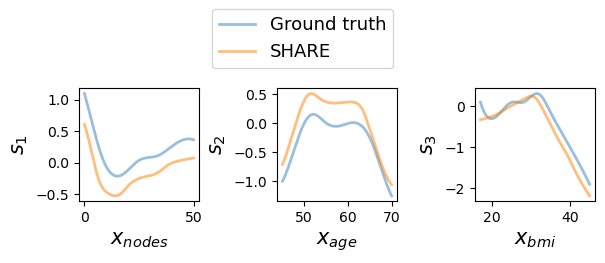

In [182]:
fig, axs = plt.subplots(1,3, figsize=(6,2.5))
plot_1(axs[0])
plot_2(axs[1])
plot_3(axs[2])
handles, labels = axs[2].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', fontsize=13)
plt.subplots_adjust(left=0.12, bottom=0.20, right=0.98, top=0.65, wspace=0.65, hspace=None)
plt.savefig('risk_scores_plot.pdf')

In [148]:
object_methods = [method_name for method_name in dir(ebm)
                  if callable(getattr(ebm, method_name))]

In [151]:
dir(ebm)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_check_feature_names',
 '_check_n_features',
 '_estimator_type',
 '_get_param_names',
 '_get_tags',
 '_more_tags',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_to_inner_jsonable',
 '_to_json',
 '_to_outer_jsonable',
 '_validate_data',
 '_validate_params',
 'available_explanations',
 'bag_weights_',
 'bagged_scores_',
 'bin_weights_',
 'binning',
 'bins_',
 'breakpoint_iteration_',
 'decision_function',
 'early_stopping_rounds',
 'early_stopping_tolerance',
 'explain_global',
 'explain_local',
 'explainer_type',
 'featur

In [152]:
ebm.term_features_

[(0,), (1,), (2,), (0, 1), (0, 2), (1, 2)]

In [81]:
timestamp = '2023-01-24T04.57.02'
numerical_arguments = {
    0: (0.0,50.0),
    1: (45,70),
    2: (17,45)
}
categorical_arguments = {}
eq = cd_df[cd_df['num_of_shapes'] == 4].sort_values(by='r2_val',ascending=False).iloc[0,0]
esr = load_share_from_checkpoint(timestamp, eq, checkpoint_dir='checkpoints', task='regression',n_features=3)

shape(mul(div(shape(X2), shape(X0)), shape(X1)))


{1: (17, 45), 2: (0.0, 50.0), 3: (45, 70), 0: (-0.0, -0.0)}


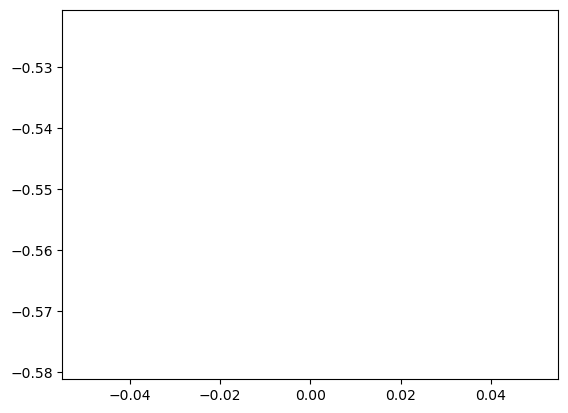

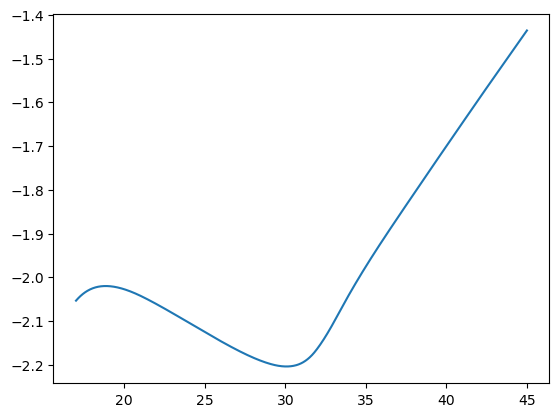

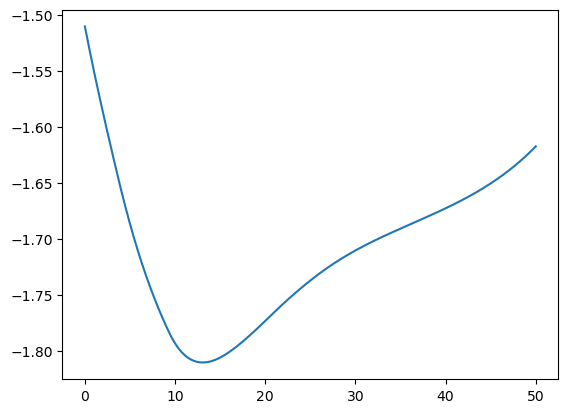

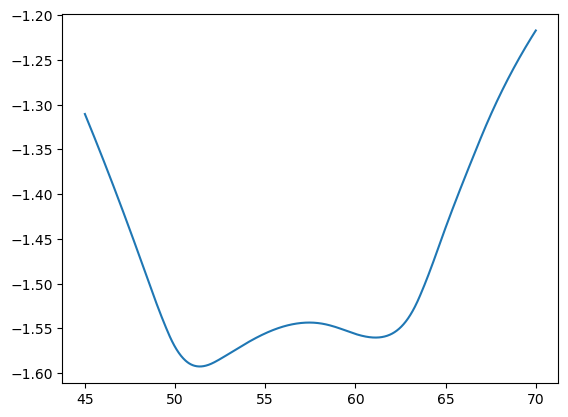

In [82]:
esr._program.plot_shape_functions(numerical_arguments,categorical_arguments)

In [83]:
def evaluate_shape(shape,t):
    shape.to(torch.device('cpu'))
    t = torch.from_numpy(t).float()
    with torch.no_grad():
        return shape(t).numpy().flatten()

In [84]:
s0 = esr._program.model.shape_functions[0]

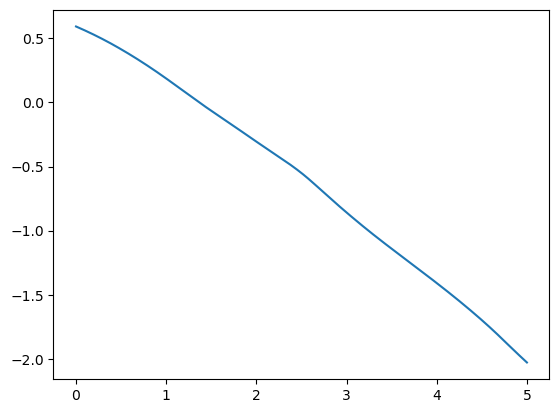

In [85]:
t = np.linspace(0,5,1000)
plt.plot(t,evaluate_shape(s0,t))